# Intro to ValidMind

## ValidMind Python Library Introduction

In [1]:
%load_ext dotenv
%dotenv dev.env

import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

## Initializing the ValidMind Library

After creating an account with ValidMind, we can find the project's API key and secret in the settings page of the ValidMind dashboard. 

The library credentials can be configured in two ways:

- By setting the `VM_API_KEY` and `VM_API_SECRET` environment variables or
- By passing `api_key` and `api_secret` arguments to the `init` function like this:

```python
vm.init(
    api_key='<your-api-key>',
    api_secret='<your-api-secret>',
    project="cl2r3k1ri000009jweny7ba1g"
)
```

The `project` argument is mandatory since it allows the library to associate all data collected with a specific account project.

In [2]:
import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  project = "clhdxzbb700020a8hpu126rq0"
)

Connected to ValidMind. Project: Customer Churn Model - Initial Validation (clhdxzbb700020a8hpu126rq0)


### Using a demo dataset

For this simple demonstration, we will use the following bank customer churn dataset from Kaggle: https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction/data.

We will train a sample model and demonstrate the following library functionalities:

- Logging information about a dataset
- Running data quality tests on a dataset
- Logging information about a model
- Logging training metrics for a model
- Running model evaluation tests

### Running a data quality test plan

We will now run the default data quality test plan that will collect the
following metadata from a dataset:

- Field types and descriptions
- Descriptive statistics
- Data distribution histograms
- Feature correlations

and will run a collection of data quality tests such as:

- Class imbalance
- Duplicates
- High cardinality
- Missing values
- Skewness

ValidMind evaluates if the data quality metrics are within expected ranges. These thresholds or ranges can be further configured by model validators.

### Load our demo dataset

Before running the test plan, we must first load the dataset into a Pandas DataFrame and initialize
a ValidMind dataset object:

In [3]:
df = pd.read_csv("./datasets/bank_customer_churn.csv")

vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="Exited",
    class_labels={
        "0": "Did not exit",
        "1": "Exited",
    }
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


#### Initialize and run the TabularDataset test plan

We can now initialize the `TabularDataset` test plan. The primary method of doing this is with the `run_test_plan` function from the `vm` module. This function takes in a test plan name (in this case `tabular_dataset`) and a `dataset` keyword argument (the `vm_dataset` object we created earlier):

```python
vm.run_test_plan("tabular_dataset", dataset=vm_dataset)
```

In [4]:
# tabular_plan = vm.run_test_plan("tabular_dataset", dataset=vm_dataset)

### Finding all test plans available in the developer framework

We can find all the test plans available in the developer framework by calling the following functions:

- All test plans: `vm.test_plans.list_plans()`
- Describe a test plan: `vm.test_plans.describe_plan("tabular_dataset")`
- List all available tests: `vm.test_plans.list_tests()`

As an example, here's the outpout `list_plans()` and `list_tests()`:

In [5]:
# vm.test_plans.list_plans()

In [6]:
# vm.test_plans.list_tests()

### Preparing the dataset for training

Before we train a model, we need to run some common minimal feature selection and engineering steps on the dataset:

- Dropping irrelevant variables
- Encoding categorical variables

#### Dropping irrelevant variables

The following variables will be dropped from the dataset:

- `RowNumber`: it's a unique identifier to the record
- `CustomerId`: it's a unique identifier to the customer
- `Surname`: no predictive power for this variable
- `CreditScore`: we didn't observer any correlation between `CreditScore` and our target column `Exited`

In [7]:
df.drop(["RowNumber", "CustomerId", "Surname", "CreditScore"], axis=1, inplace=True)

#### Encoding categorical variables

We will apply one-hot or dummy encoding to the following variables:

- `Geography`: only 3 unique values found in the dataset
- `Gender`: convert from string to integer

In [8]:
genders = {"Male": 0, "Female": 1}
df.replace({"Gender": genders}, inplace=True)

In [9]:
df = pd.concat([df, pd.get_dummies(df["Geography"], prefix="Geography")], axis=1)
df.drop("Geography", axis=1, inplace=True)

We are now ready to train our model with the preprocessed dataset:

In [10]:
df.head()

Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       1   42       2       0.00              1          1               1   
1       1   41       1   83807.86              1          0               1   
2       1   42       8  159660.80              3          1               0   
3       1   39       1       0.00              2          0               0   
4       1   43       2  125510.82              1          1               1   

   EstimatedSalary  Exited  Geography_France  Geography_Germany  \
0        101348.88       1                 1                  0   
1        112542.58       0                 0                  0   
2        113931.57       1                 1                  0   
3         93826.63       0                 1                  0   
4         79084.10       0                 0                  0   

   Geography_Spain  
0                0  
1                1  
2                0  
3                0  
4                1

#### Dataset preparation

For training our model, we will **randomly** split the dataset in 3 parts:

- `training` split with 60% of the rows
- `validation` split with 20% of the rows
- `test` split with 20% of the rows

The `test` dataset will be our held out dataset for model evaluation.

In [11]:
train_df, test_df = train_test_split(df, test_size=0.20)

# This guarantees a 60/20/20 split
train_ds, val_ds = train_test_split(train_df, test_size=0.25)

# For training
x_train = train_ds.drop("Exited", axis=1)
y_train = train_ds.loc[:, "Exited"].astype(int)
x_val = val_ds.drop("Exited", axis=1)
y_val = val_ds.loc[:, "Exited"].astype(int)

# For testing
x_test = test_df.drop("Exited", axis=1)
y_test = test_df.loc[:, "Exited"].astype(int)

### Model training

We will train a simple XGBoost model and set its `eval_set` to `[(x_train, y_train), (x_val, y_val)]` in order to collect validation datasets metrics on every round. The ValidMind library supports collecting any type of "in training" metrics so model developers can provide additional context to model validators if necessary.

In [12]:
# model = xgb.XGBClassifier(early_stopping_rounds=10)
# model.set_params(
#     eval_metric=["error", "logloss", "auc"],
# )
# model.fit(
#     x_train,
#     y_train,
#     eval_set=[(x_train, y_train), (x_val, y_val)],
#     verbose=False,
# )

# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()
# model.fit(x_train, y_train)

# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier()
# model.fit(x_train, y_train)

# import statsmodels.api as sm

# model = sm.Logit(y_train, x_train)
# result = model.fit()

# Now build a pytorch model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x
    
net = Net(11, 5, 1)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(torch.tensor(x_train.values, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1))
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

outputs = net(torch.tensor(x_test.values, dtype=torch.float32))
predictions = outputs.detach().numpy()
predictions = predictions.round().astype(int)

accuracy_score(y_test, predictions)

Optimization terminated successfully.
         Current function value: 0.427966
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.154      
Dependent Variable: Exited           AIC:              4130.4702  
Date:               2023-05-10 22:02 BIC:              4201.7103  
No. Observations:   4800             Log-Likelihood:   -2054.2    
Df Model:           10               LL-Null:          -2429.4    
Df Residuals:       4789             LLR p-value:      9.7711e-155
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Gender             0.5064   0.0786   6.4396 0.0000  0.3522  0.6605
Age                0.0724   0.0037  19.3766 0.0000  0

In [13]:
# y_pred = model.predict_proba(x_val)[:, -1]
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_val, predictions)

# print(f"Accuracy: {accuracy}")

In [14]:
from sklearn.inspection import permutation_importance

result.fit = lambda **kwargs: None

permutation_importance(result, x_test, y_test, scoring='neg_root_mean_squared_error')

{'importances_mean': array([ 3.64809676e-03,  4.11926831e-02,  4.21588194e-05,  4.76090843e-04,
         2.20009808e-04, -8.59618519e-05,  1.67558849e-02, -1.27627613e-05,
         1.66255680e-01,  9.10806227e-02,  1.19092346e-01]),
 'importances_std': array([9.66640044e-04, 3.00896807e-03, 1.99460973e-05, 3.51973410e-04,
        2.26000302e-04, 9.63441364e-05, 1.83610362e-03, 1.68881709e-04,
        8.40958461e-03, 2.67421706e-03, 2.78728208e-03]),
 'importances': array([[ 3.79391805e-03,  5.41444568e-03,  3.36420588e-03,
          2.58448595e-03,  3.08342826e-03],
        [ 4.46321770e-02,  4.27168037e-02,  4.25916330e-02,
          3.58997418e-02,  4.01230599e-02],
        [ 9.88523144e-06,  4.62548689e-05,  3.65829189e-05,
          7.18833771e-05,  4.61877008e-05],
        [ 6.61653103e-04,  8.96154869e-04, -1.51858580e-04,
          5.70827617e-04,  4.03677206e-04],
        [-1.90960953e-04,  4.81114459e-04,  3.37386964e-04,
          2.80991938e-04,  1.91516632e-04],
        [-8

In [15]:
# Predict probabilities
y_pred = result.predict(x_val)

# Convert probabilities to class labels using 0.5 as threshold
predictions = [round(value) for value in y_pred]

# Compute accuracy
accuracy = accuracy_score(y_val, predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.809375


### Running a model evaluation test plan

We will now run a basic model evaluation test plan that is compatible with the model we have trained.
Since we have trained an XGBoost model with a sklearn-like API, we will use the `SKLearnClassifier` test plan. This test plan will collect model metadata and metrics, and run a variety of model evaluation tests, according to the modeling objective (binary classification for this example).

The following model metadata is collected:

- Model framework and architecture (e.g. XGBoost, Random Forest, Logistic Regression, etc.)
- Model task details (e.g. binary classification, regression, etc.)
- Model hyperparameters (e.g. number of trees, max depth, etc.)

The model metrics that are collected depend on the model type, use case, etc. For example, for a binary classification model, the following metrics could be collected (again, depending on configuration):

- AUC
- Error rate
- Logloss
- Feature importance

Similarly, different model evaluation tests are run depending on the model type, use case, etc. For example, for a binary classification model, the following tests could be executed:

- Simple training/test overfit test
- Training/test performance degradation
- Baseline test dataset performance test

#### Initialize VM model object and train/test datasets

In order to run our SKLearnClassifier test plan, we need to initialize ValidMind object instances for the trained model and the training and test datasets:

In [16]:
vm_model = vm.init_model(result)
vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic", target_column="Exited")
vm_test_ds = vm.init_dataset(dataset=test_df, type="generic", target_column="Exited")

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


We can now run the `SKLearnClassifier` test plan:

Logging result: TestPlanMetricResult(result_id="model_metadata", metric, figures):   0%|          | 0/10 [00:00<?, ?it/s]  

Skiping PFI for statsmodels models
Skiping CSI for statsmodels models
Skiping PSI for statsmodels models
Skiping SHAP for statsmodels models



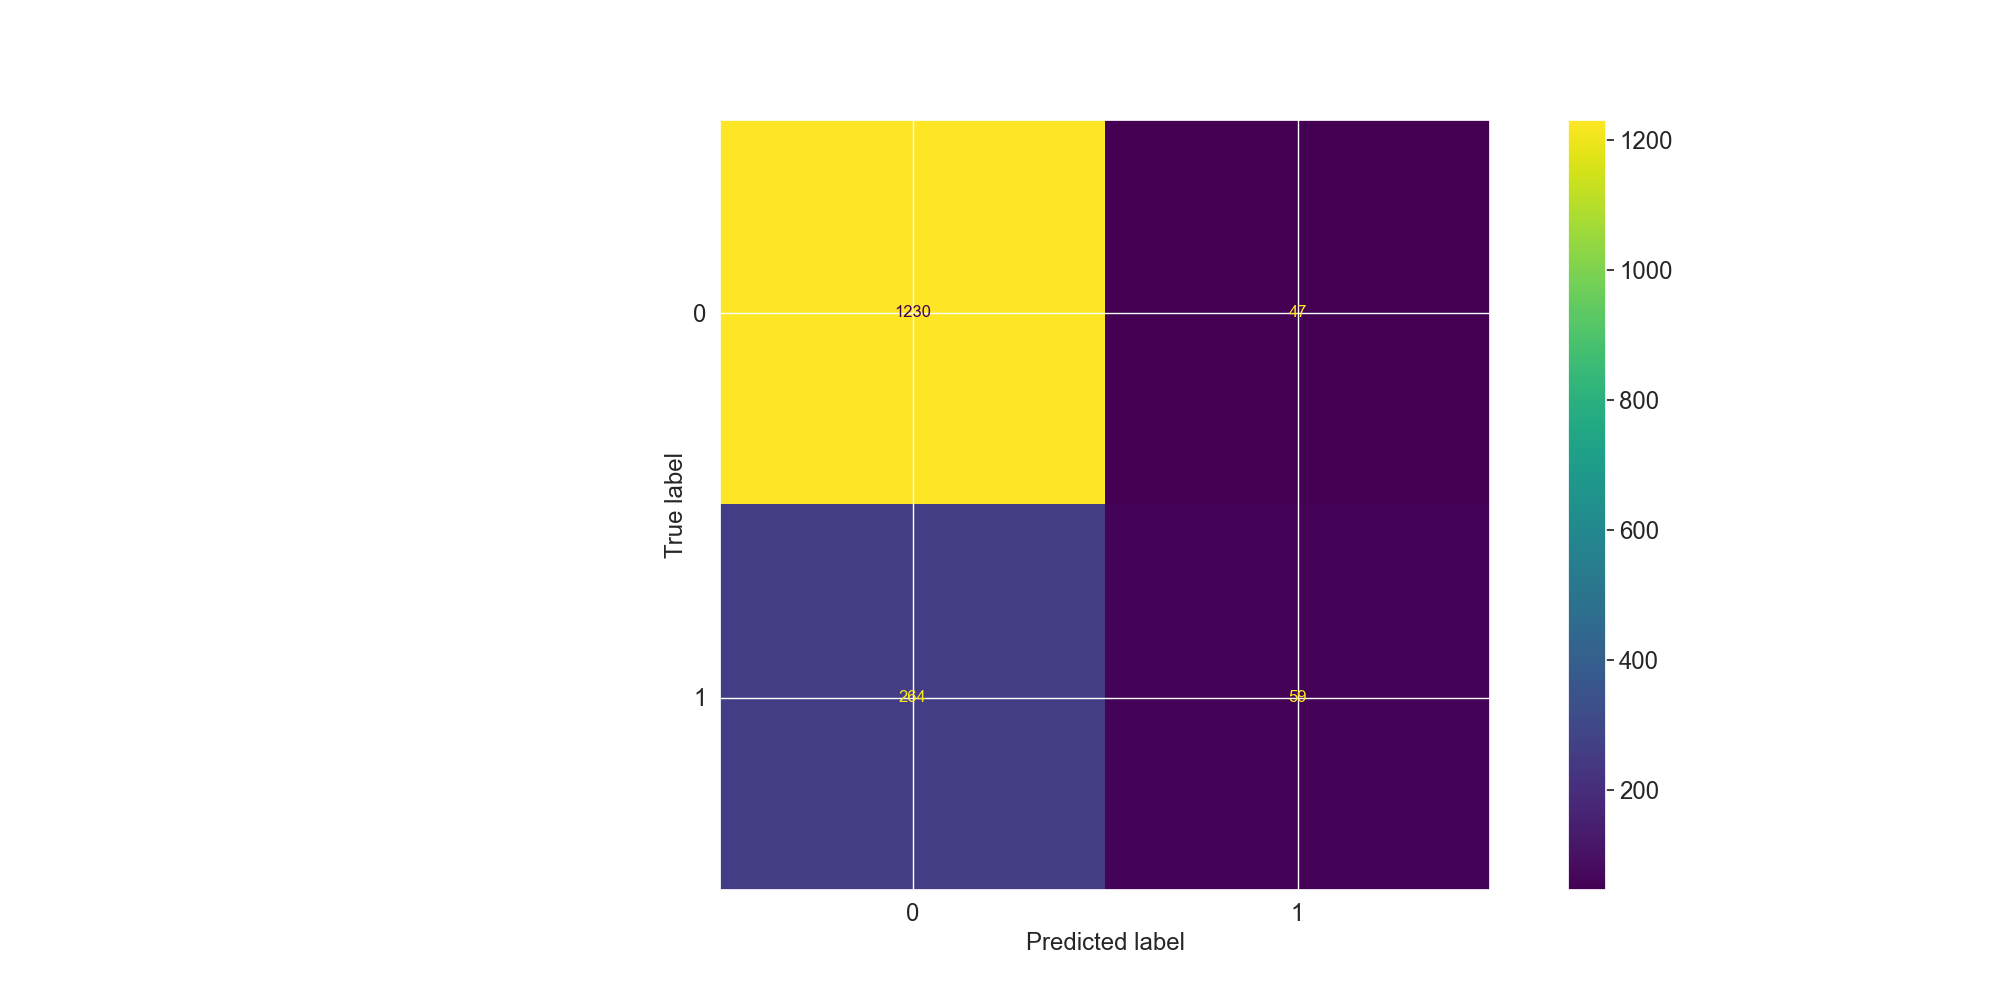
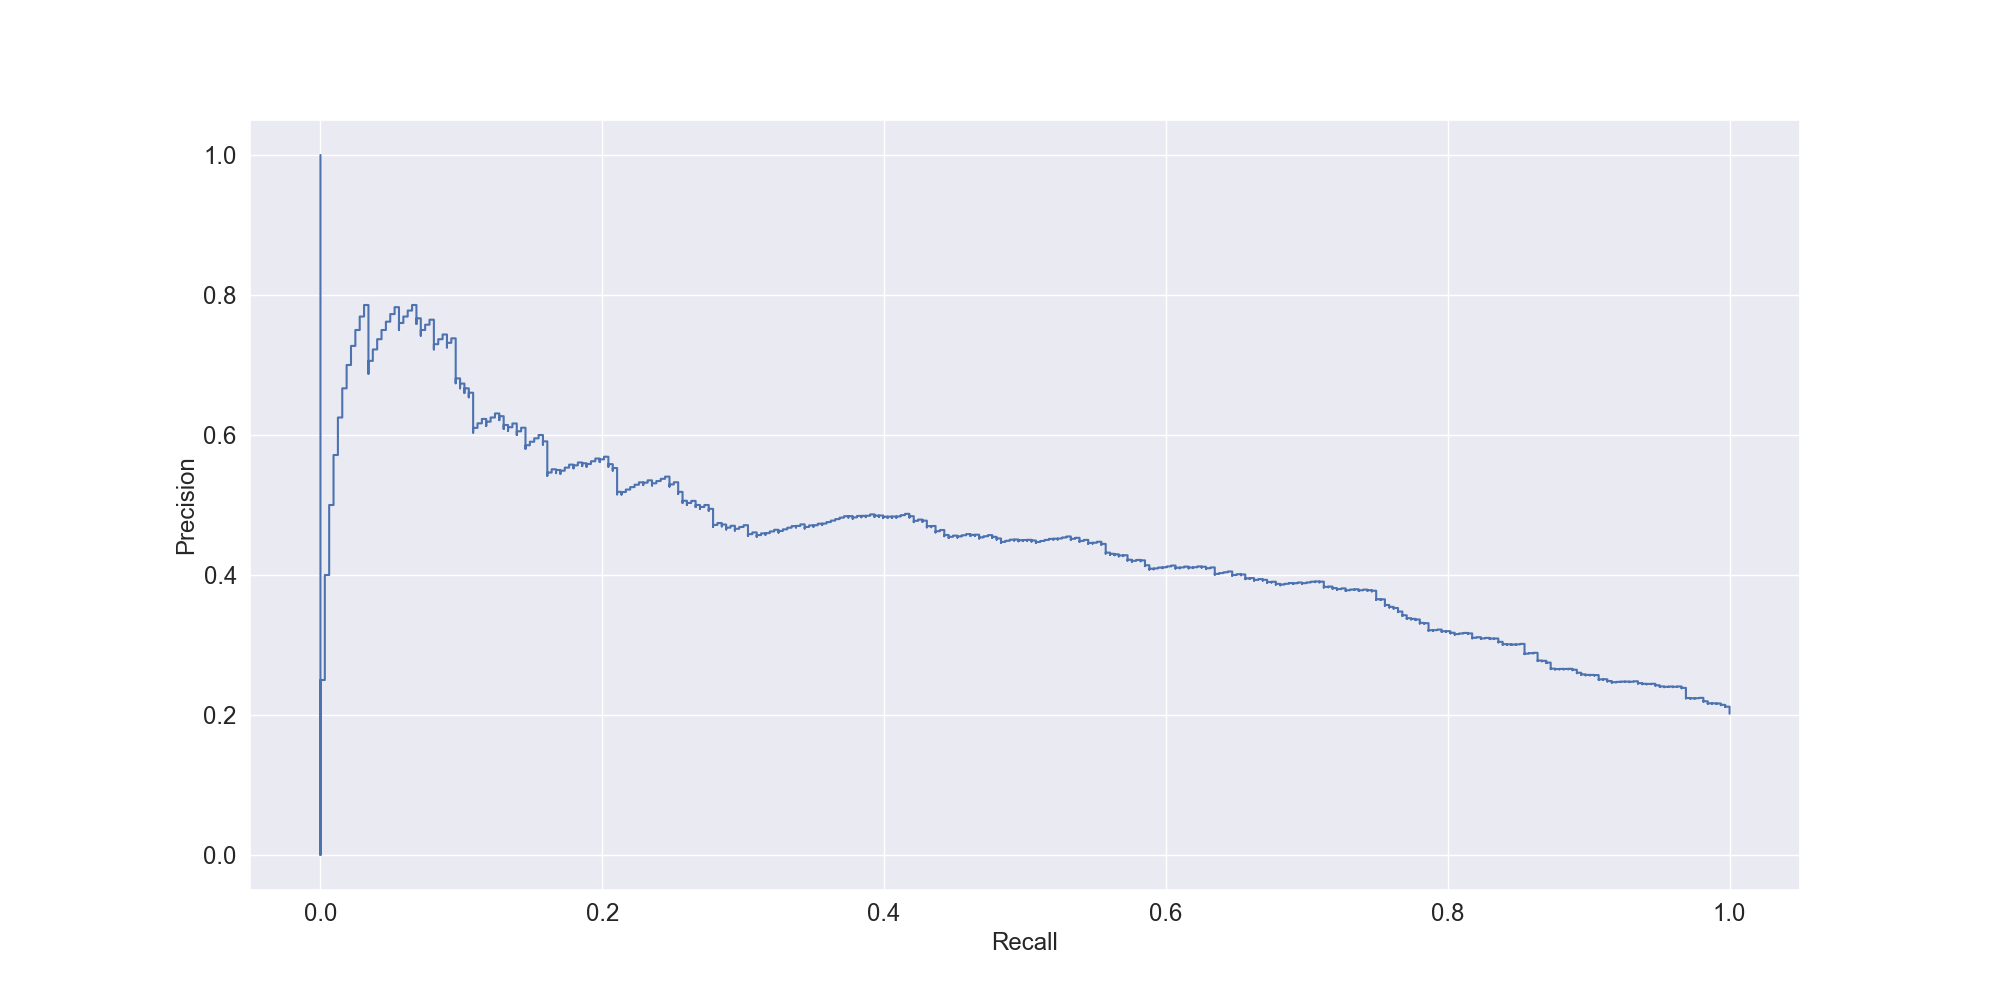
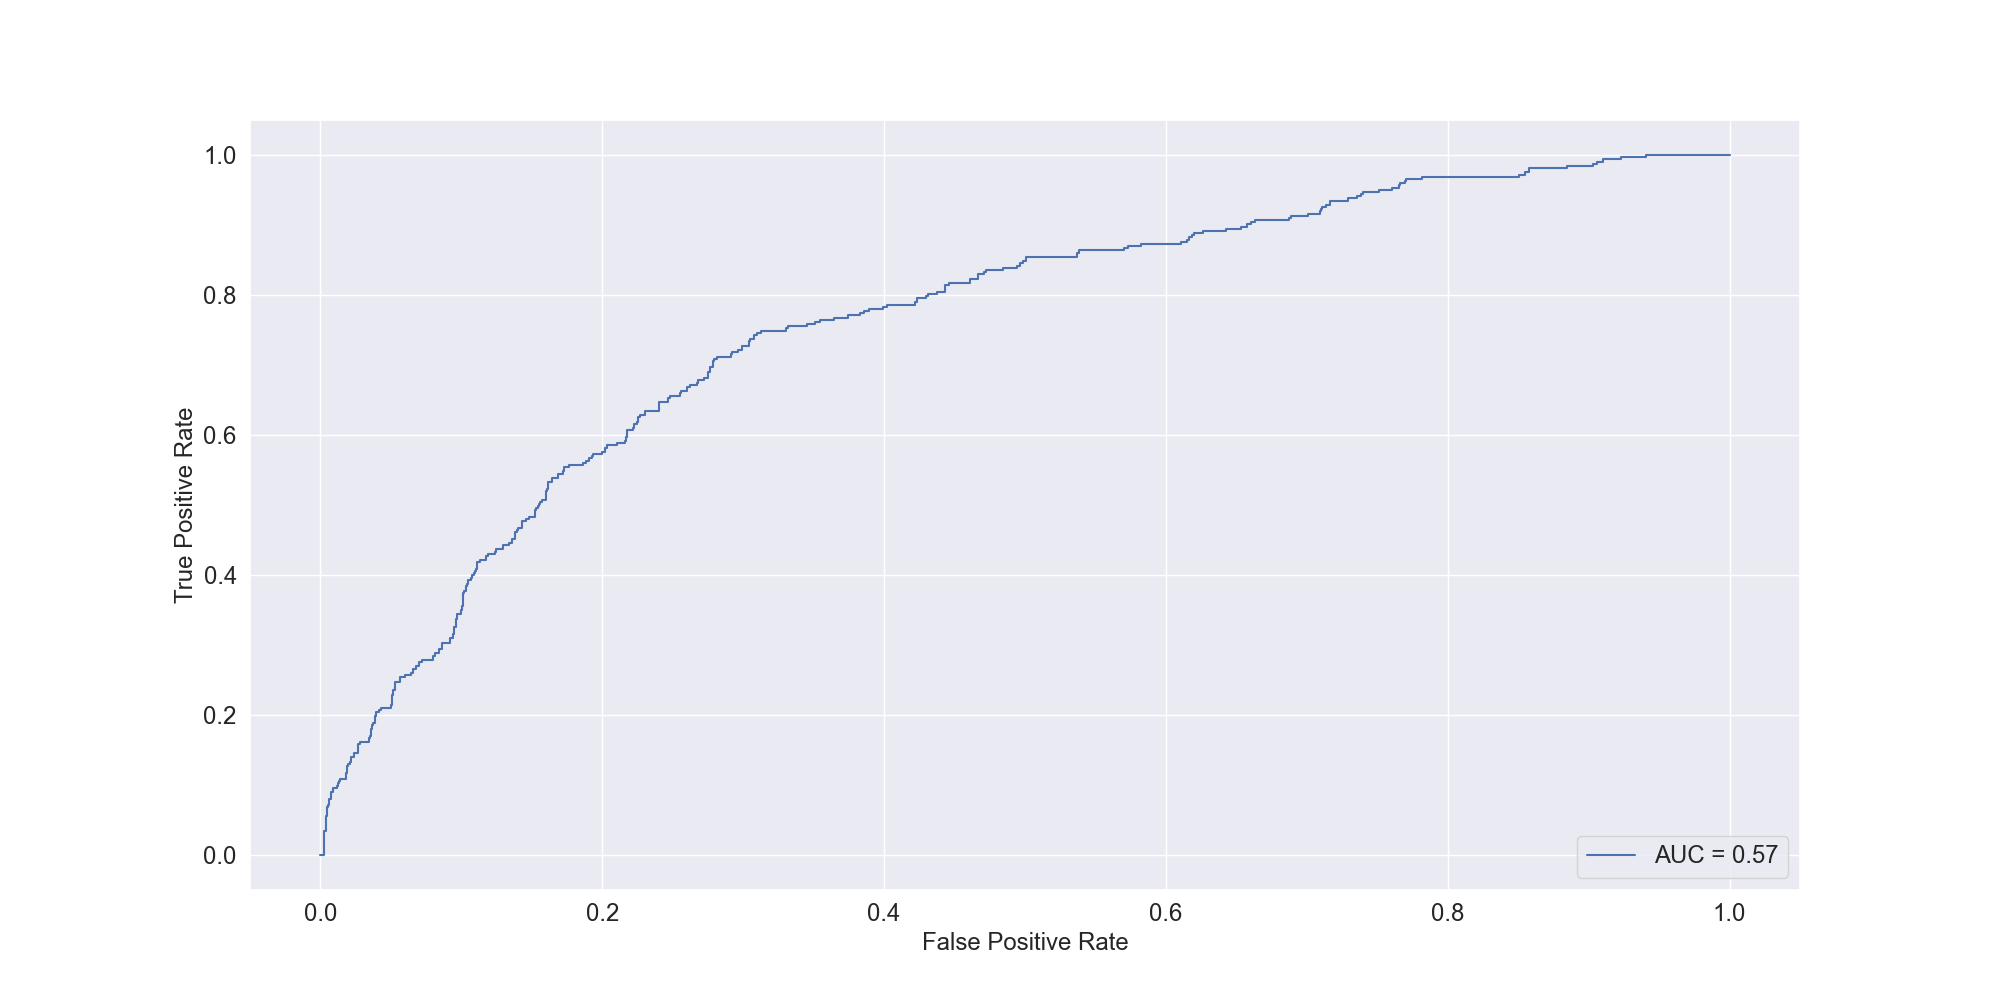


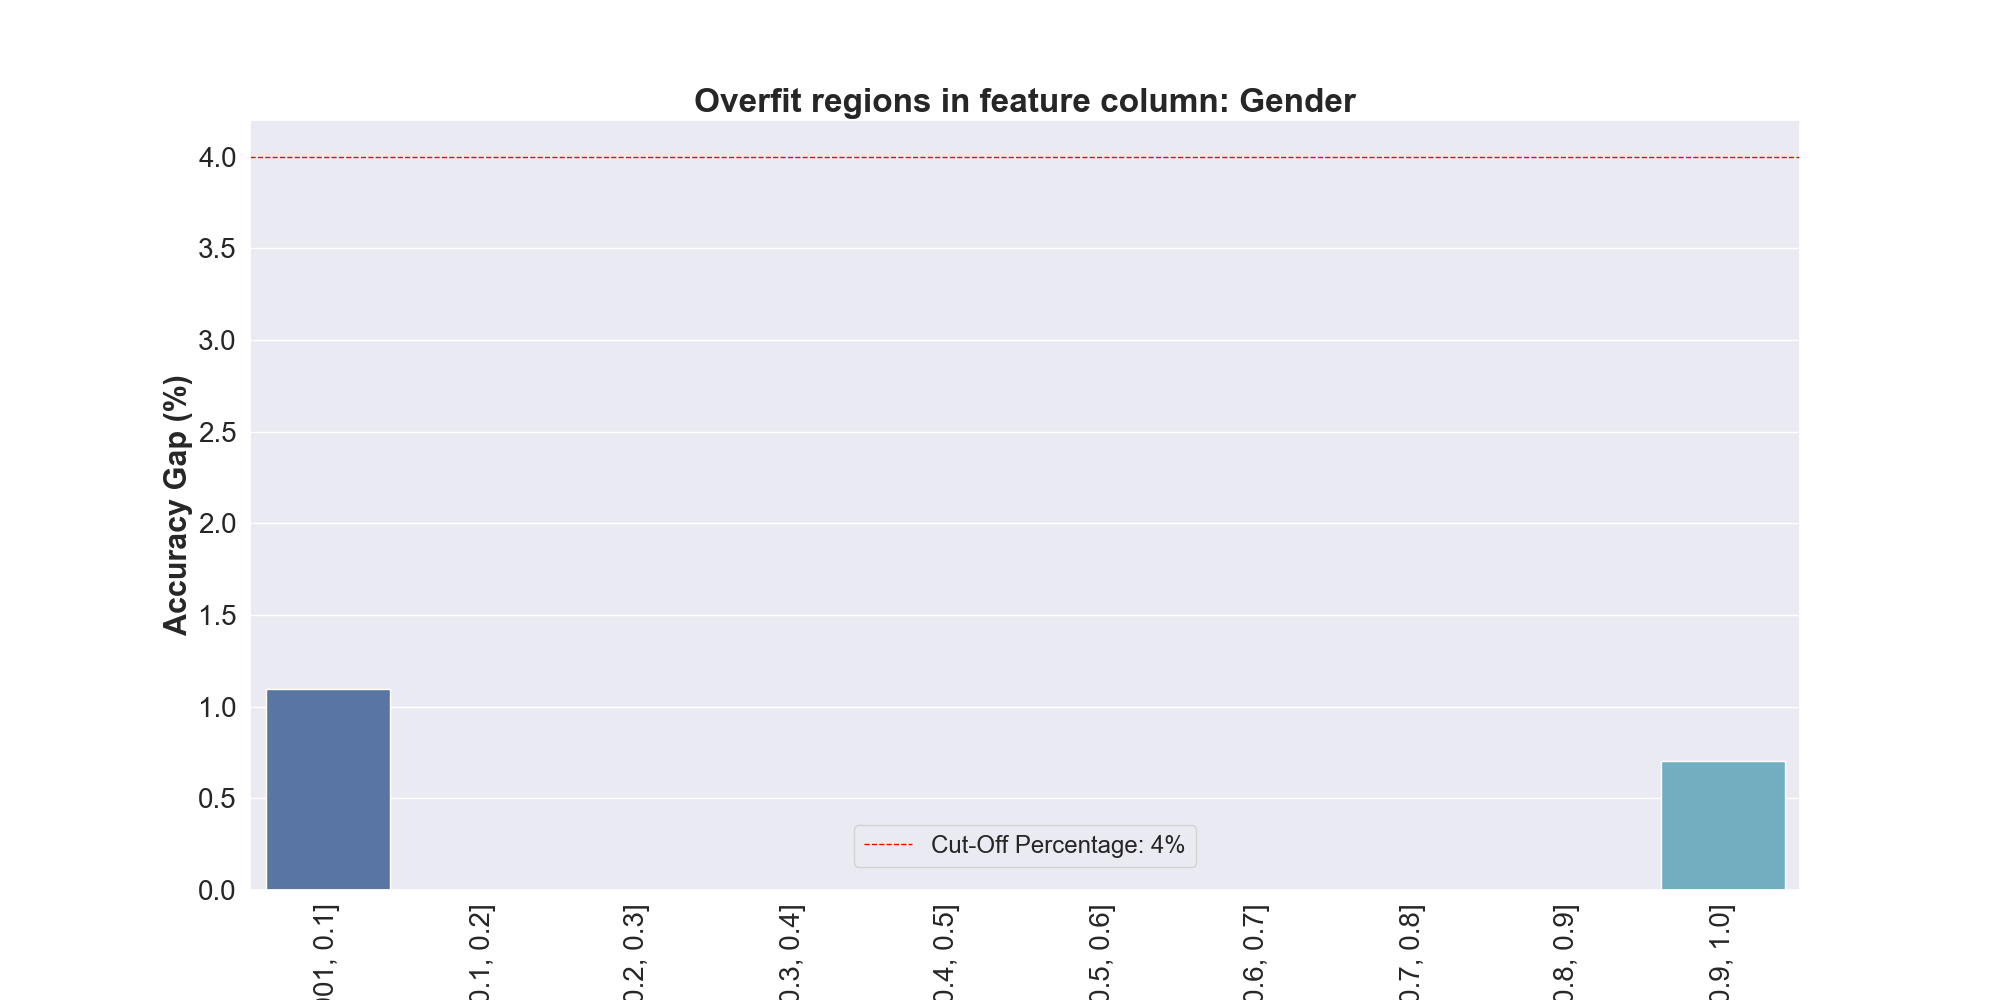
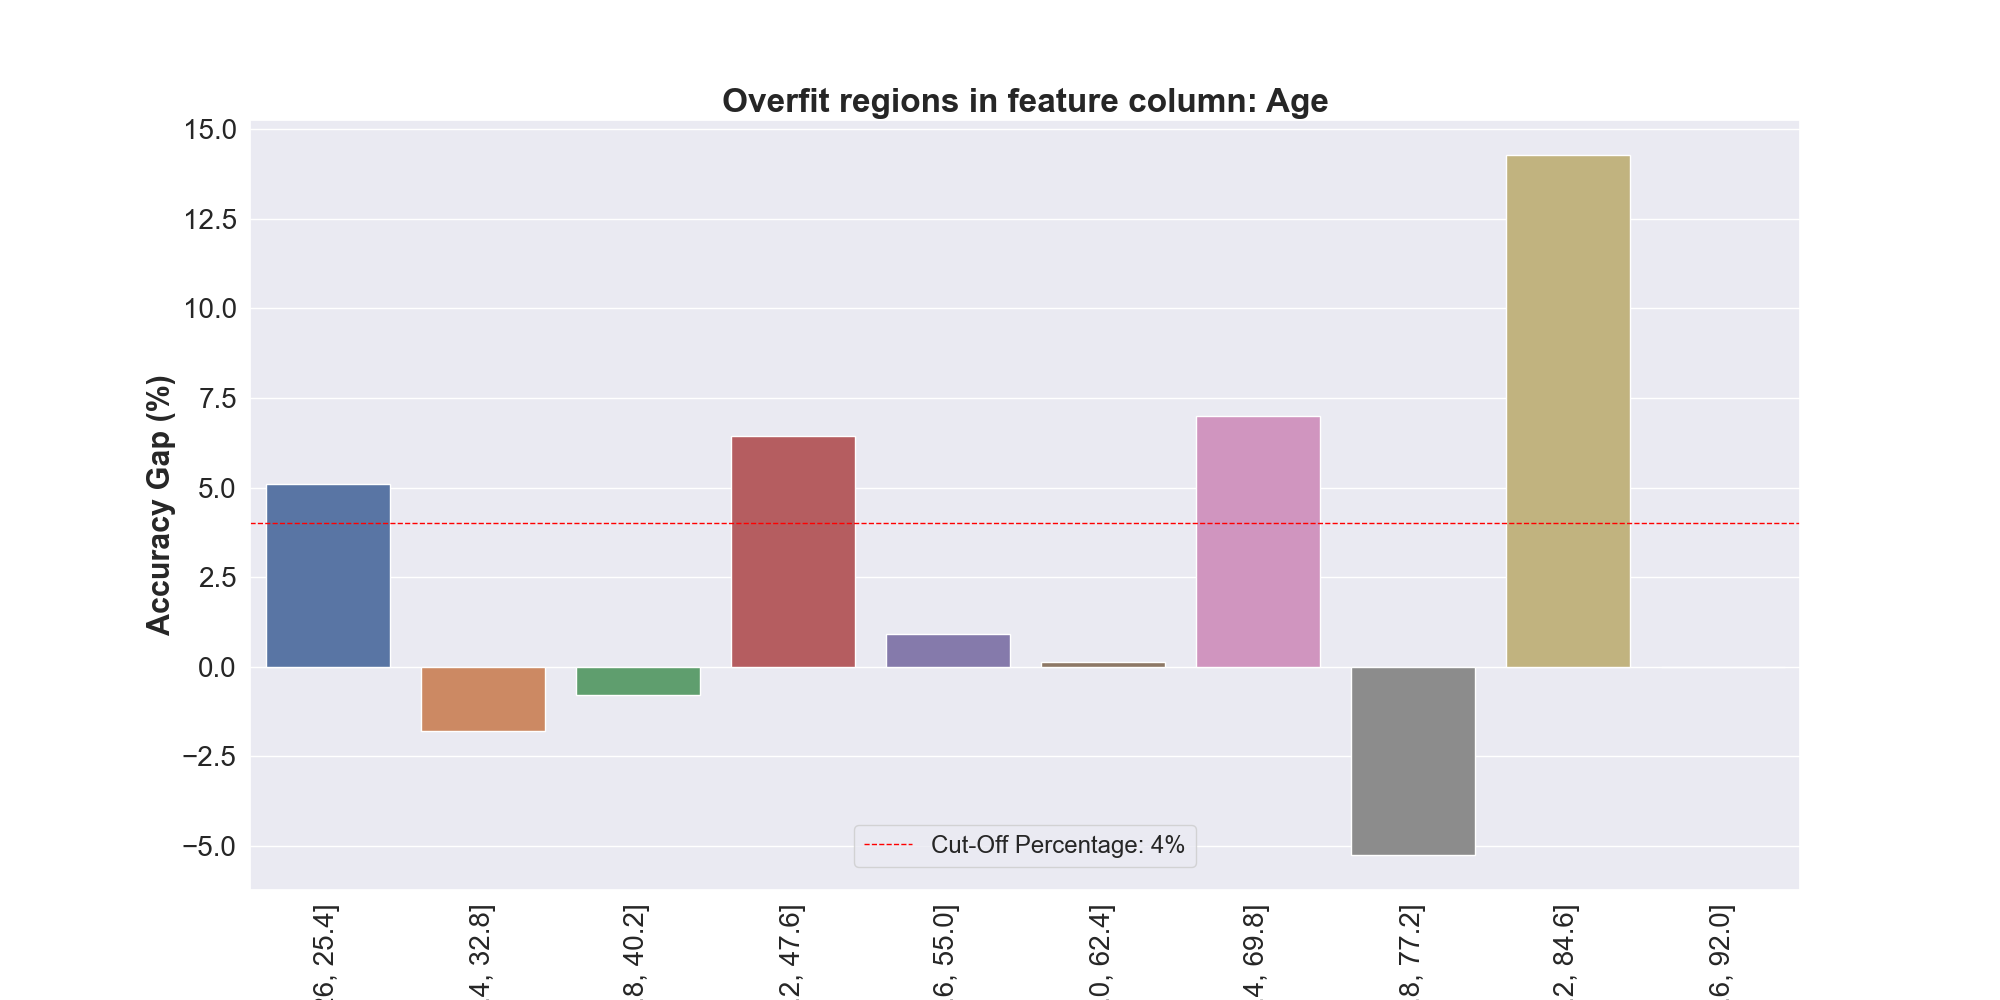
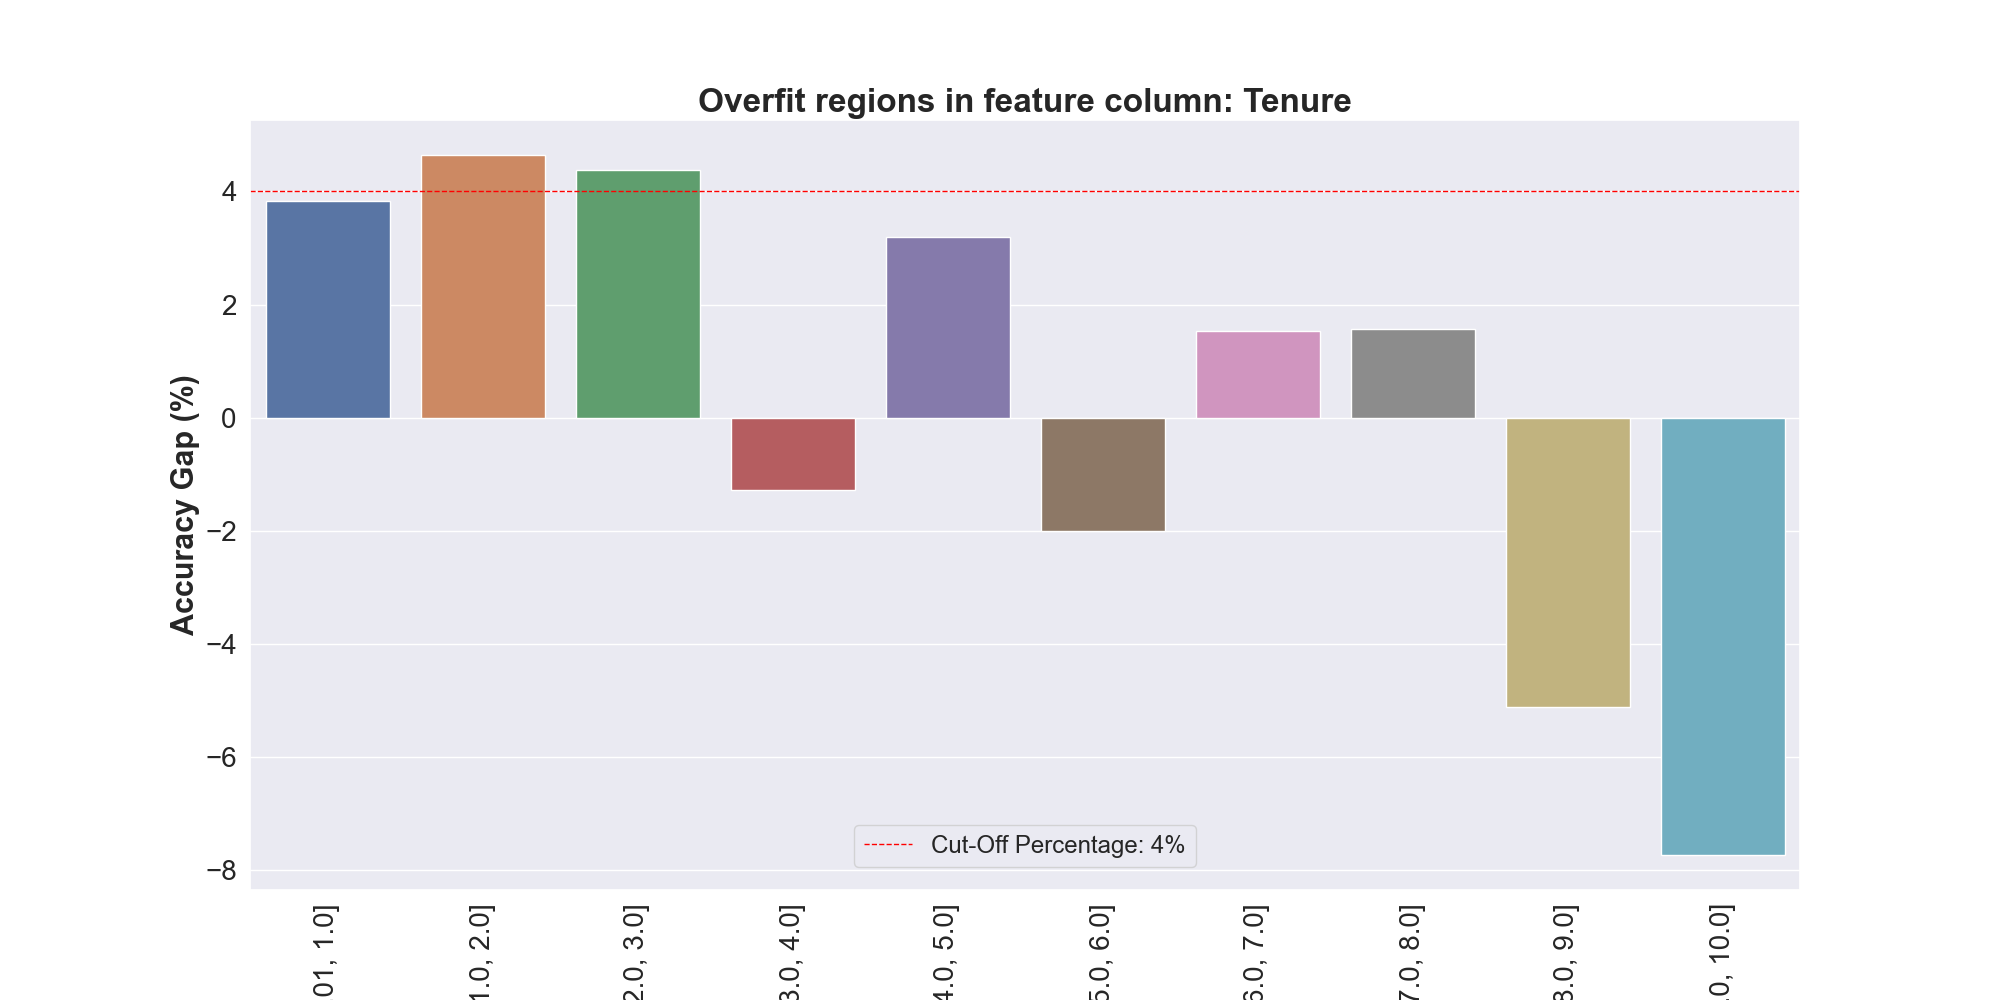
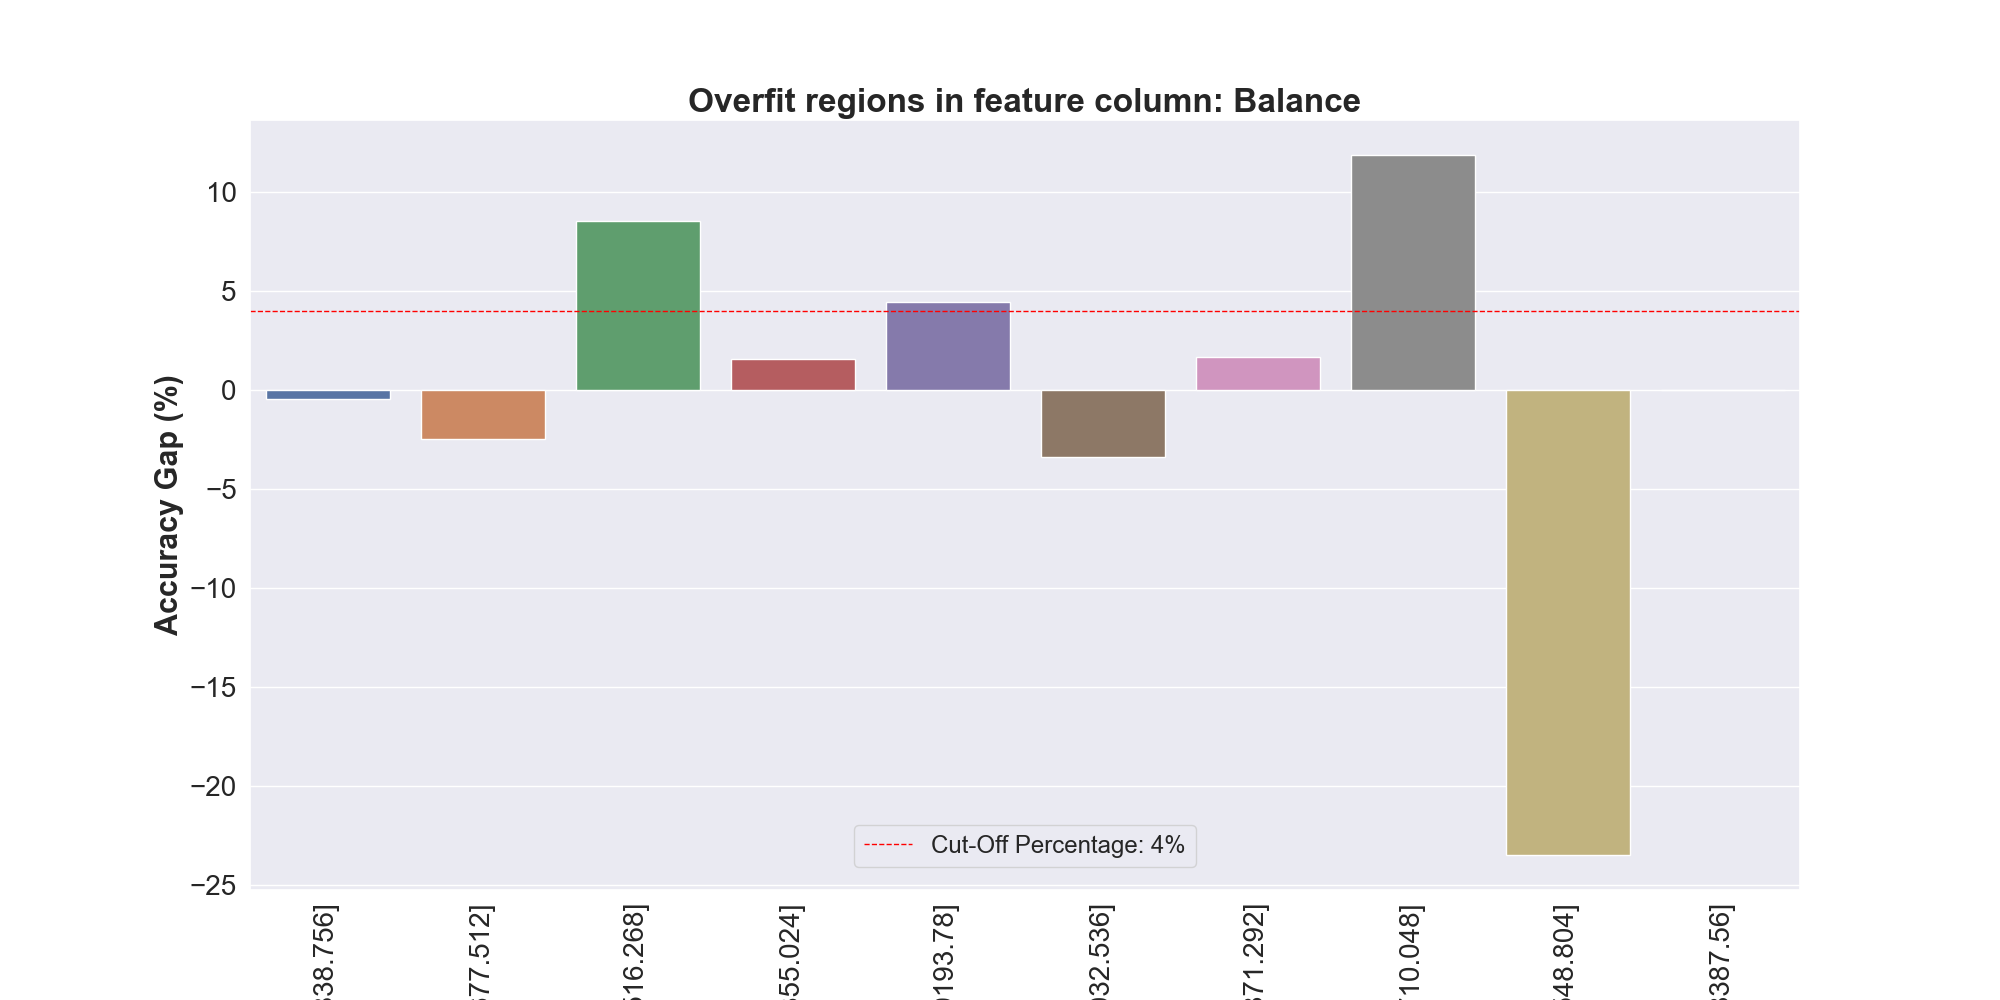
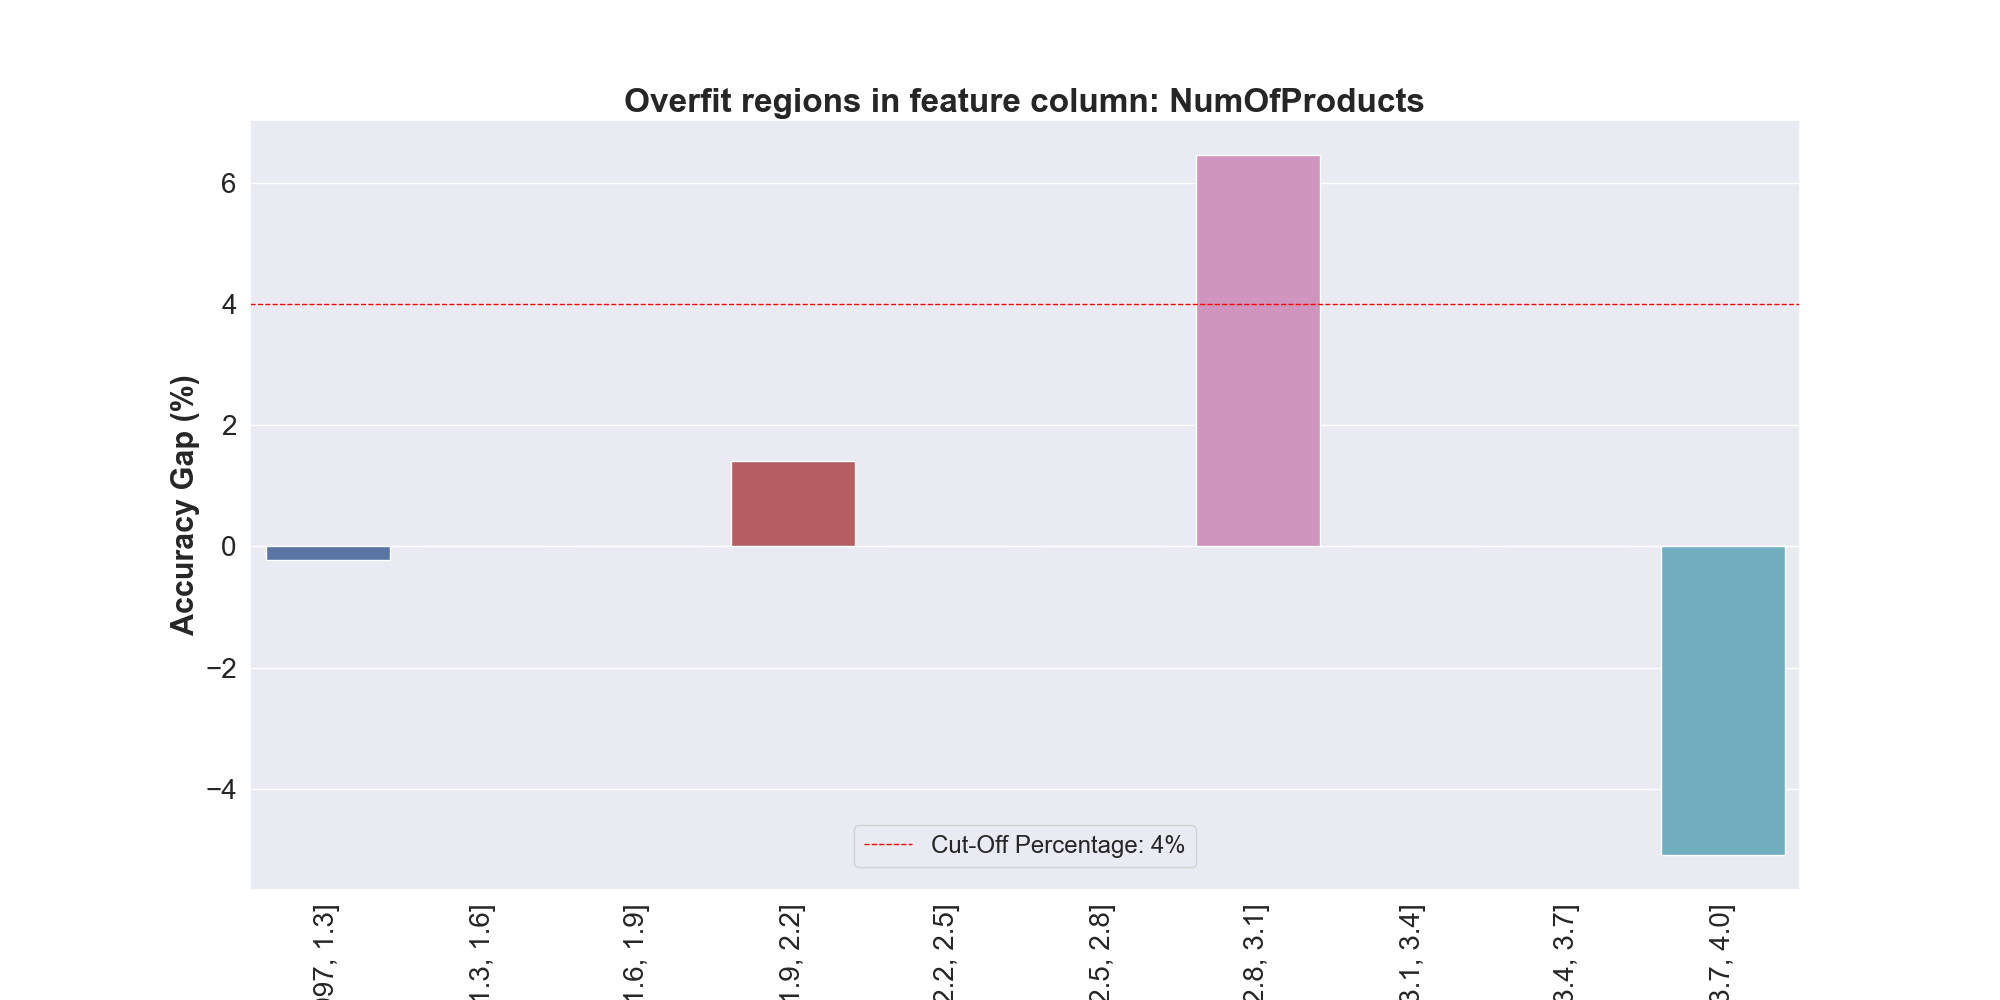
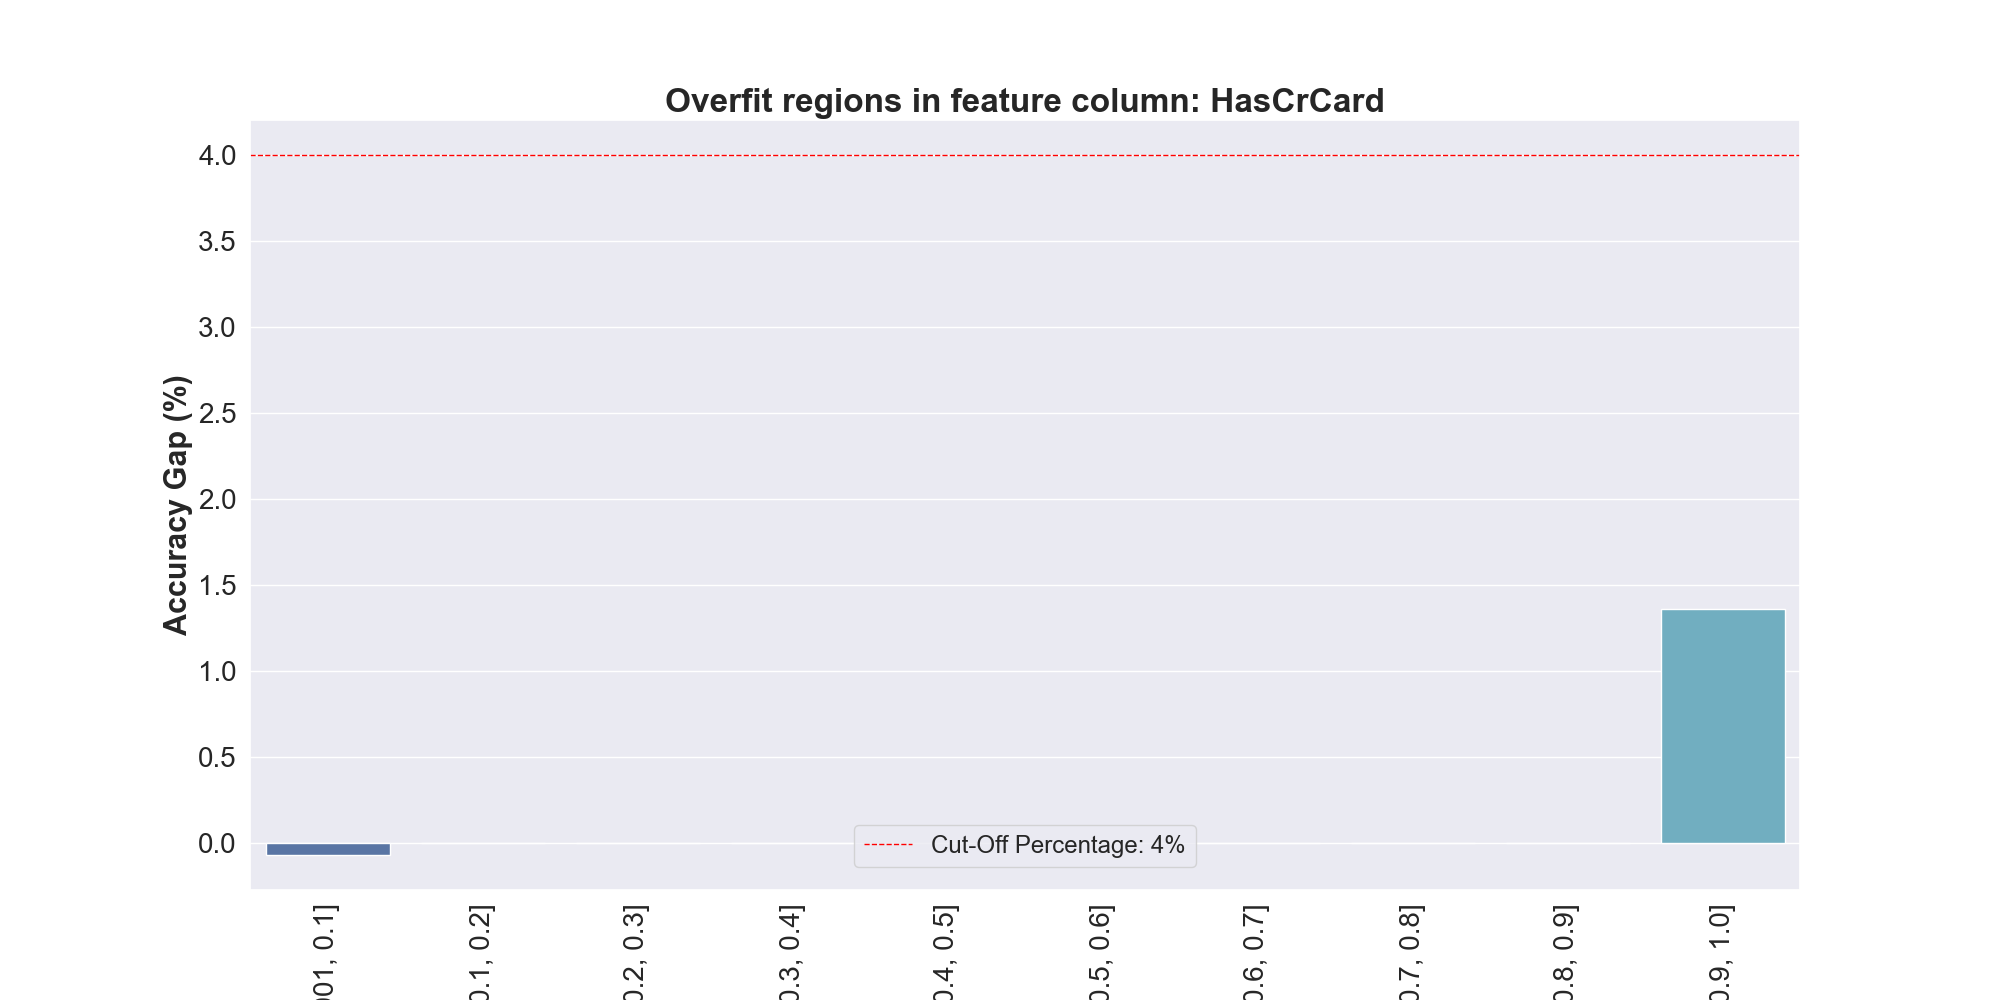
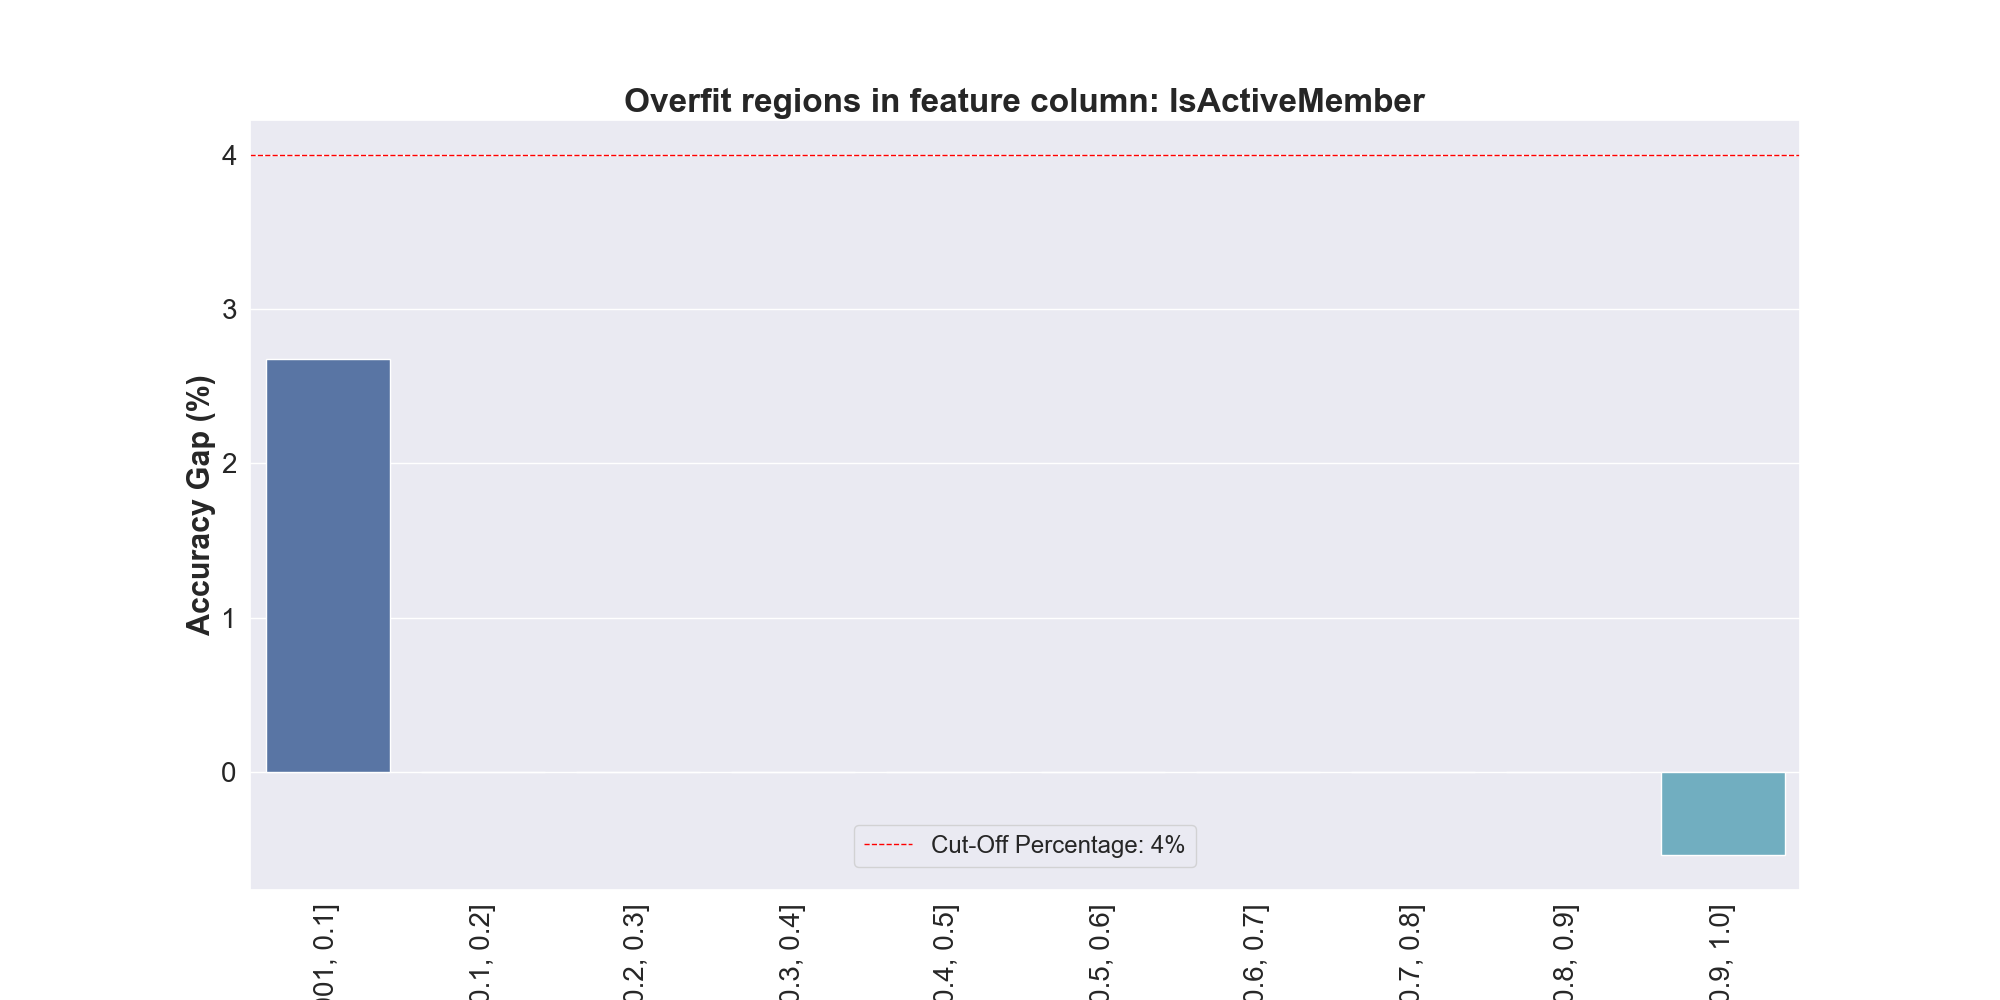
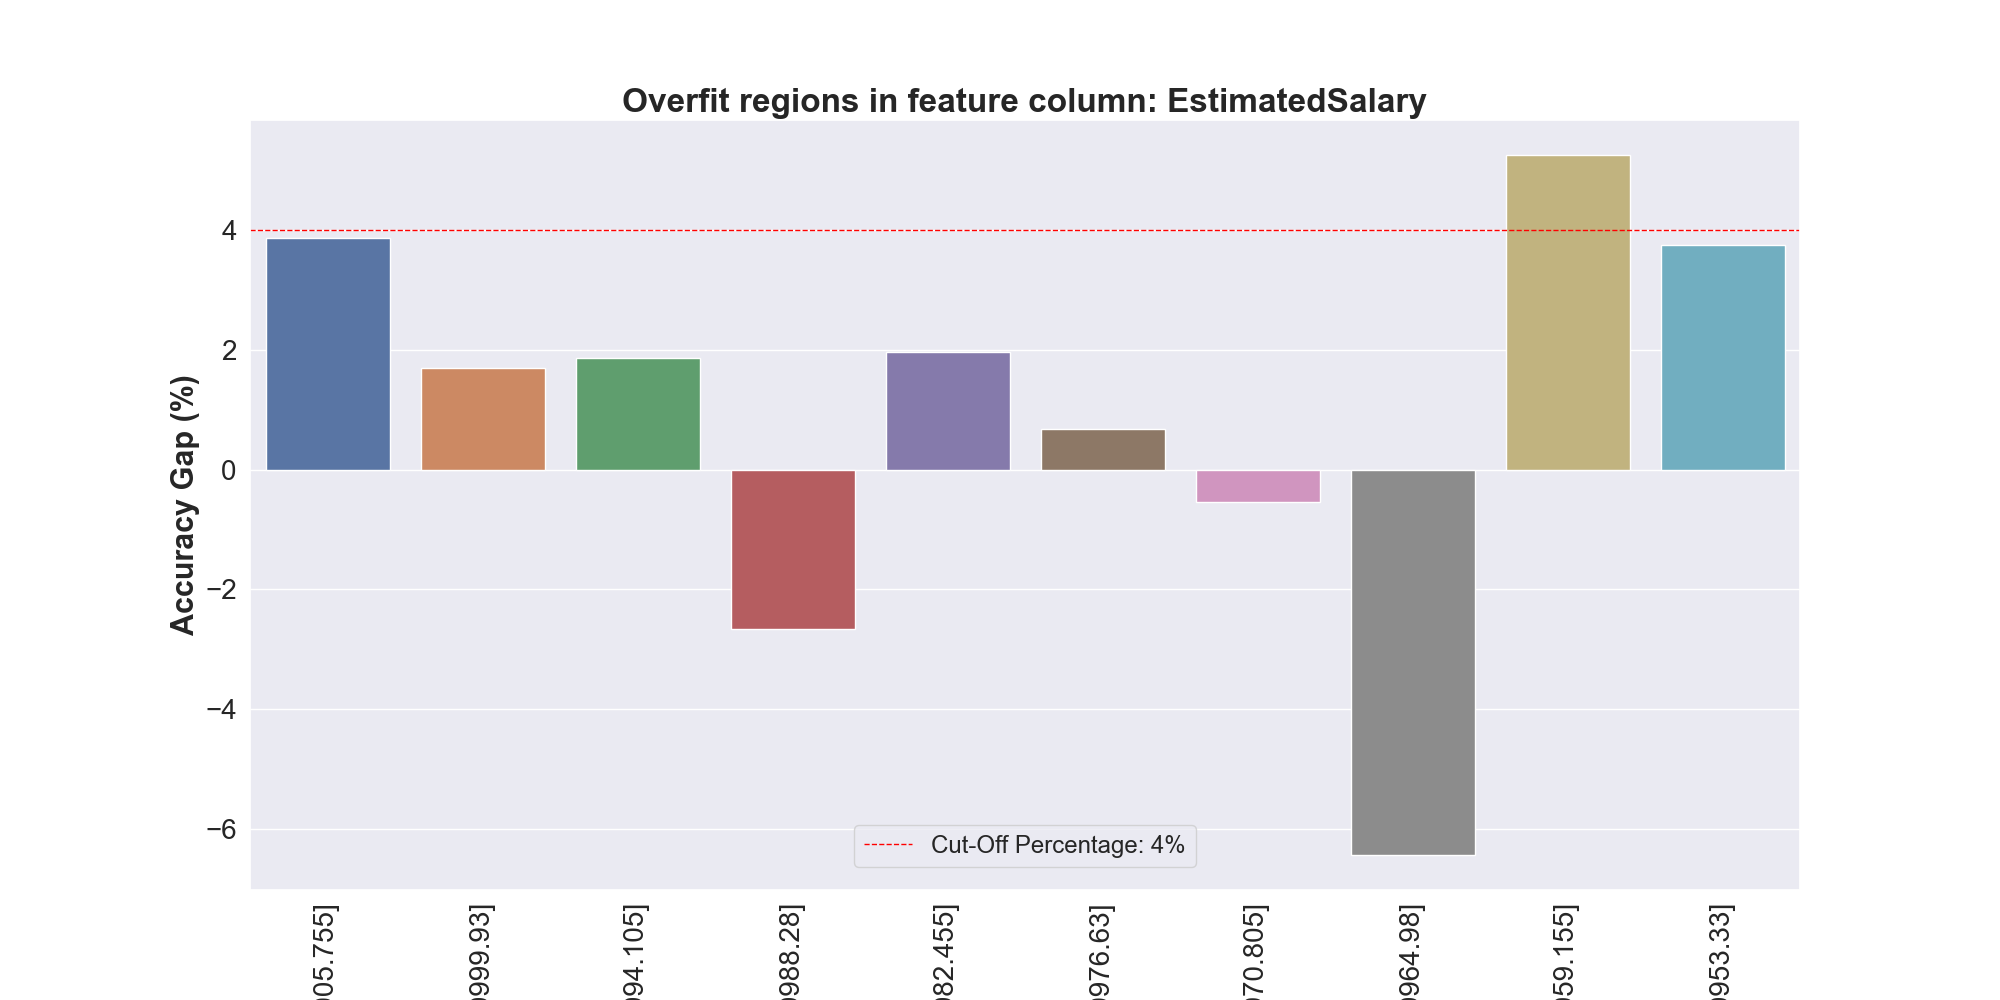
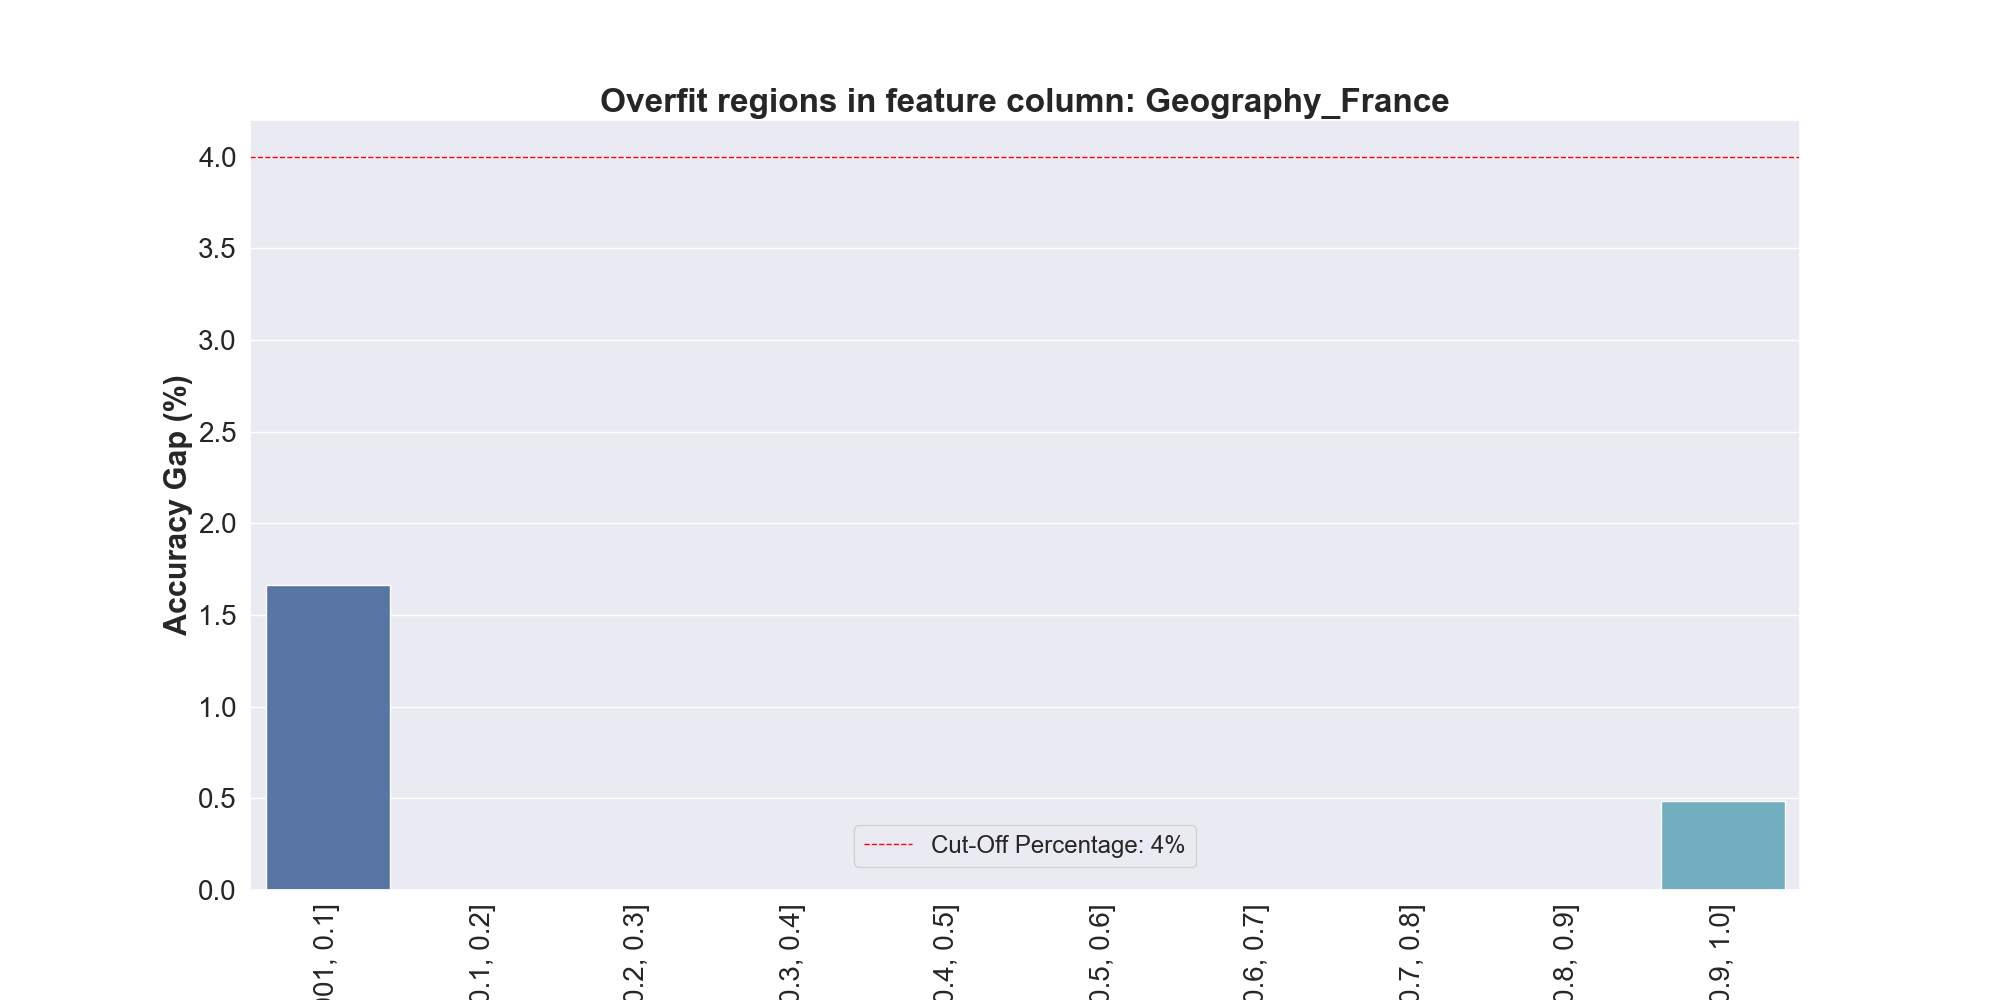
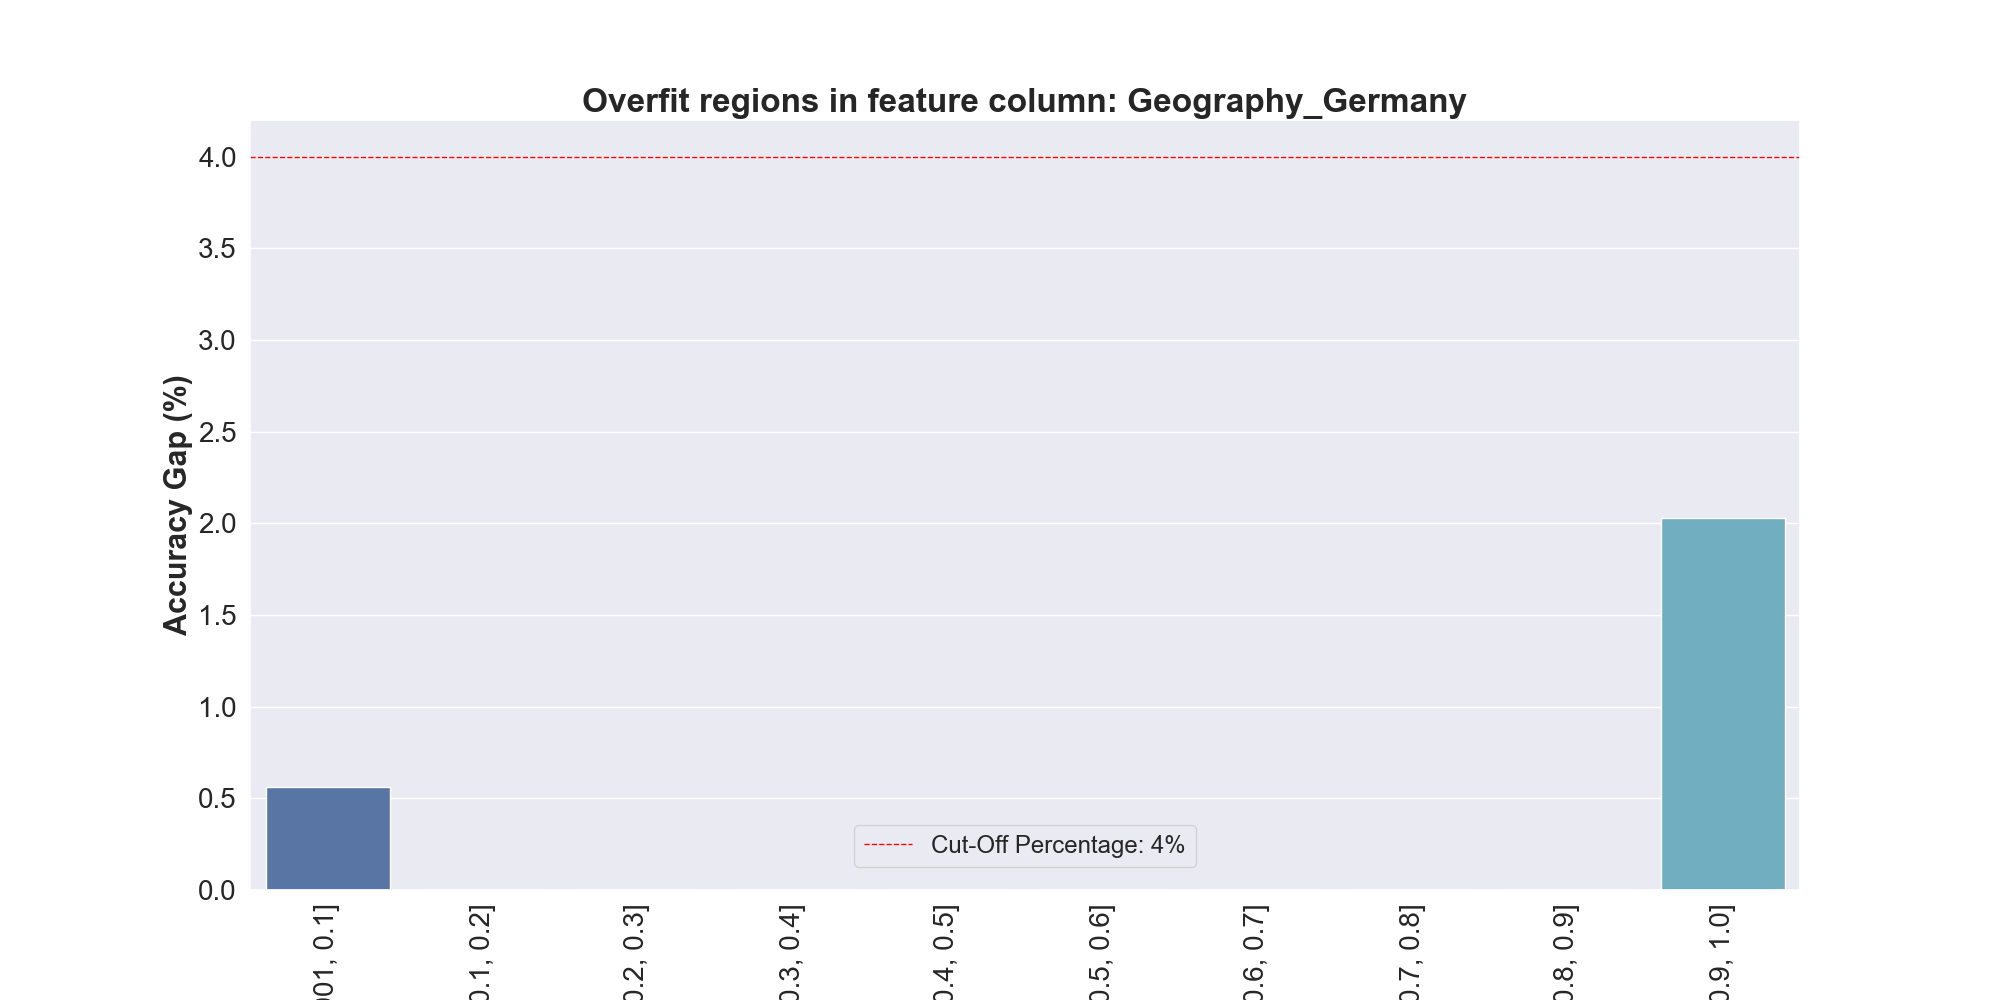
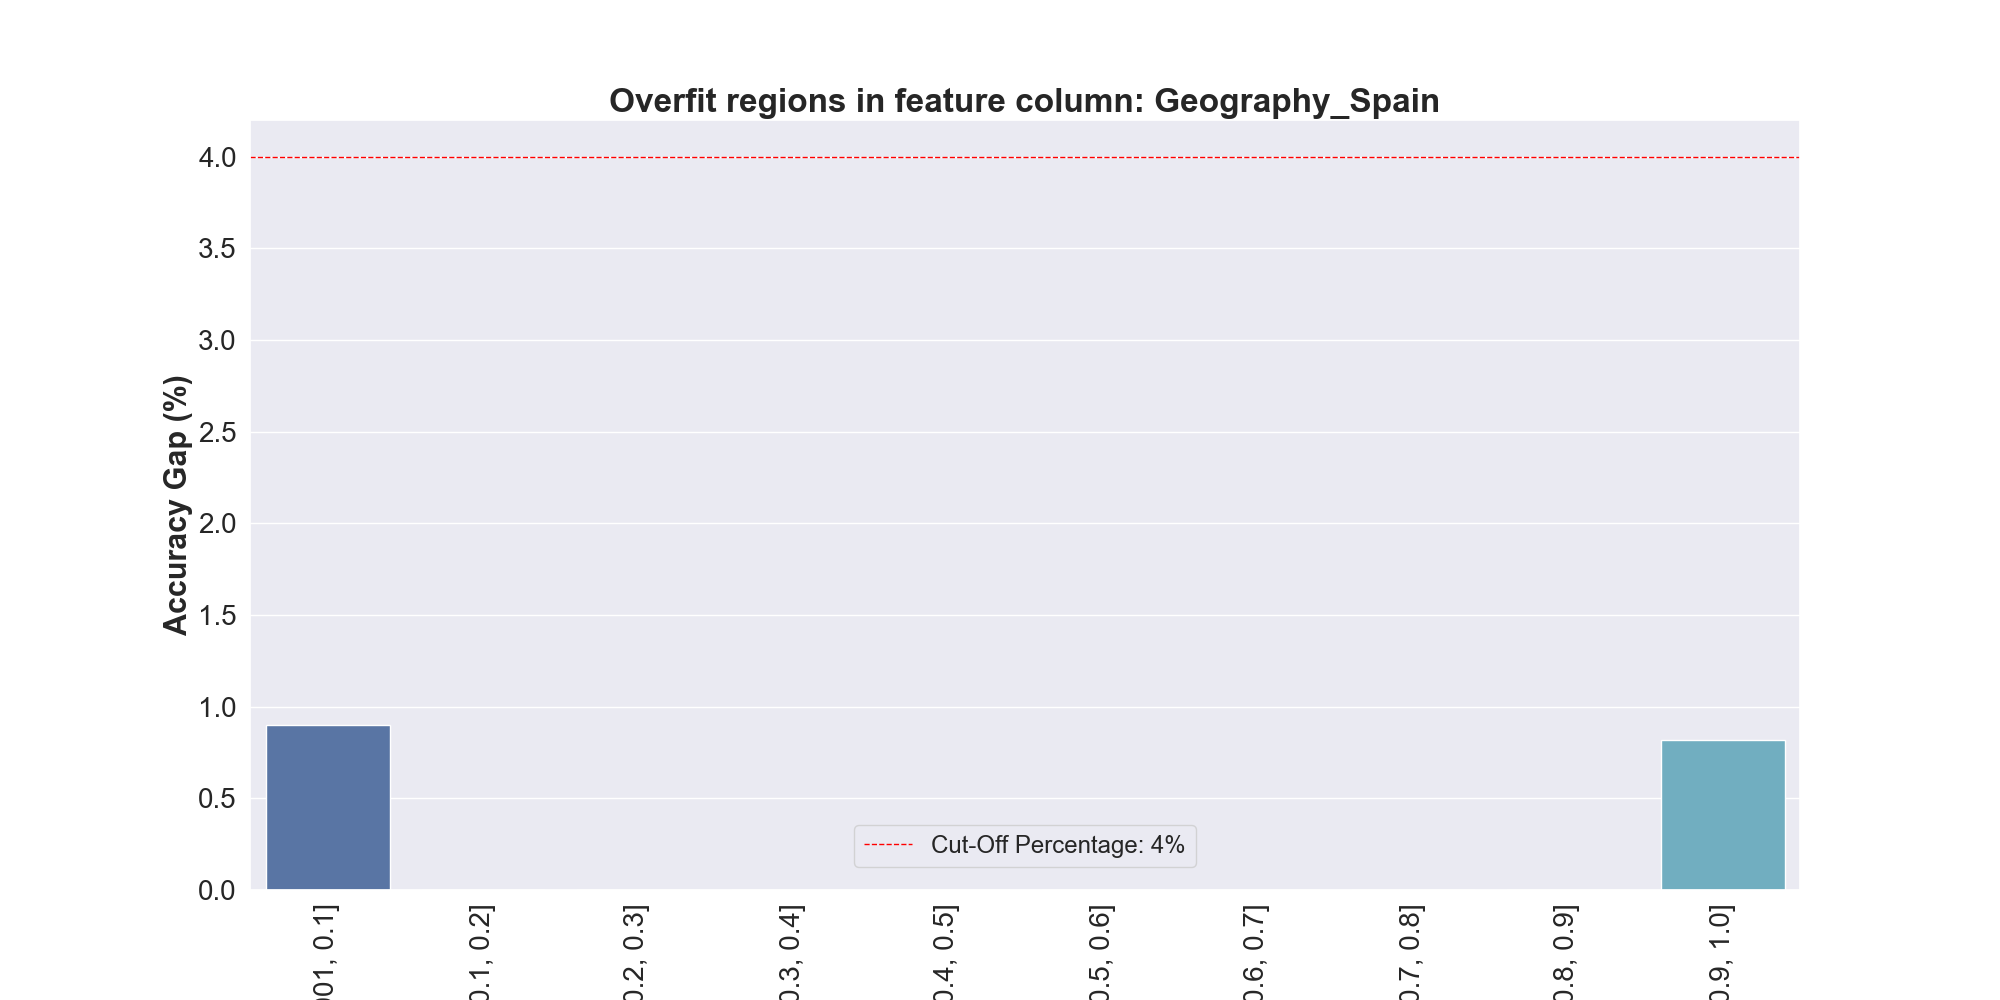
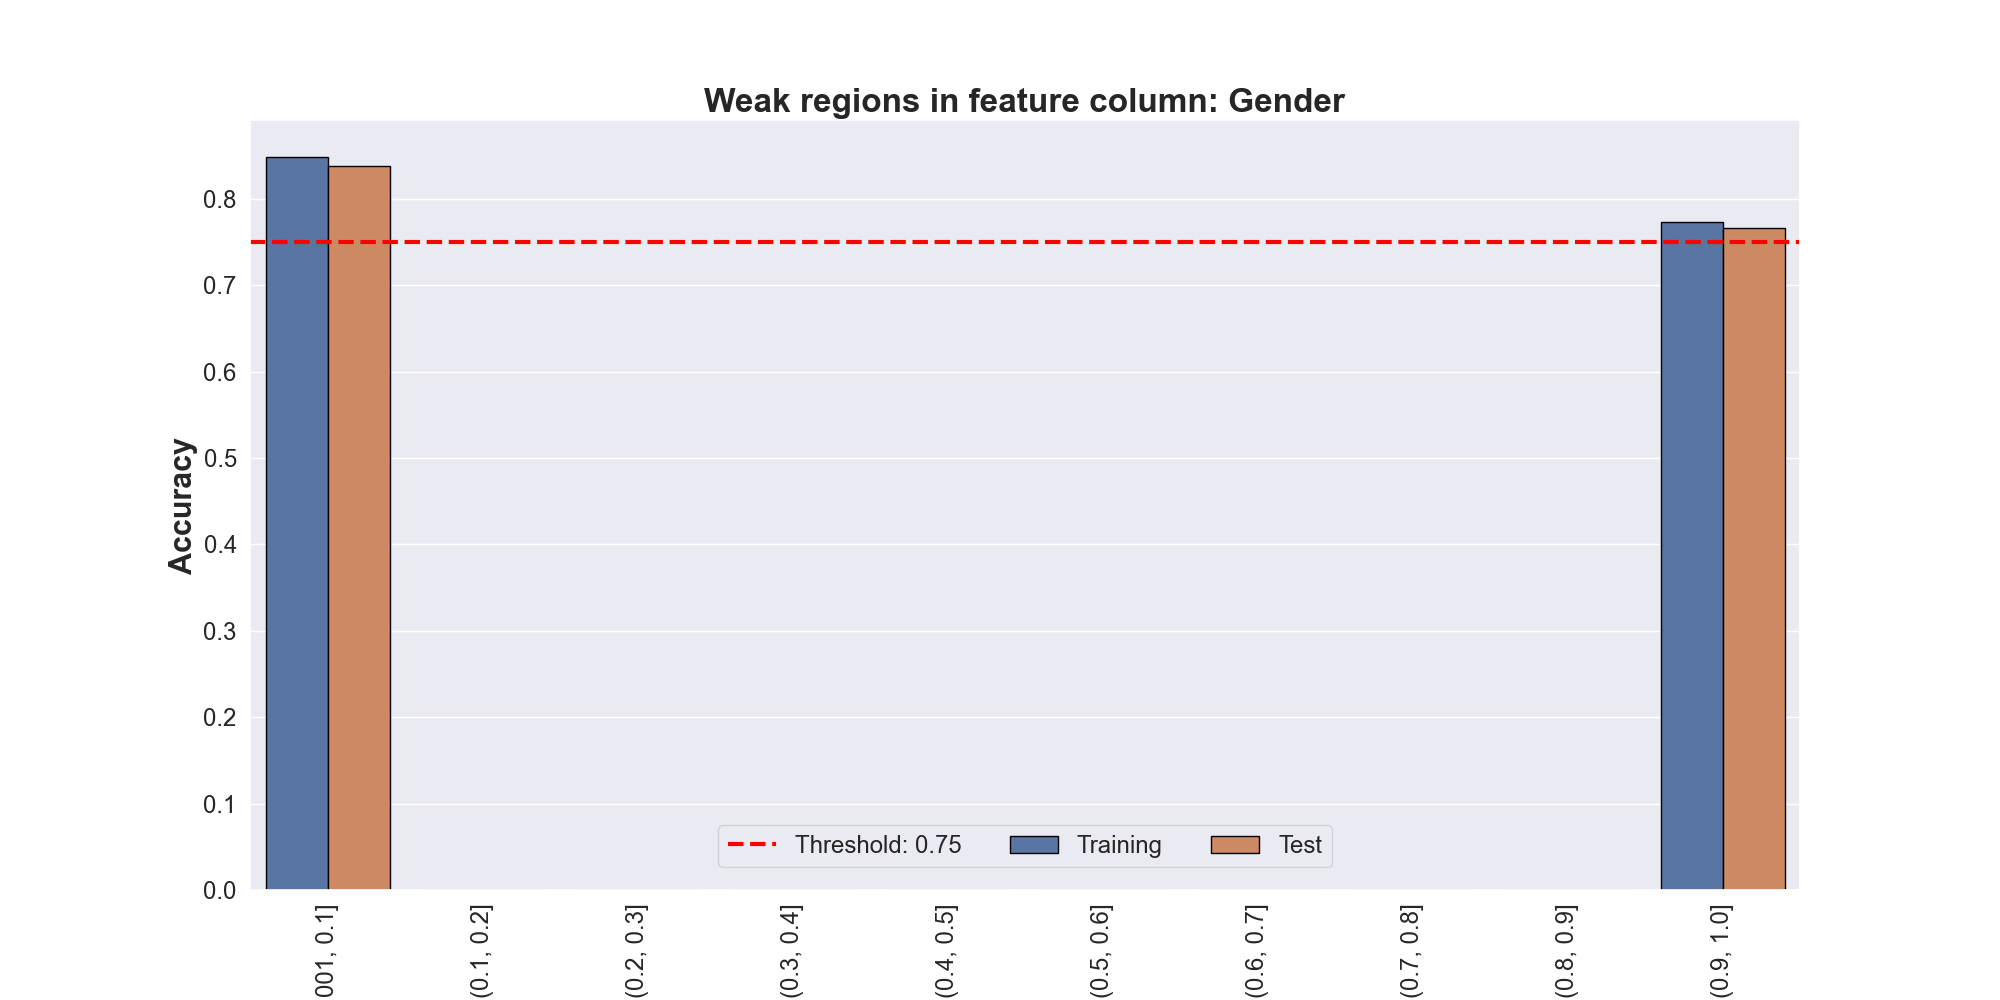
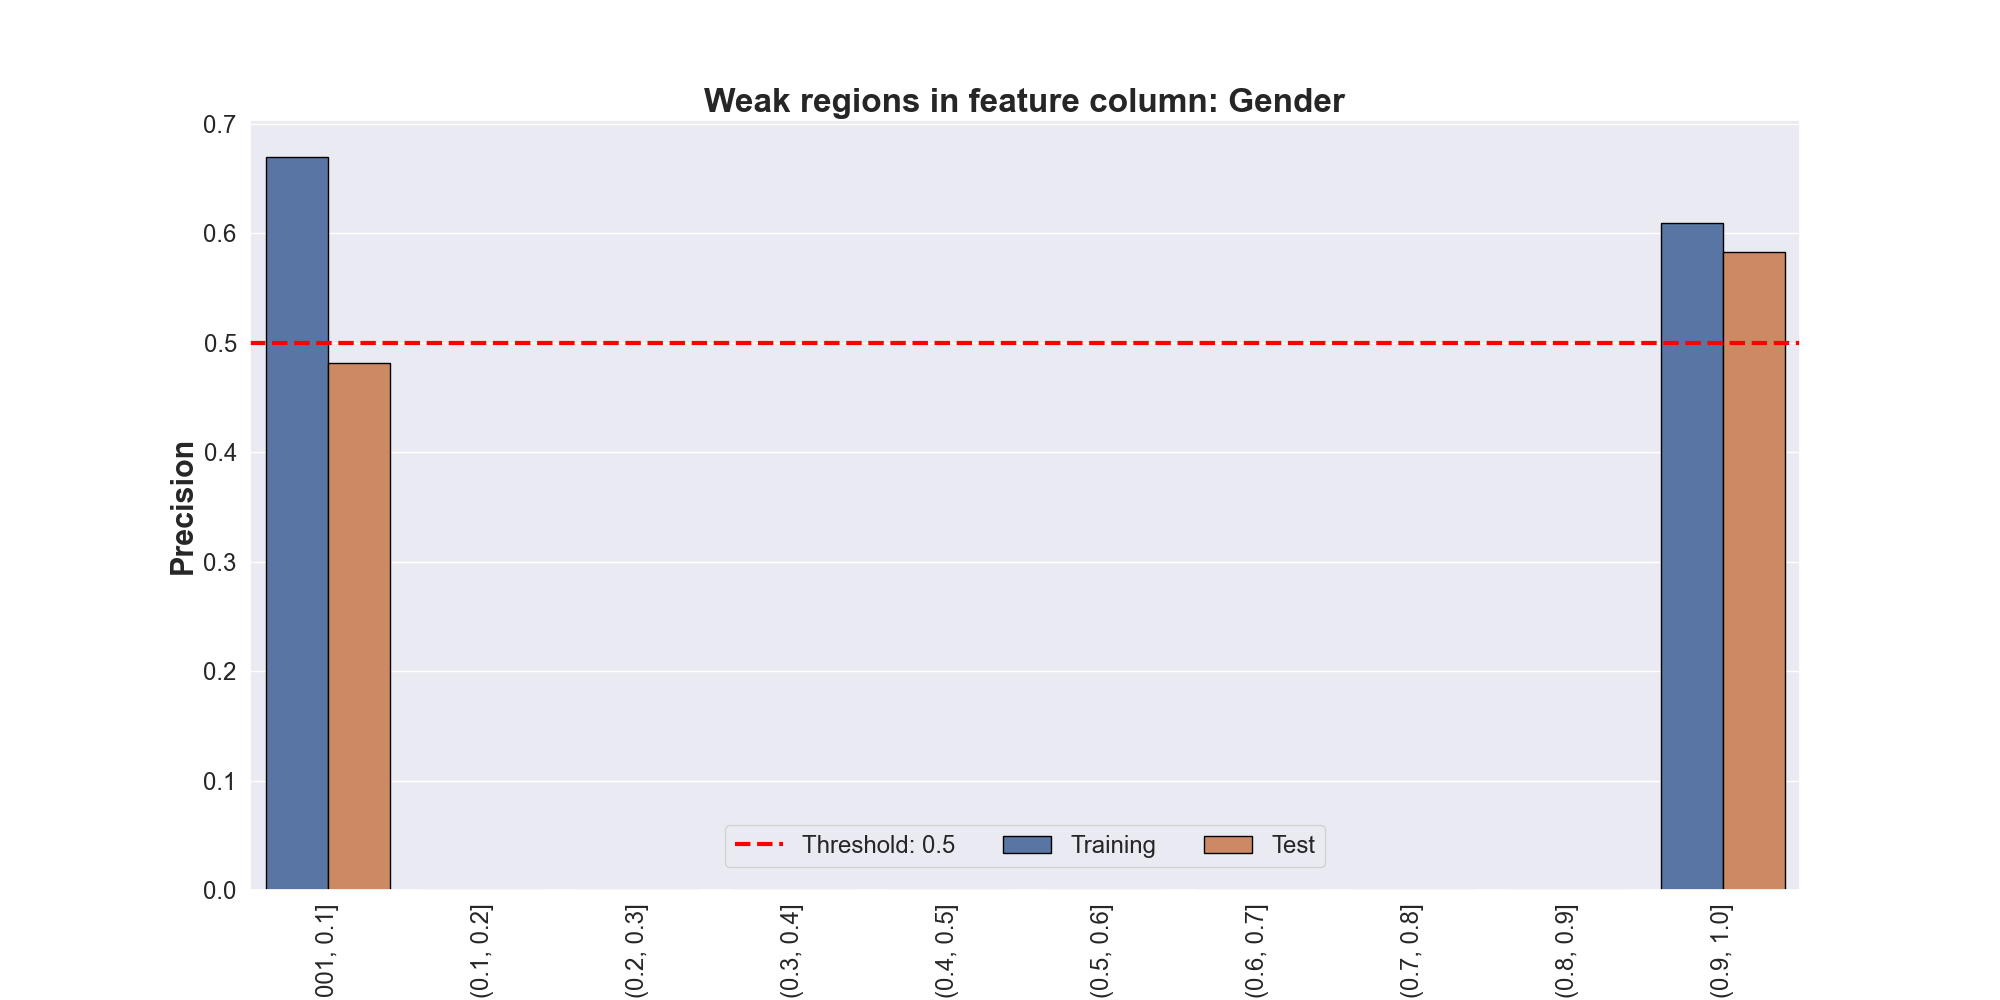
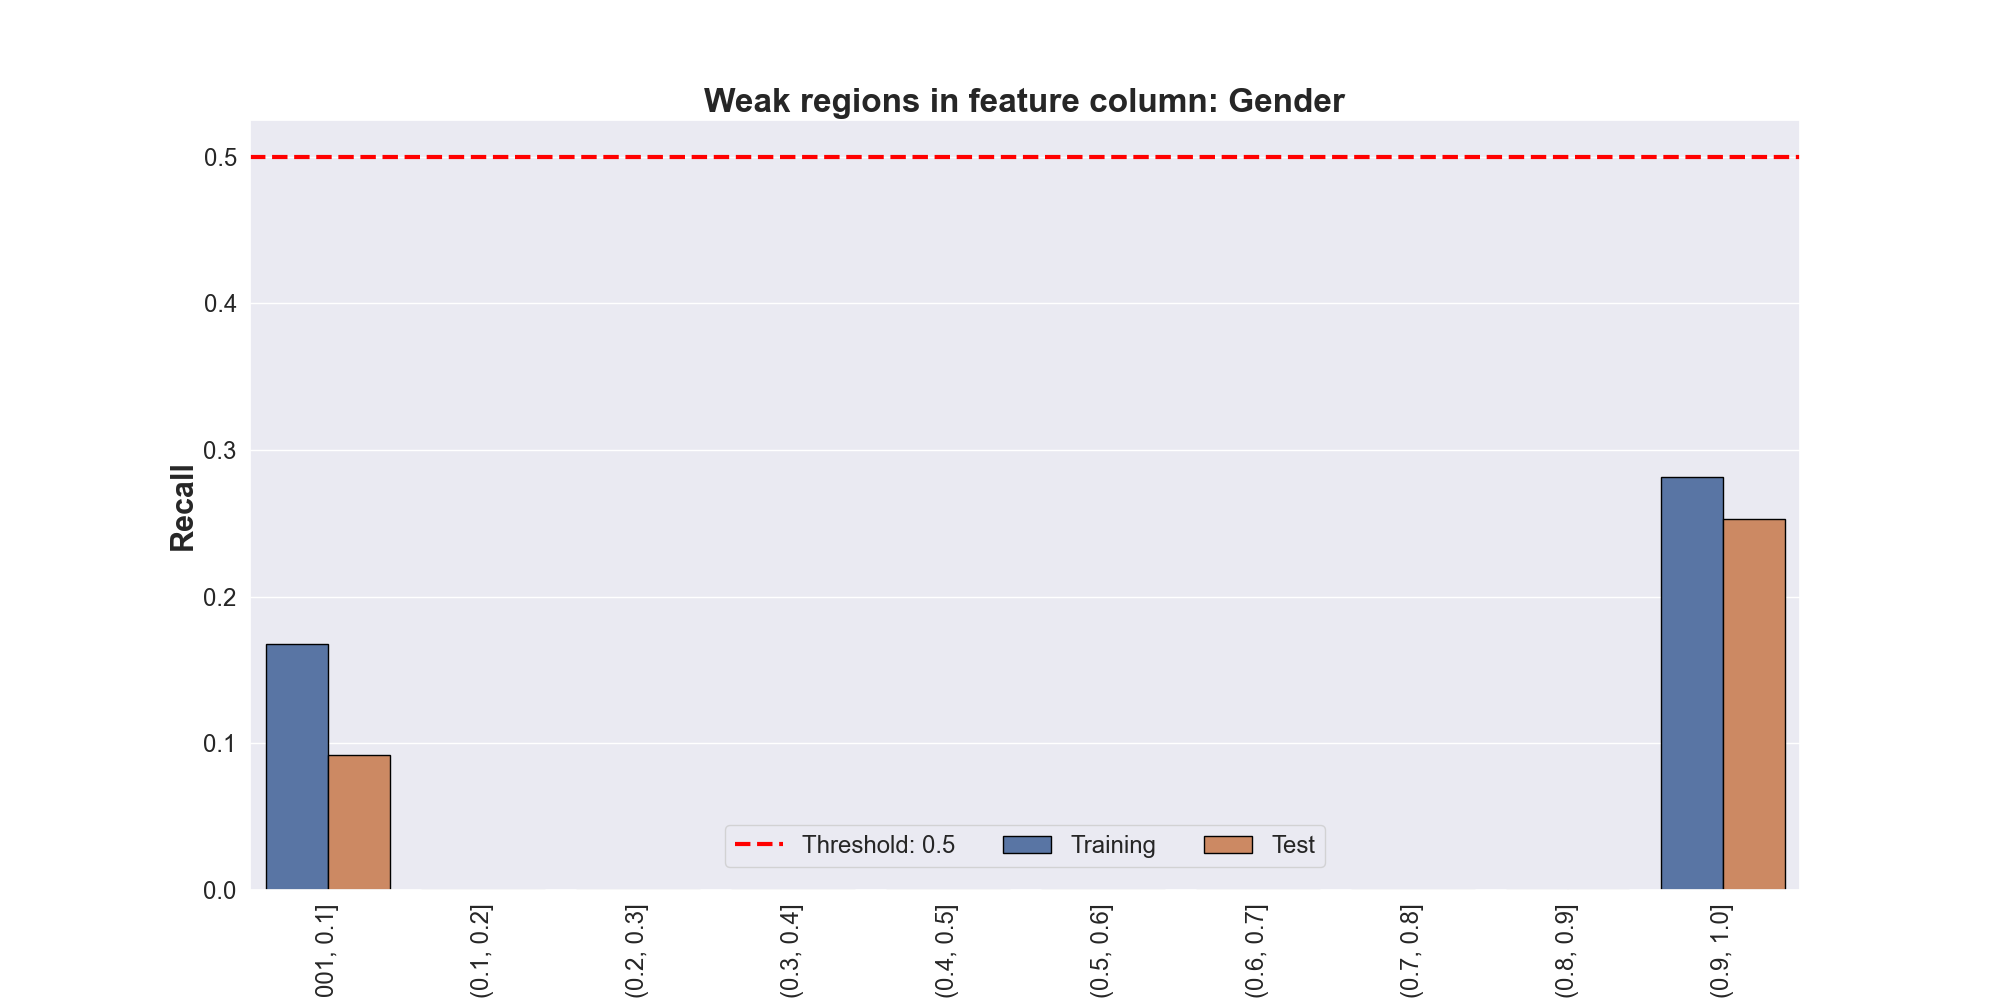
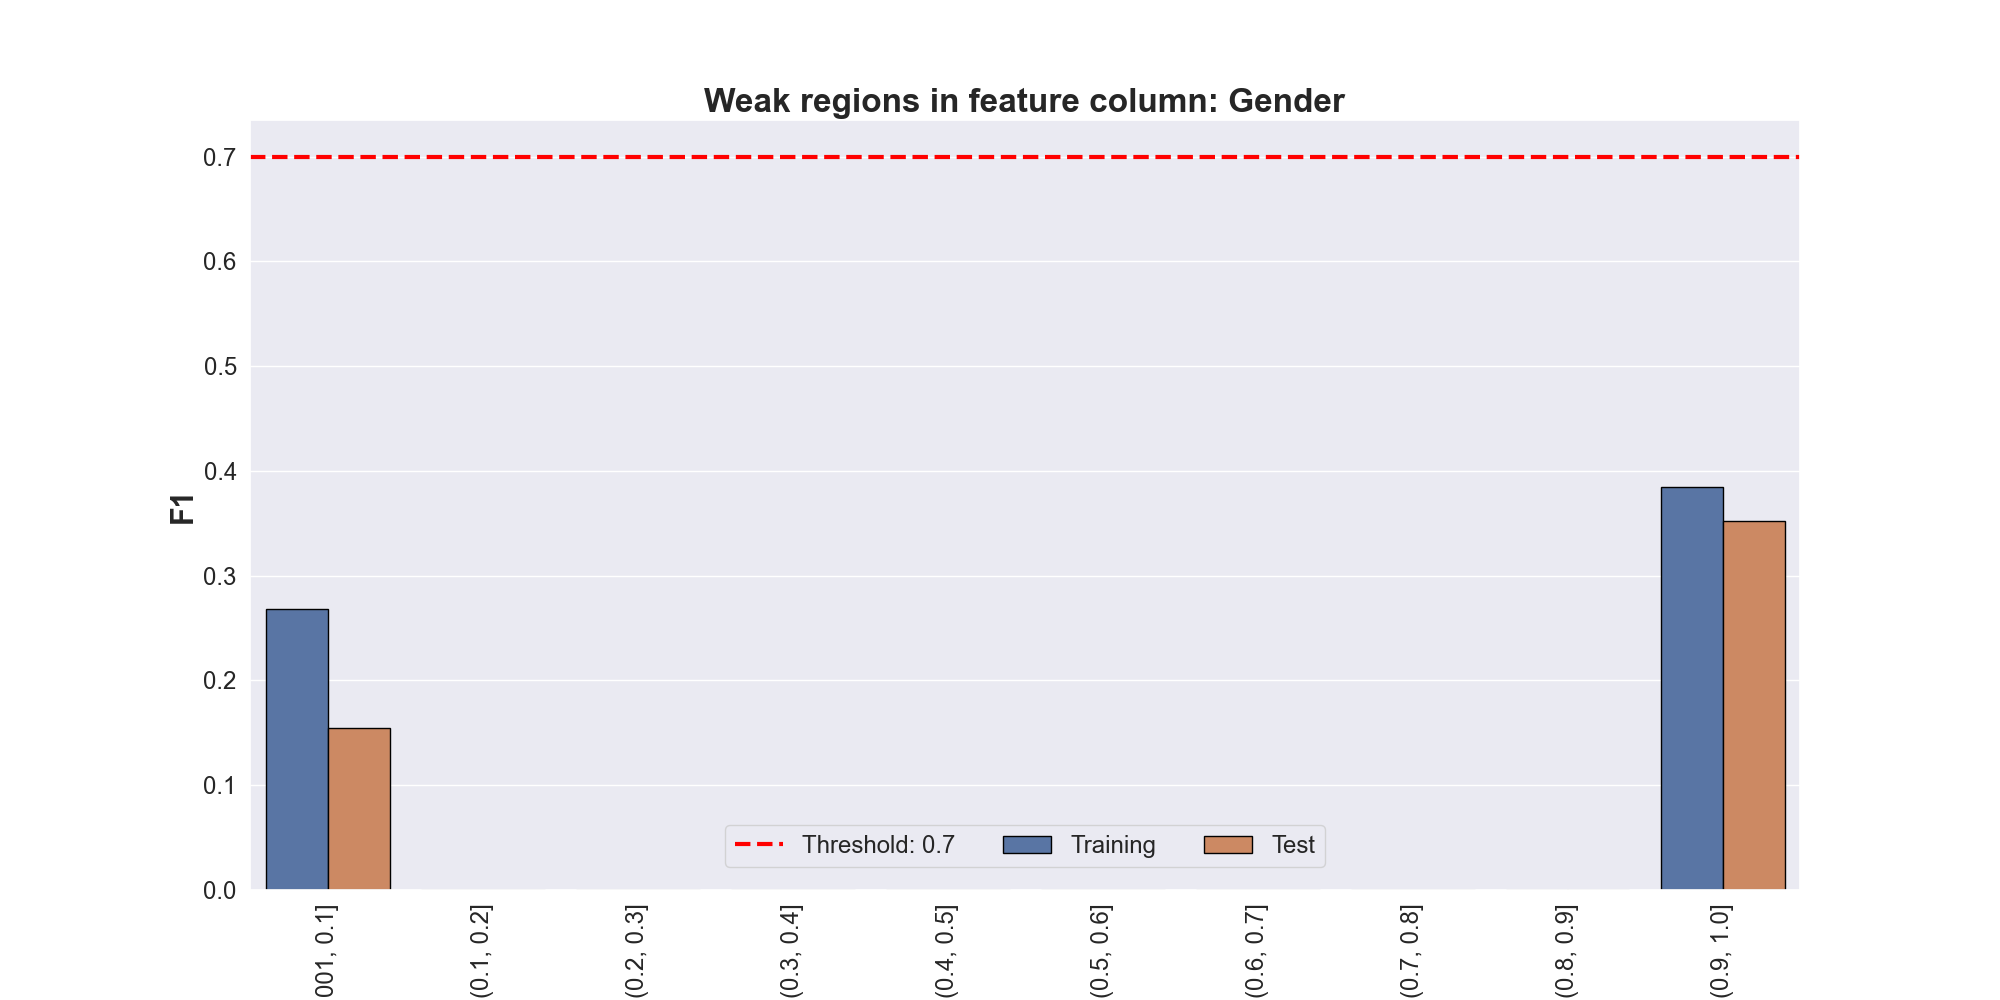
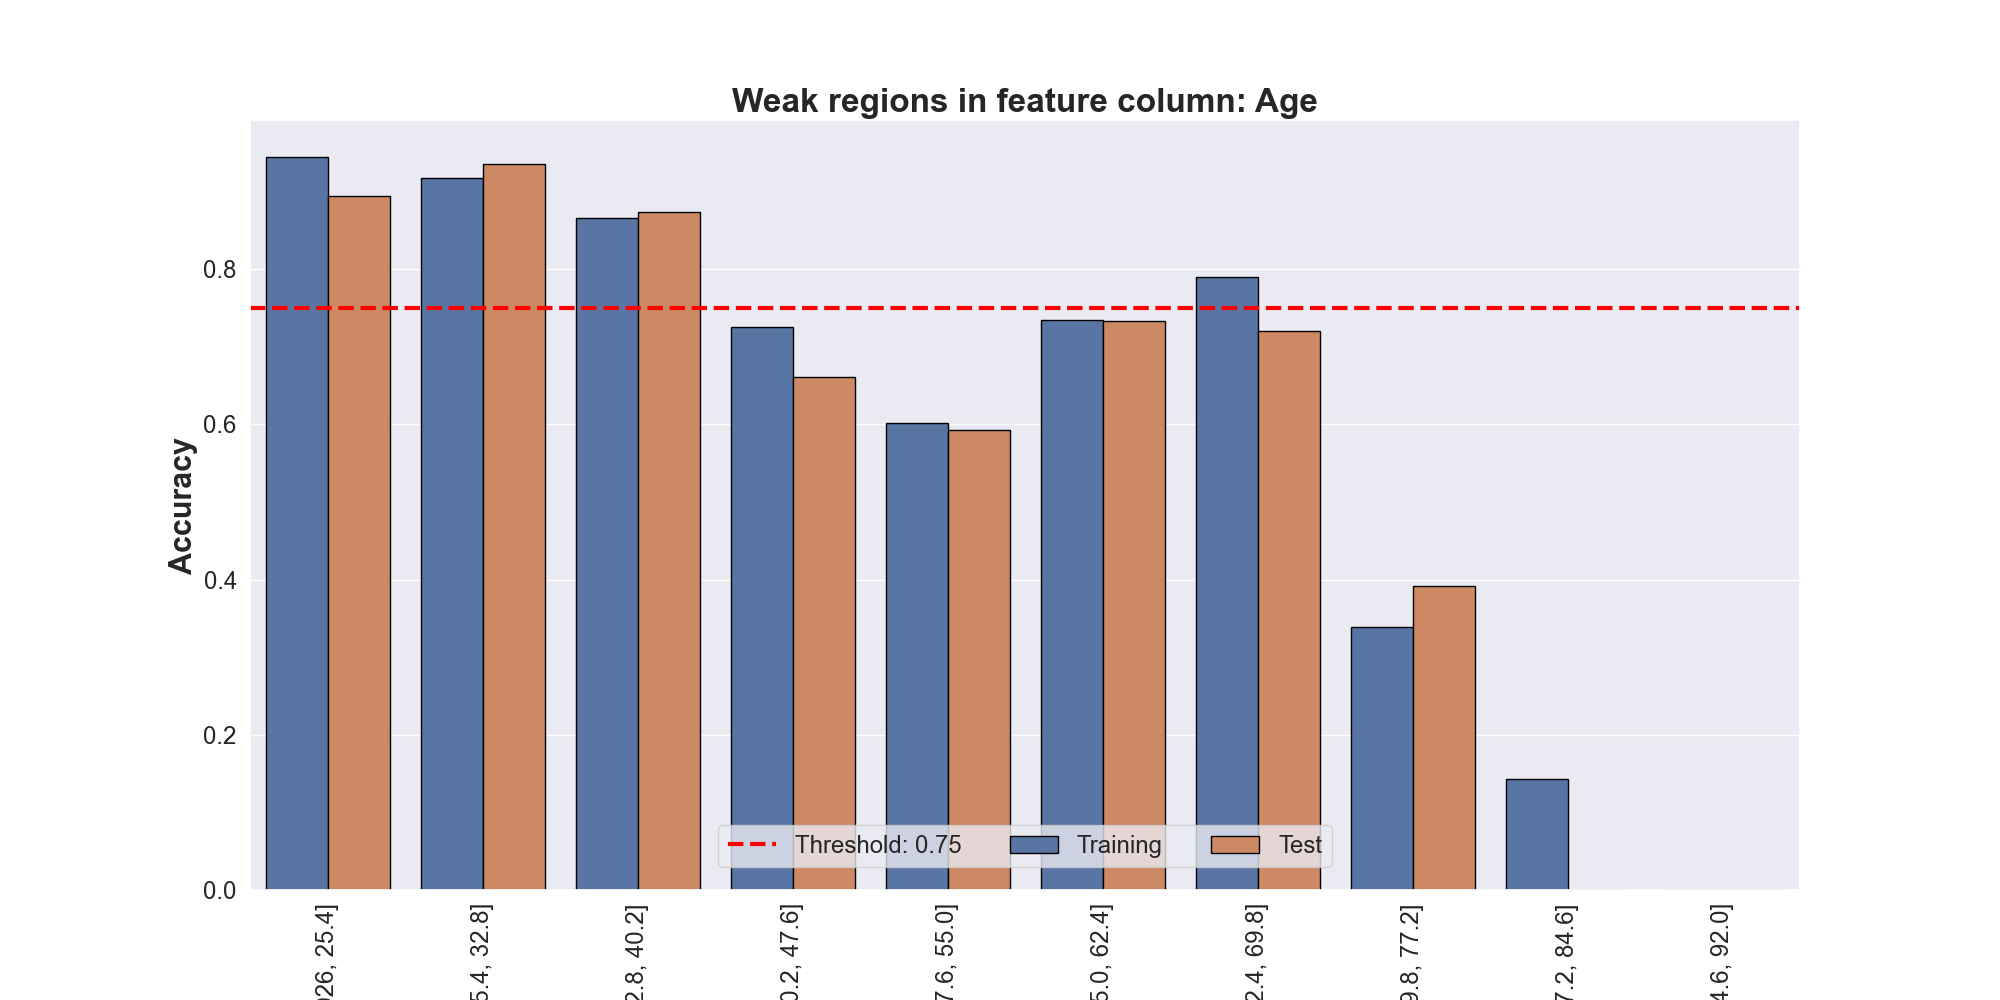
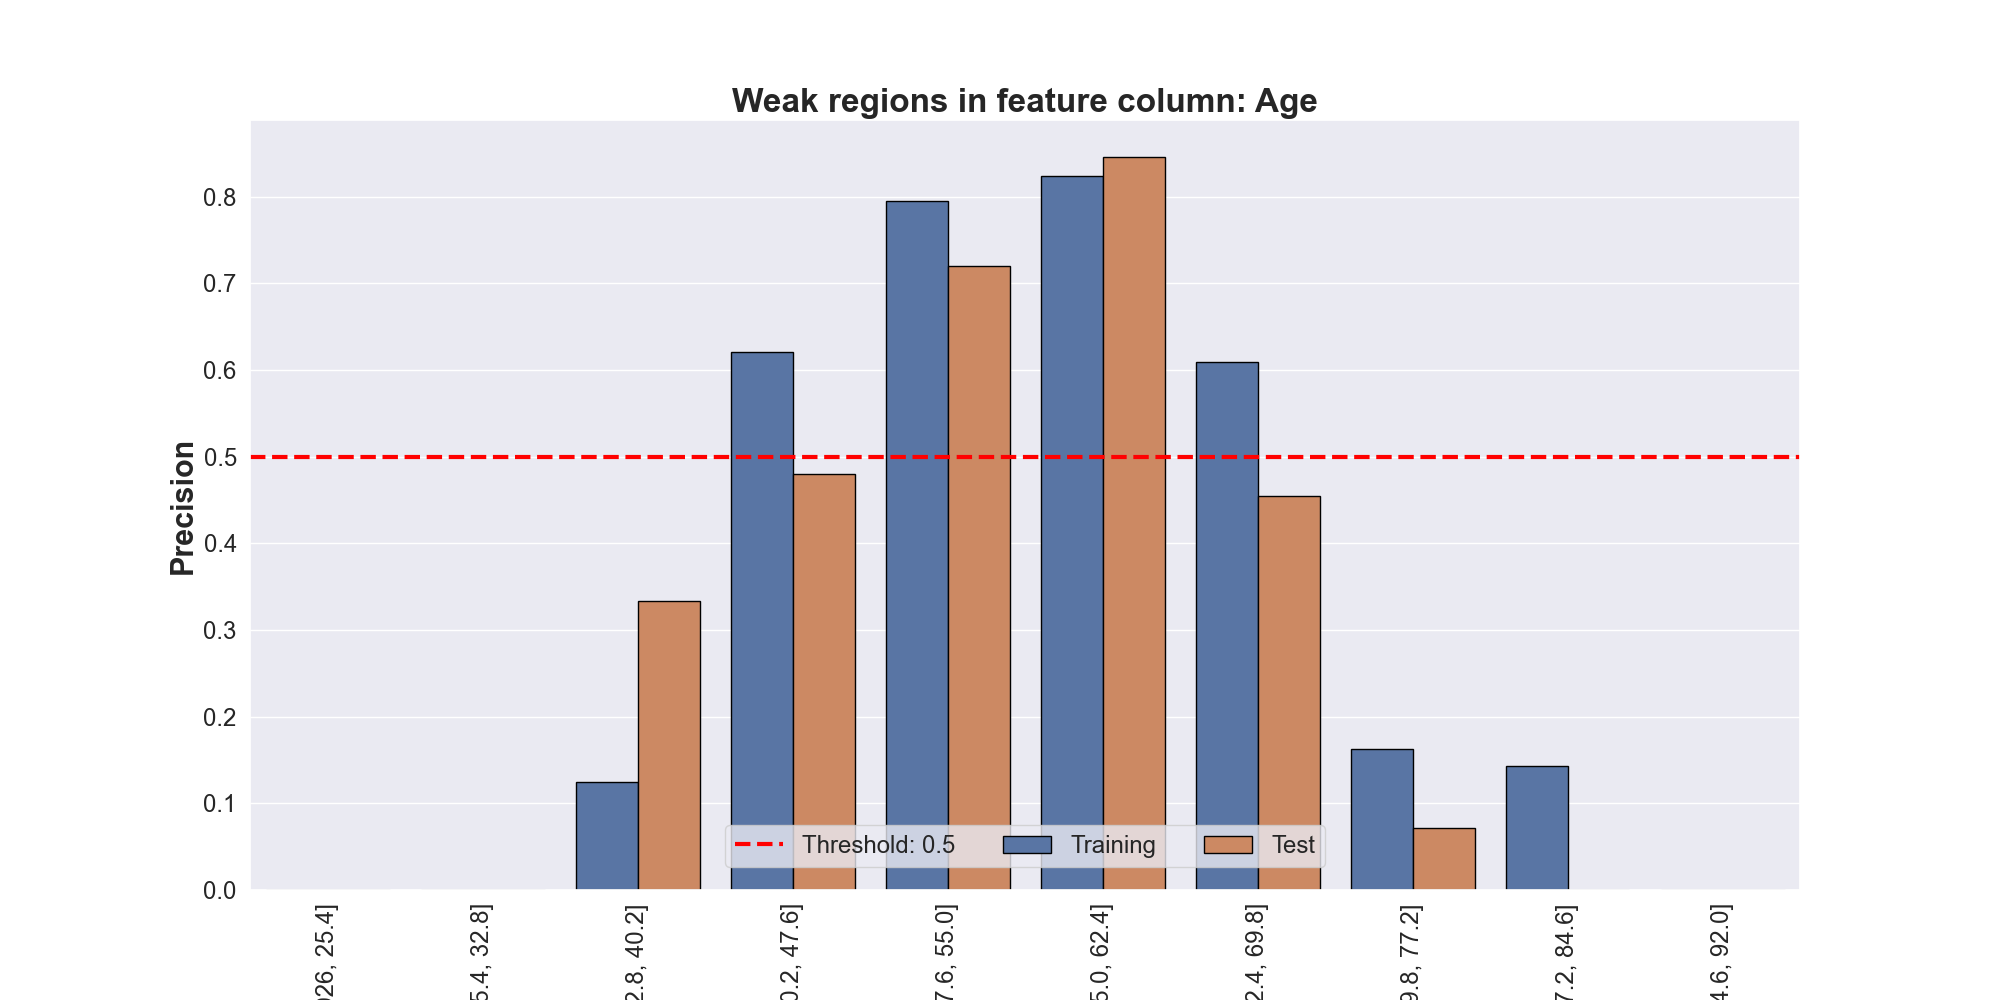
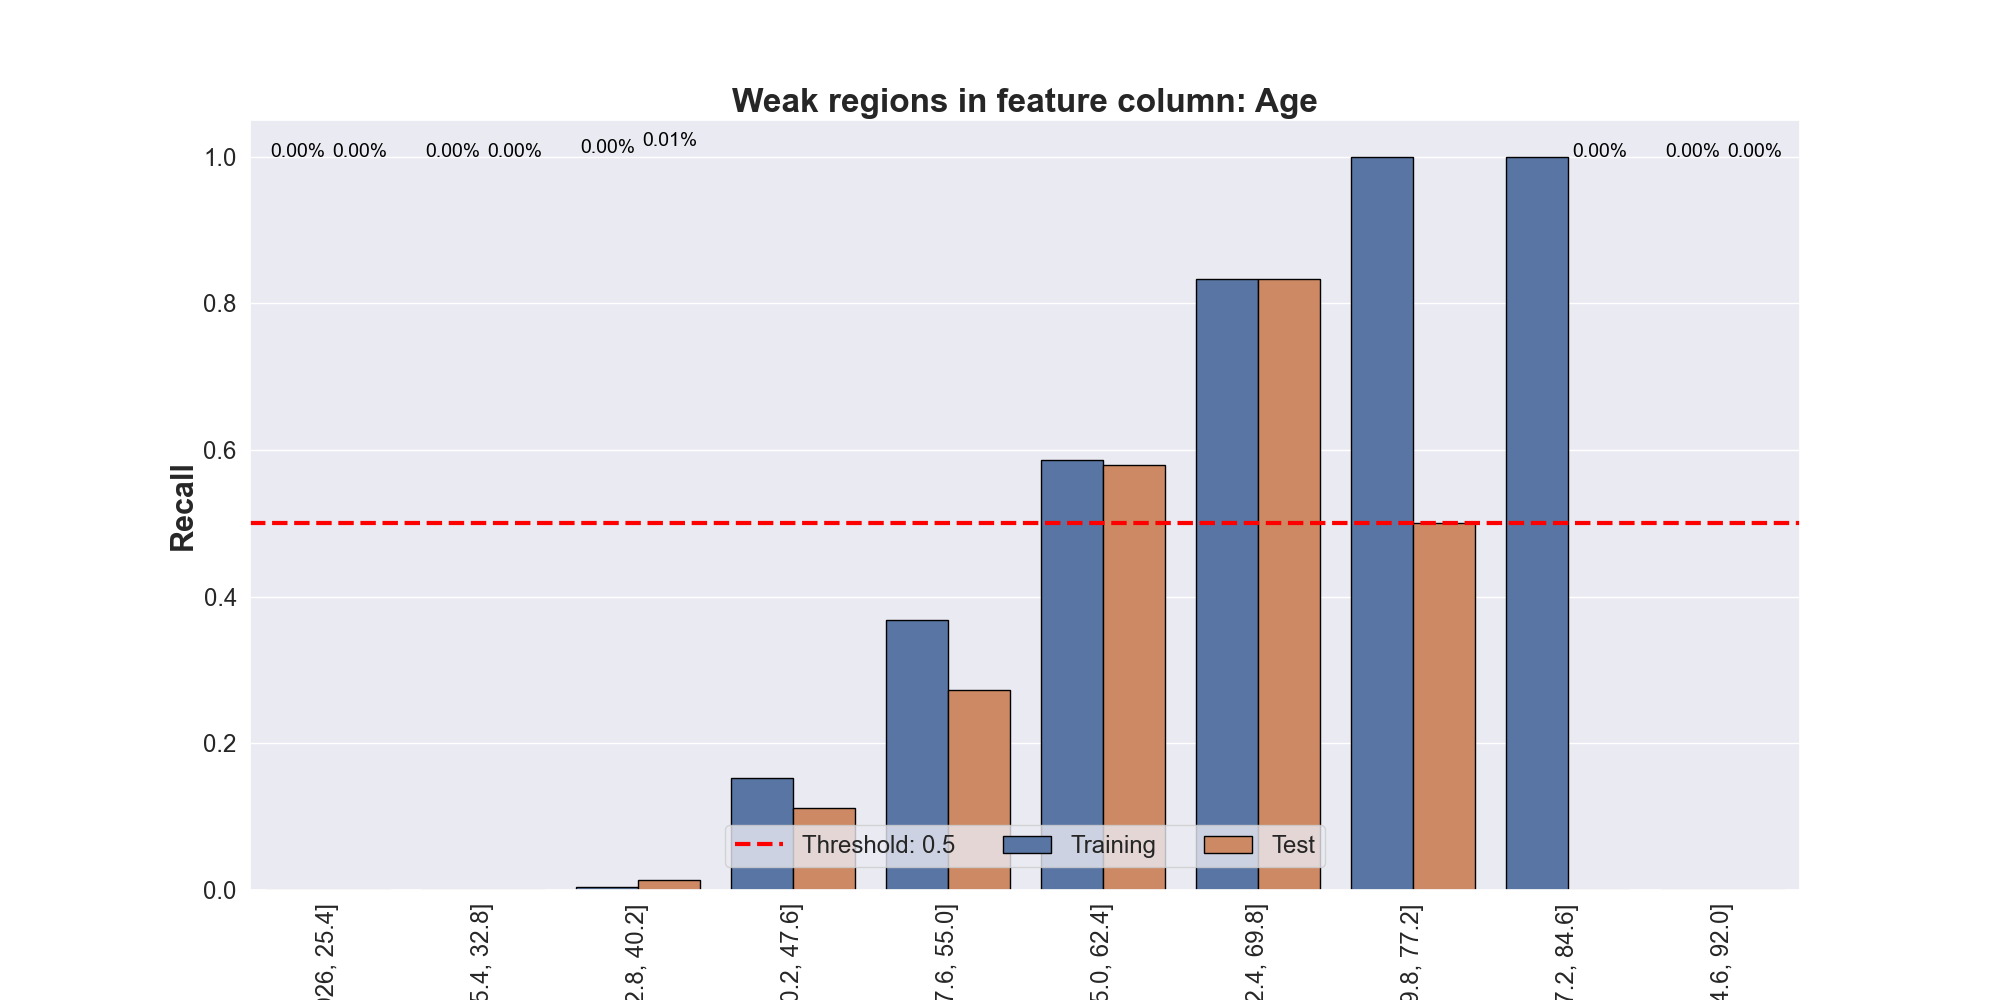
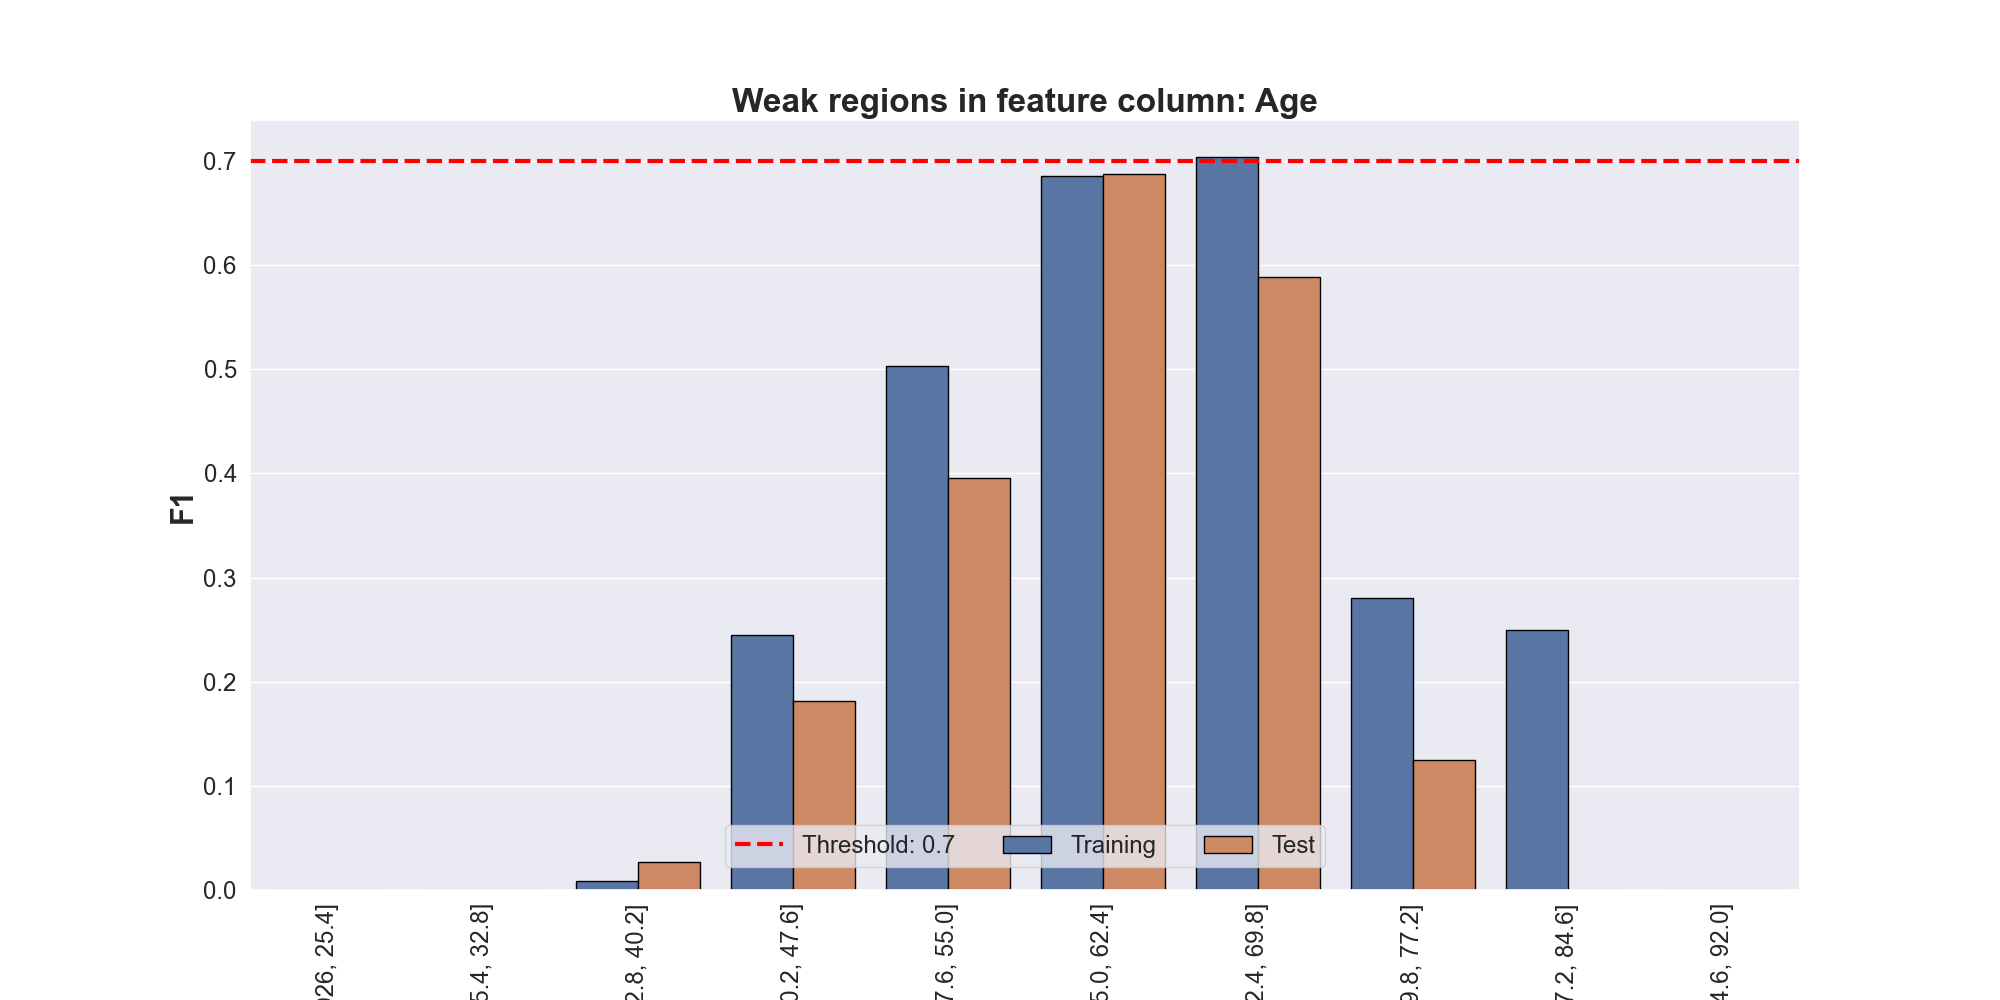
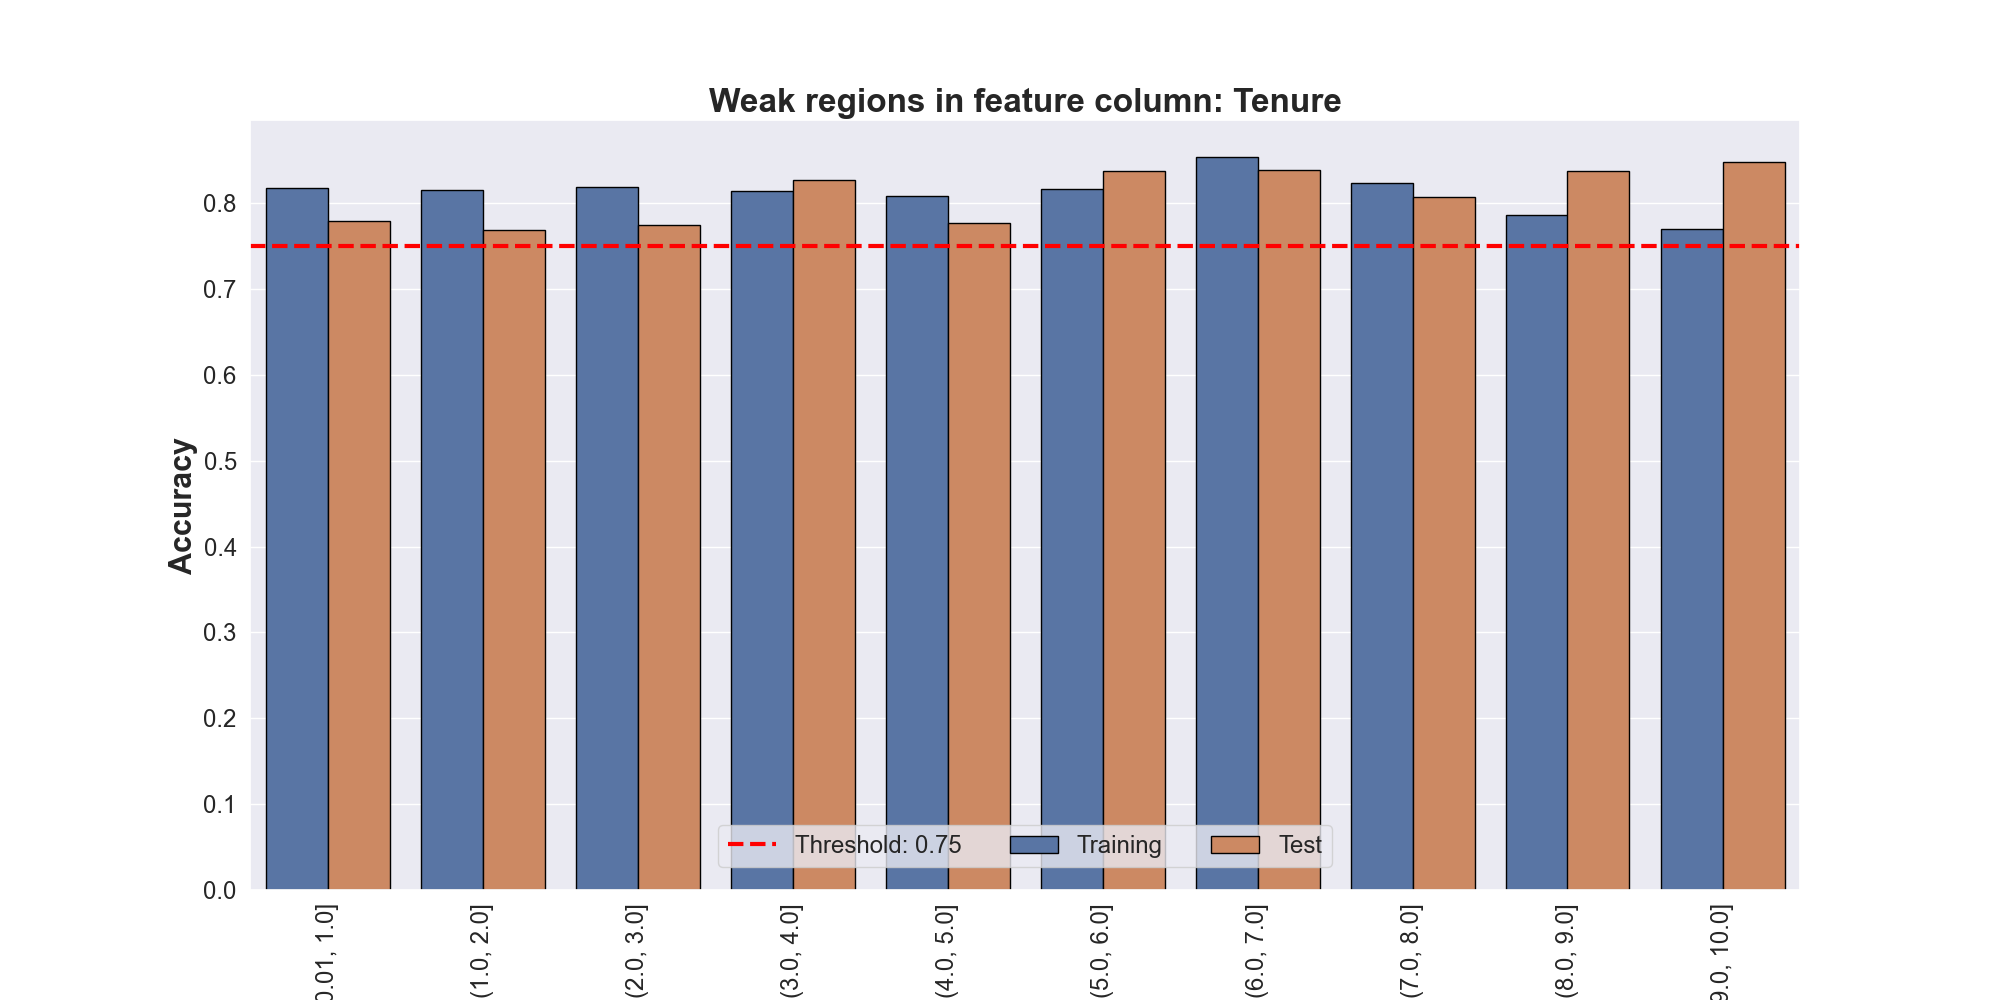
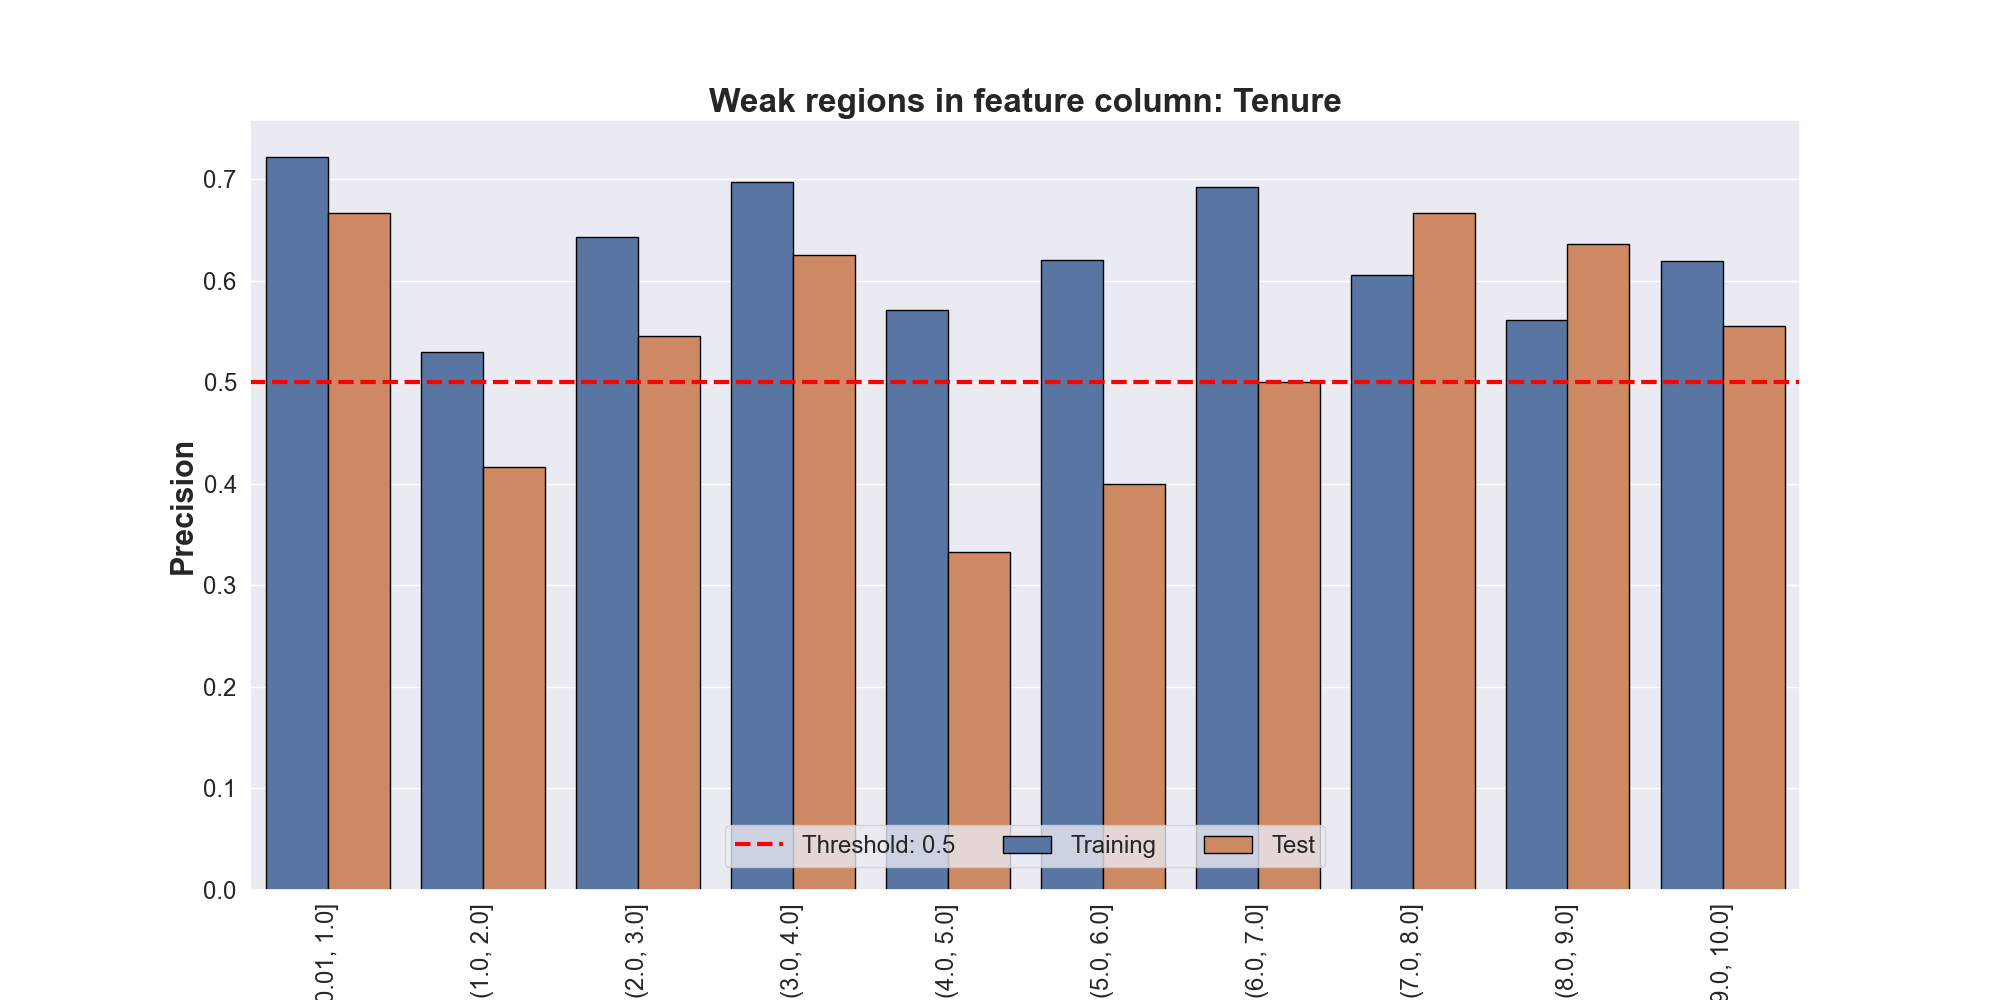
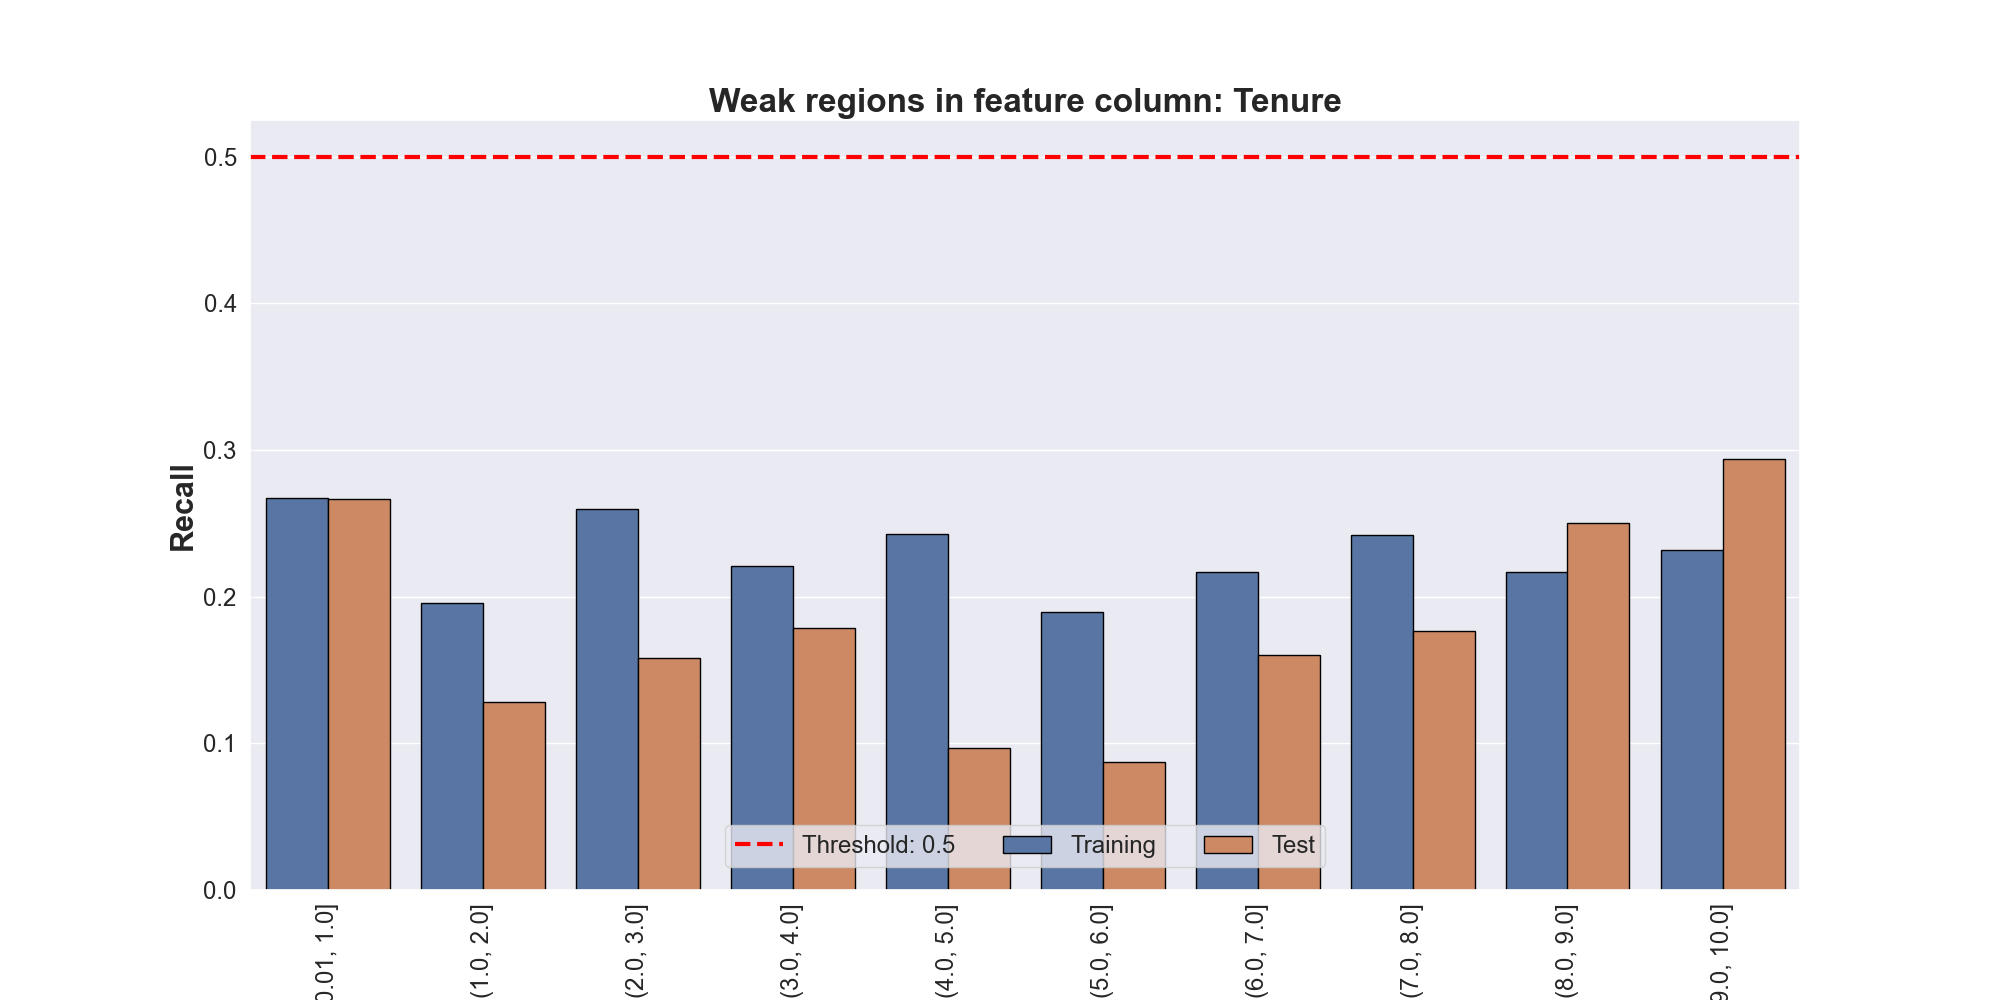
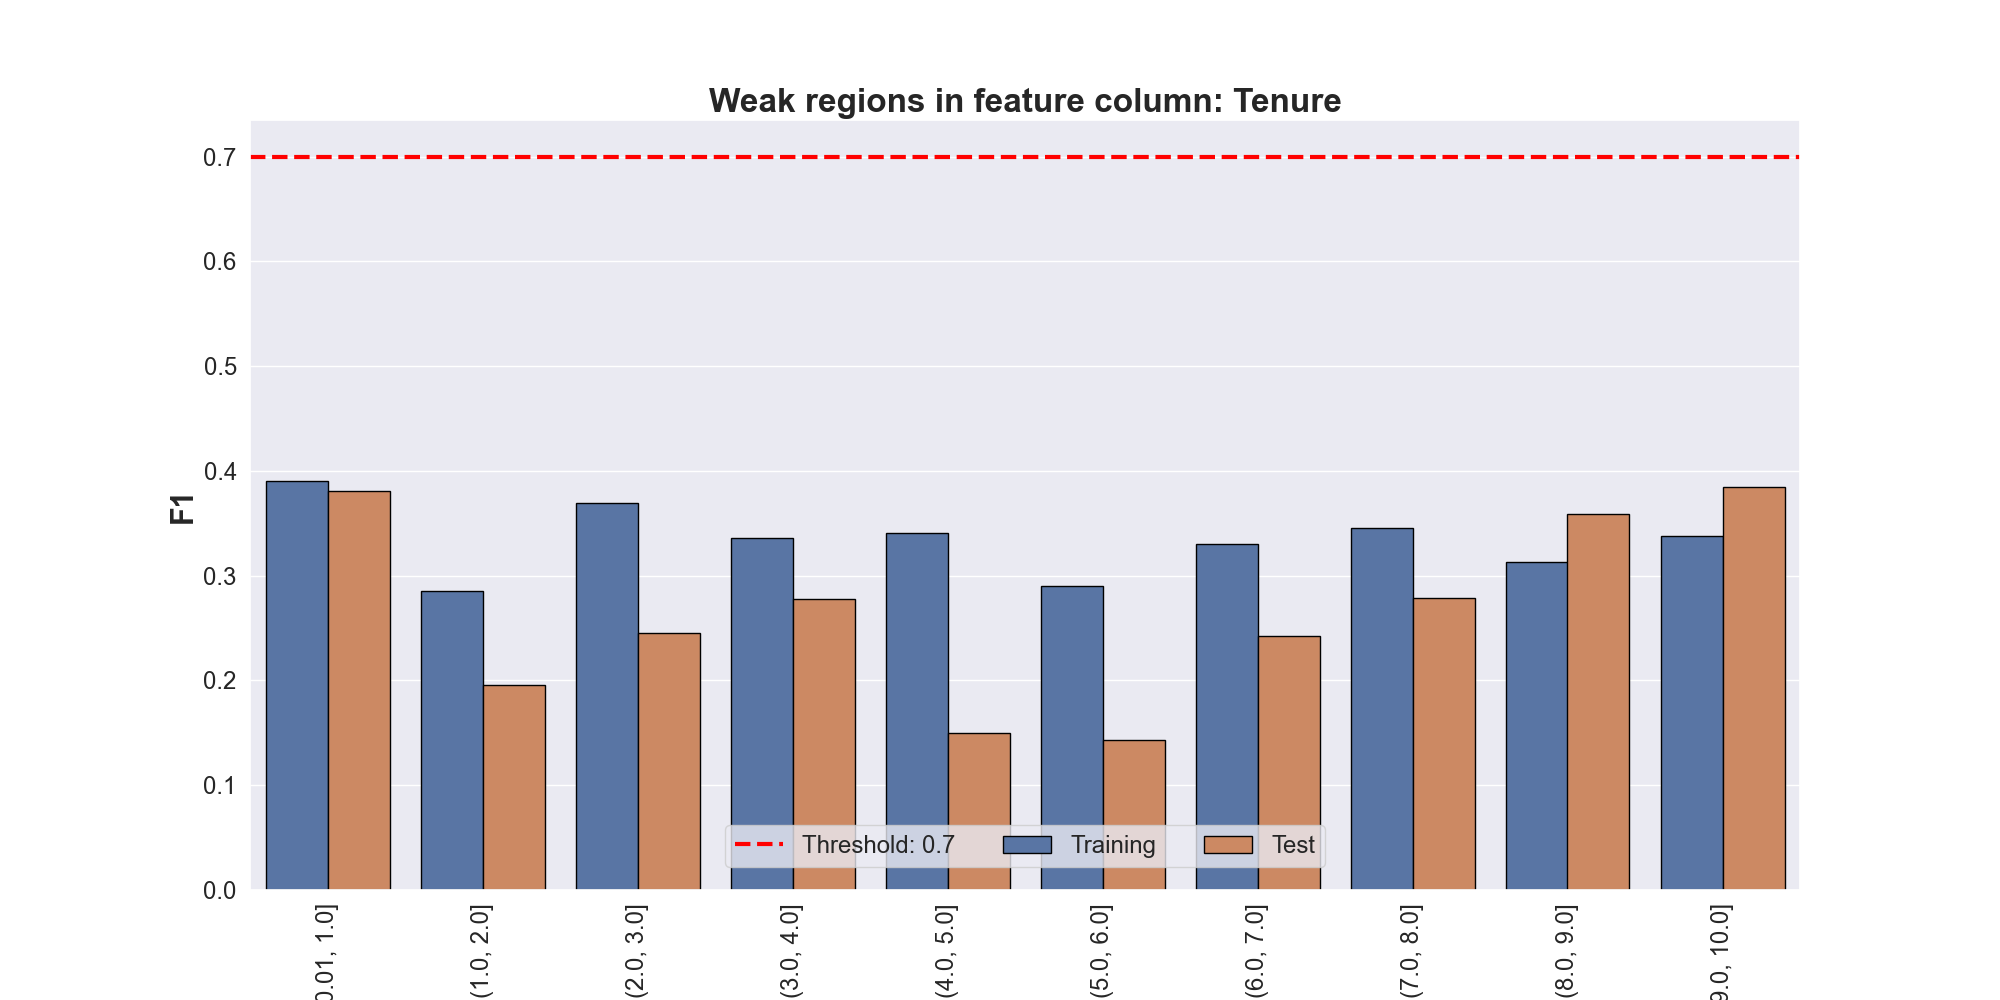
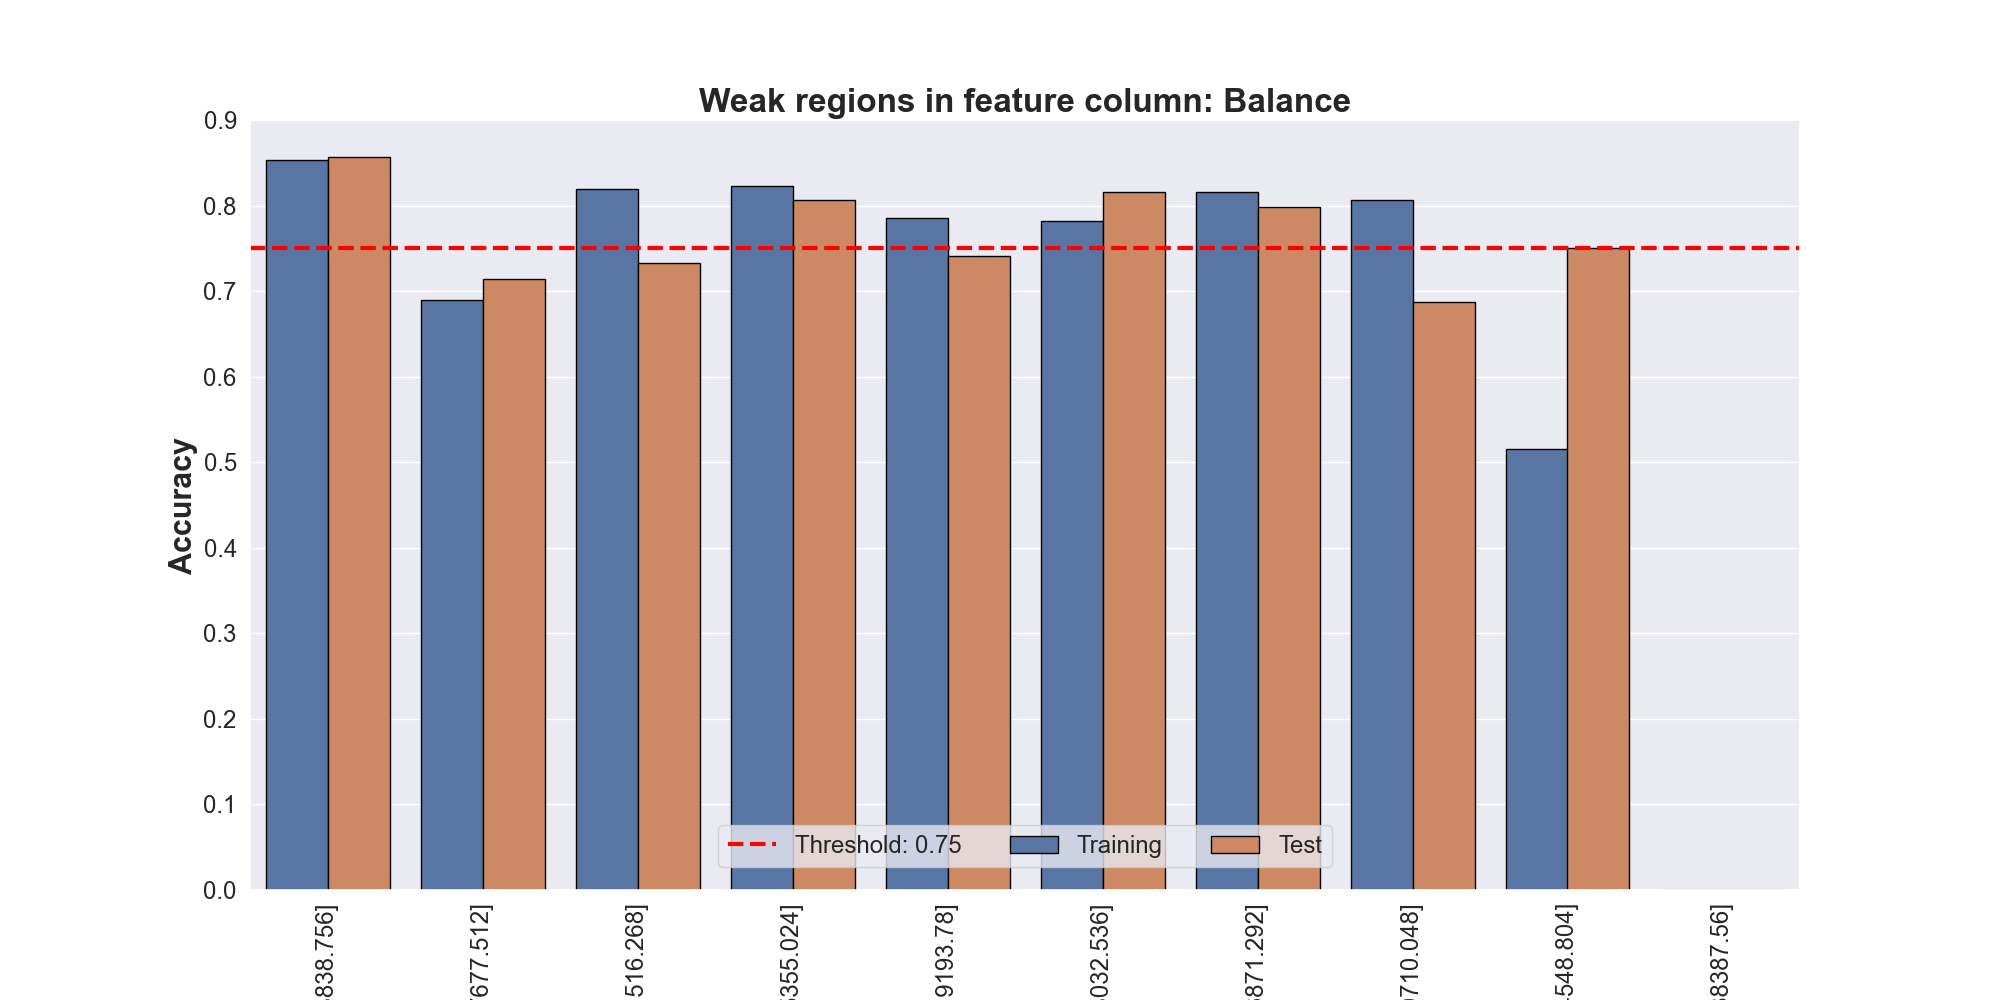
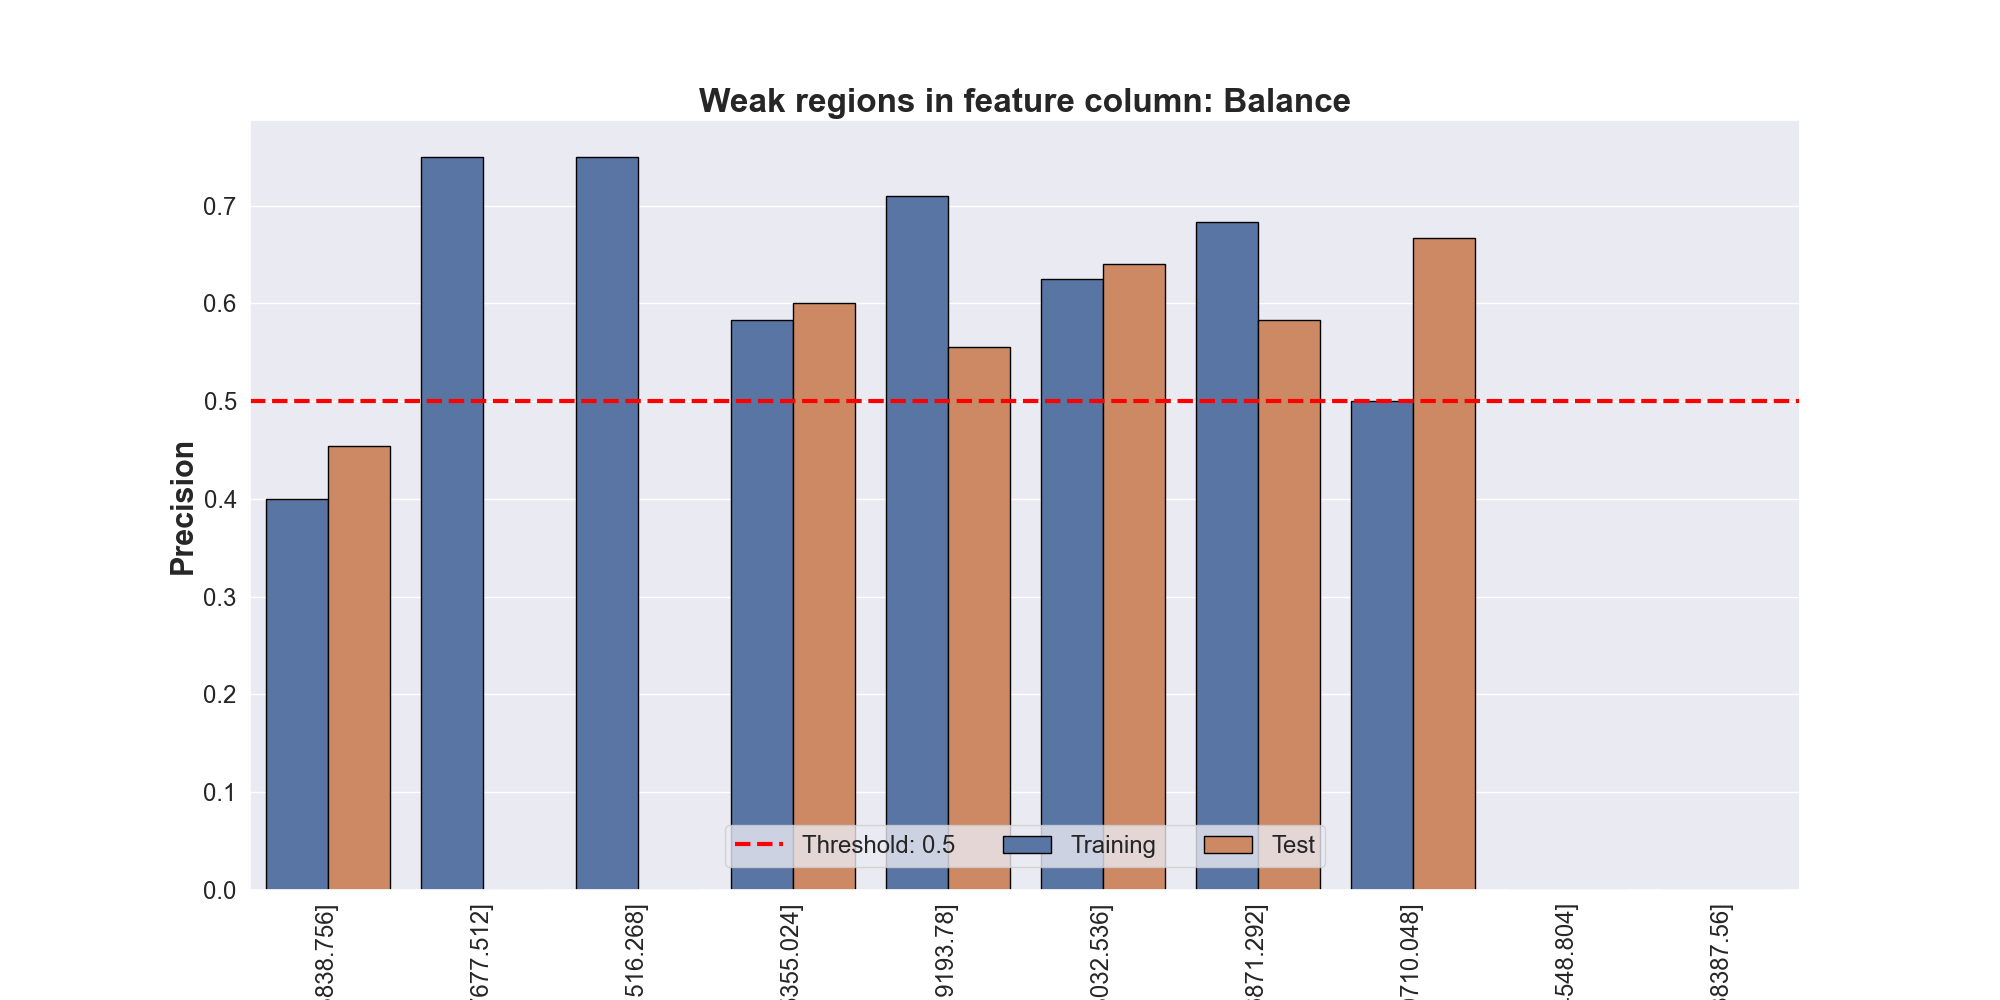
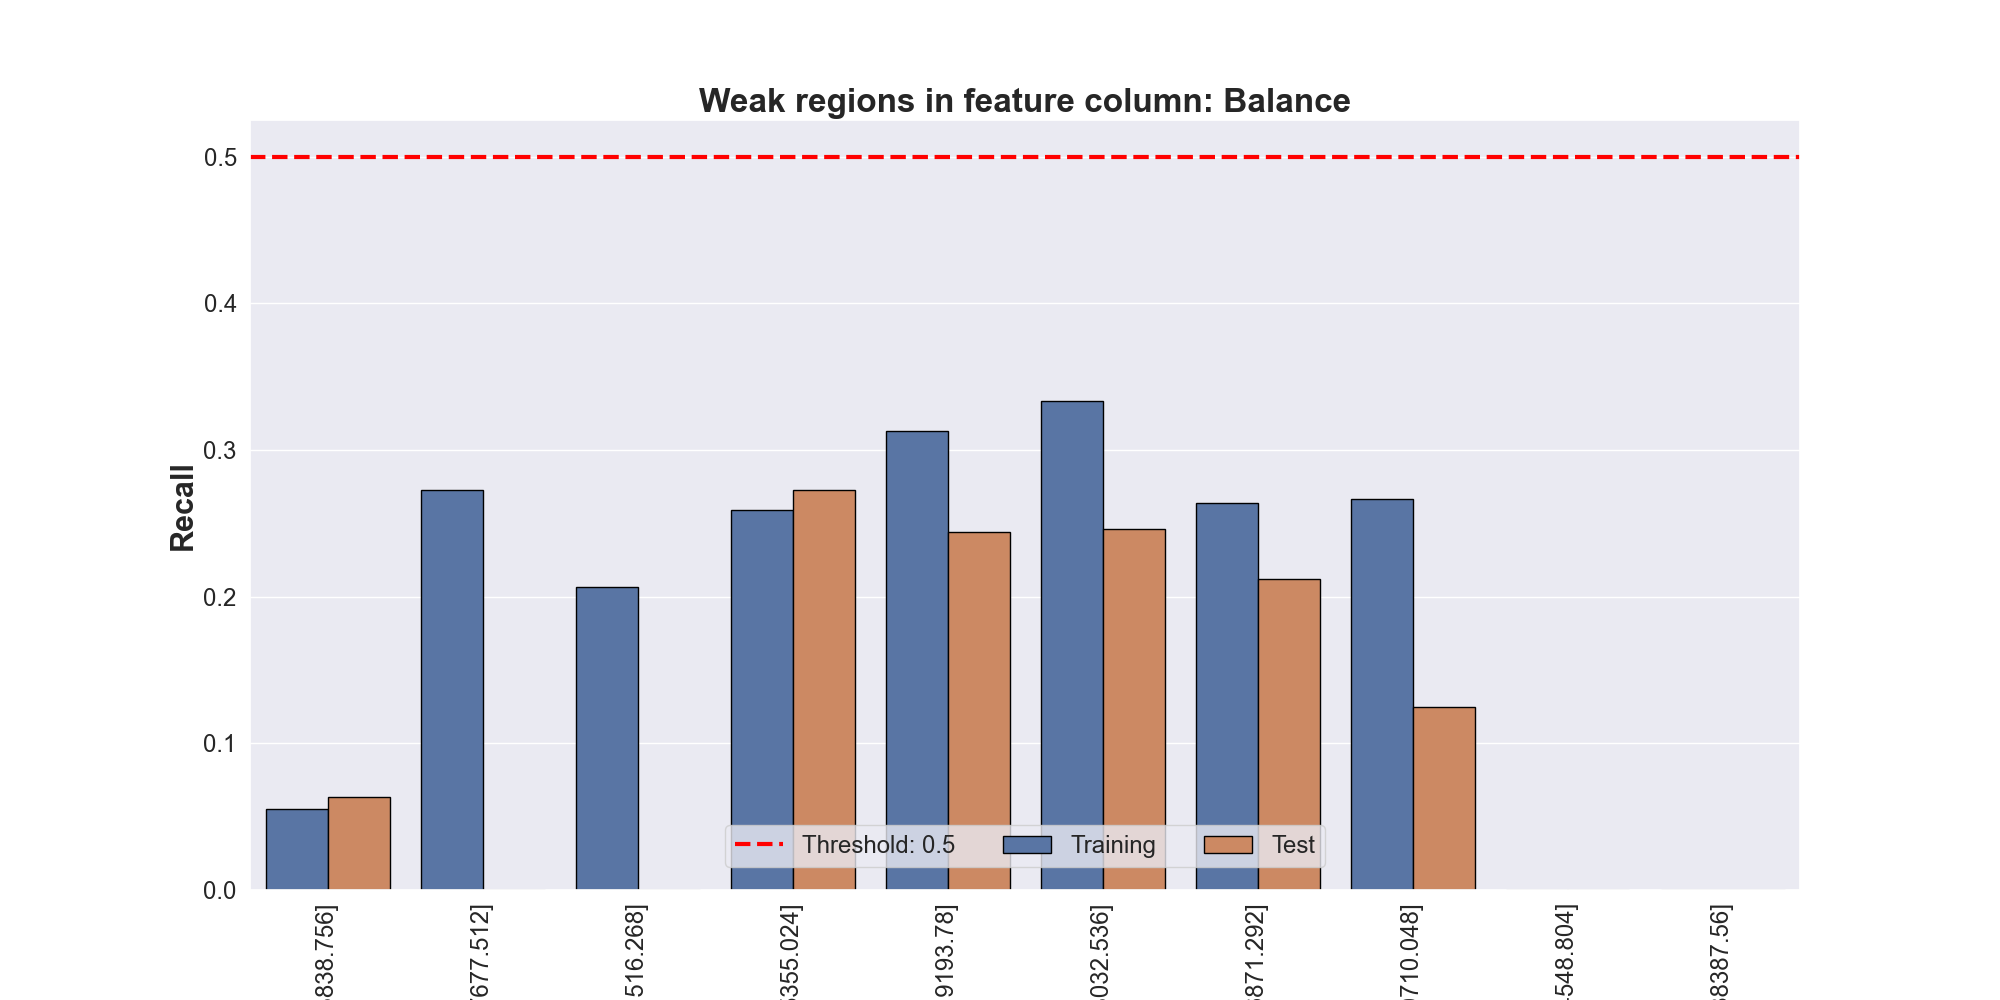
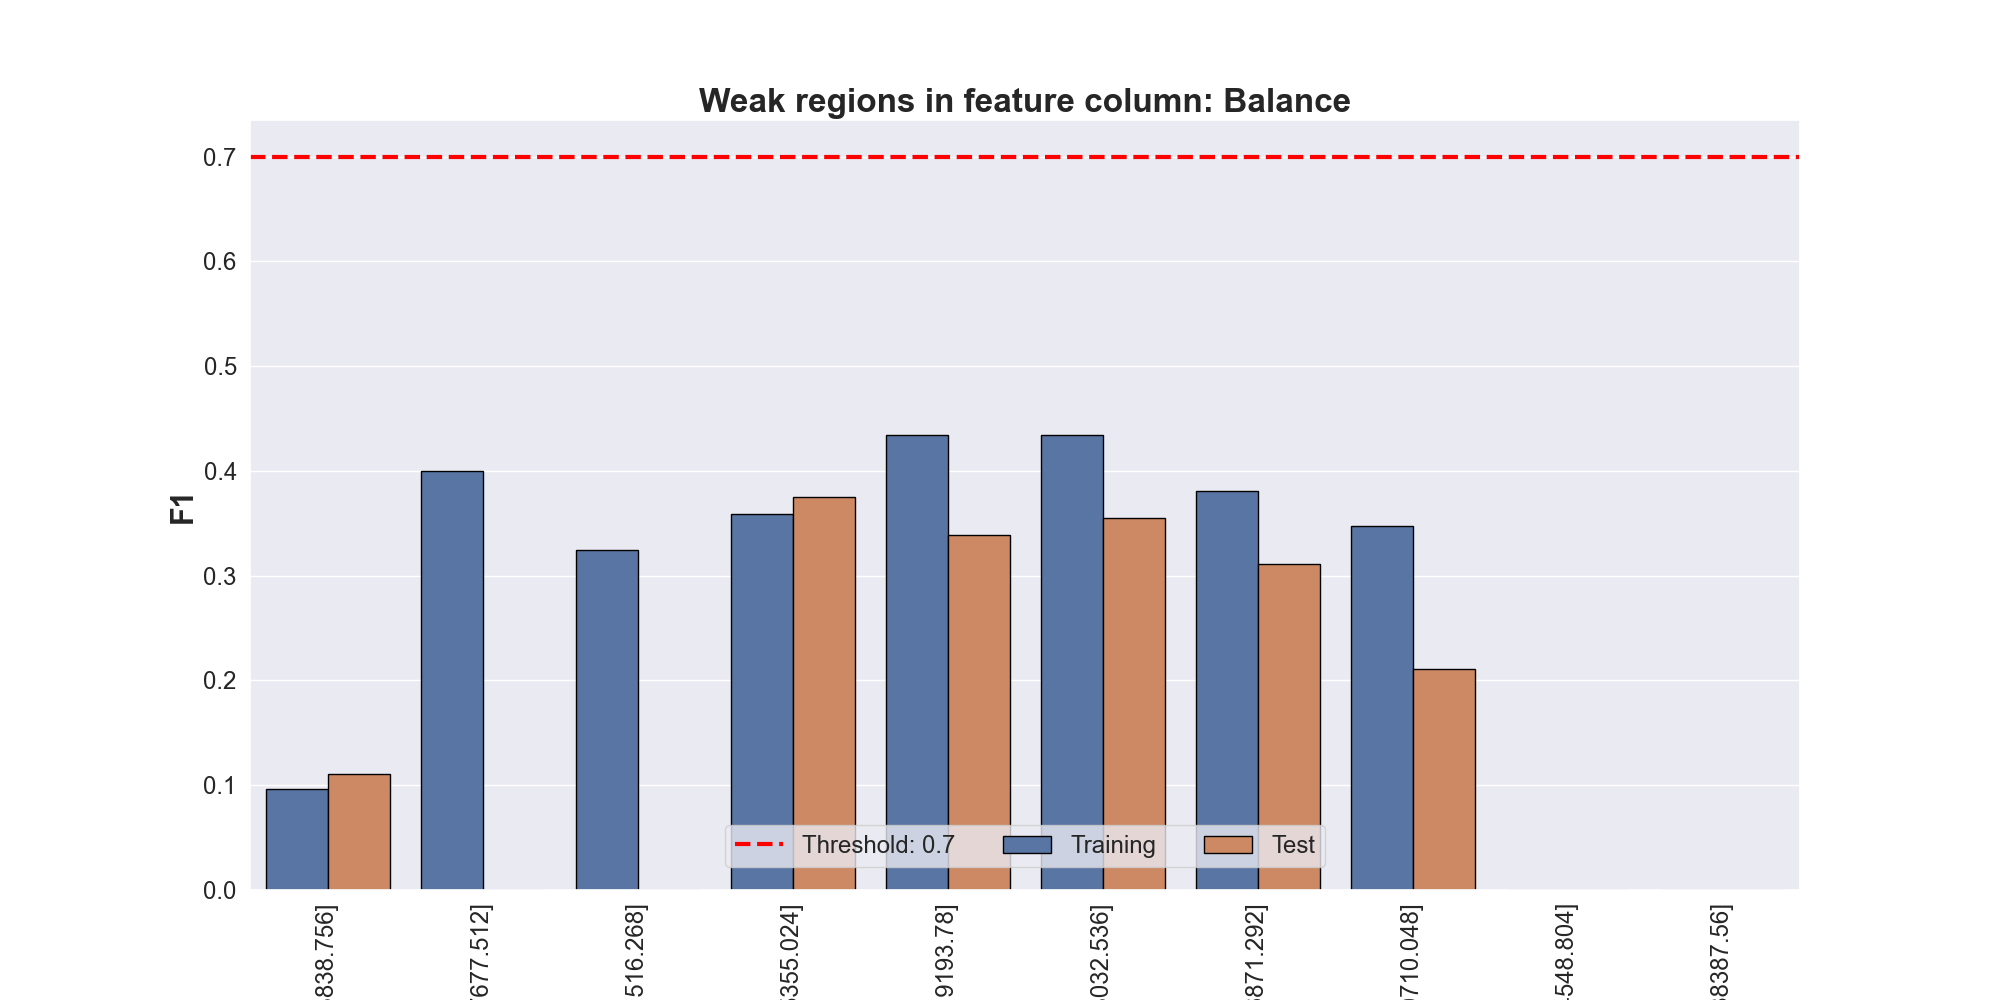
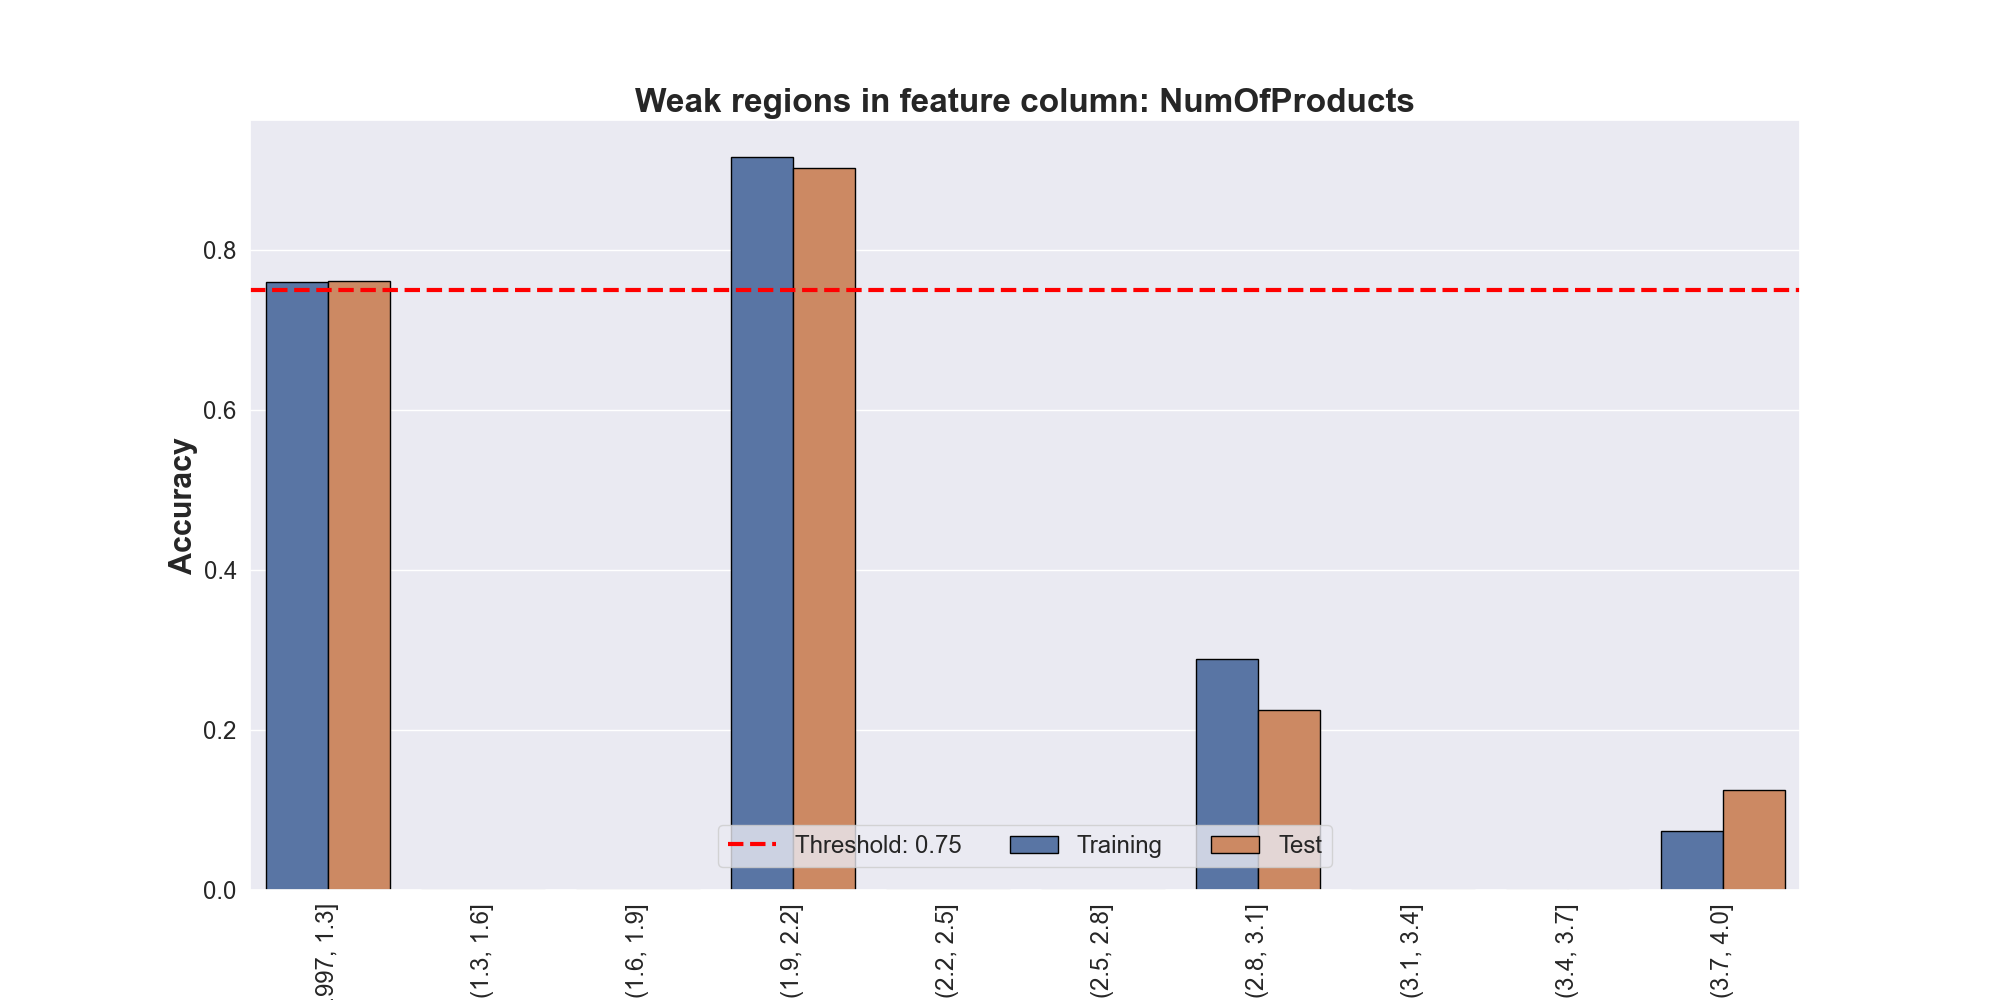
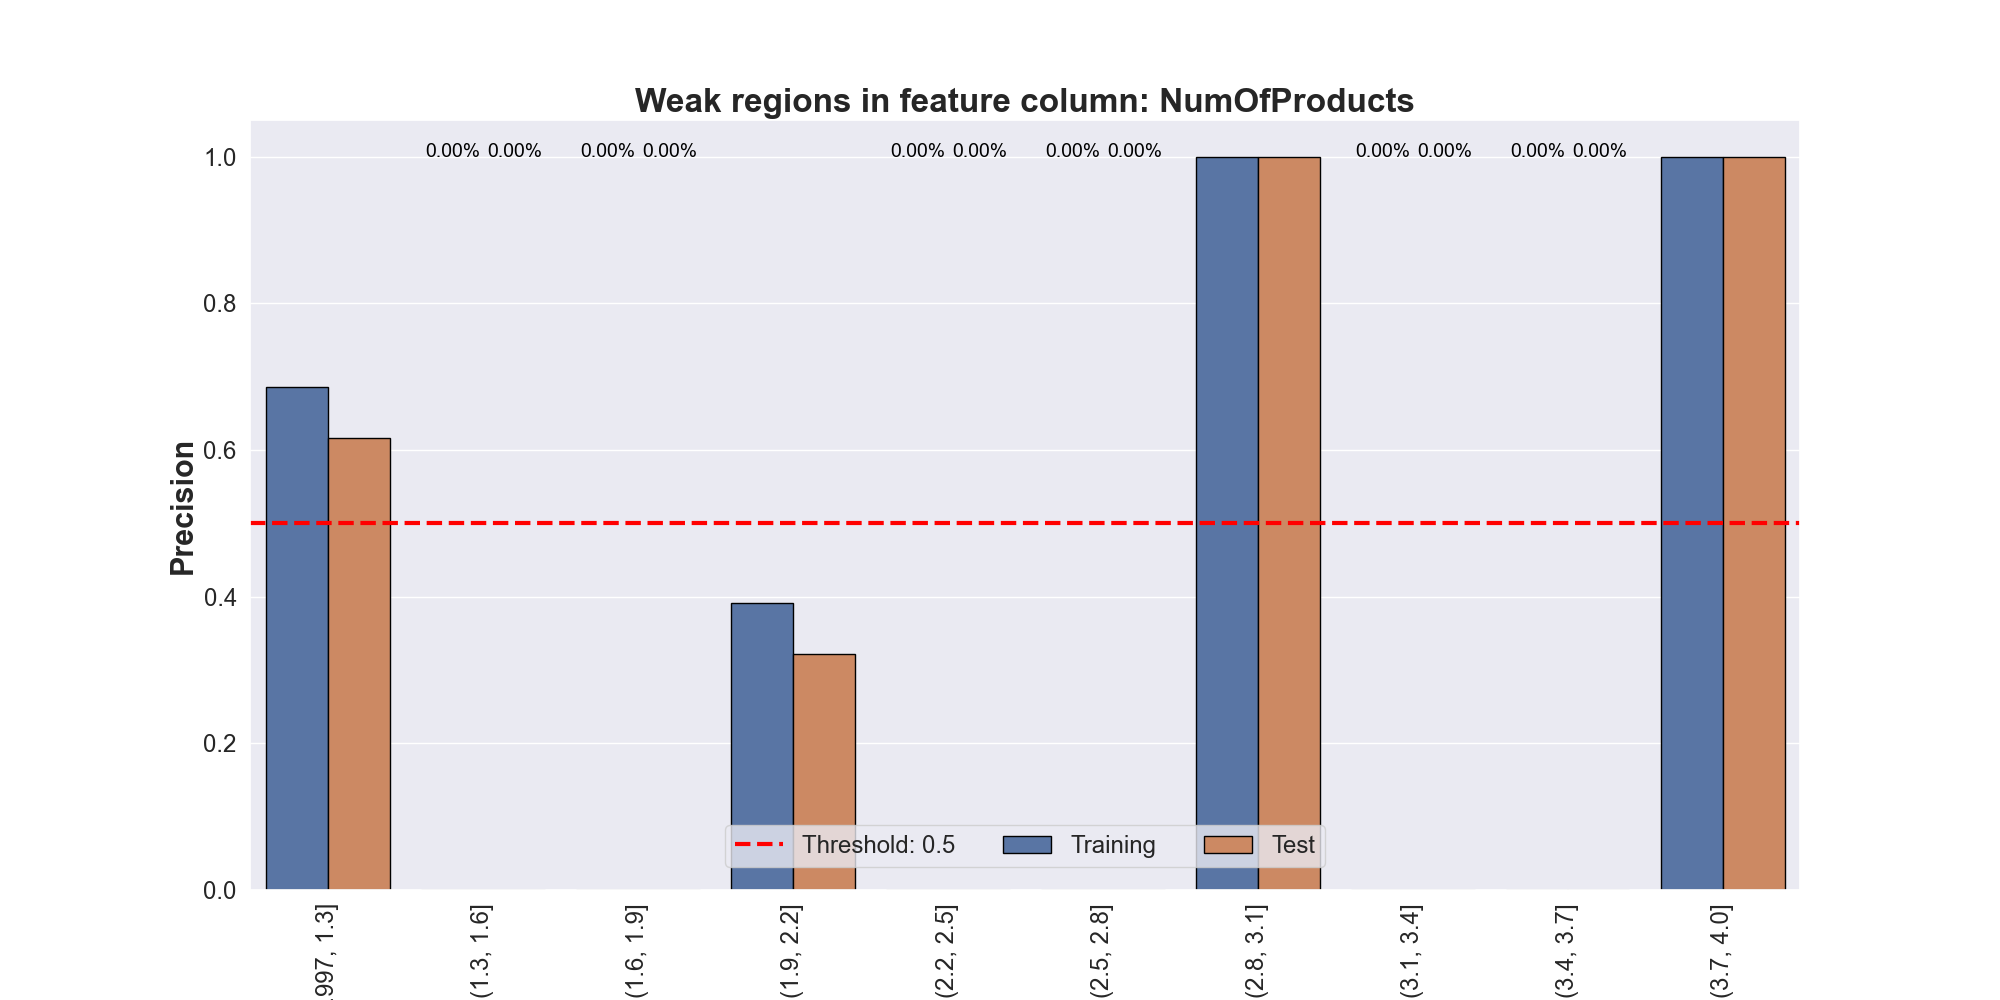
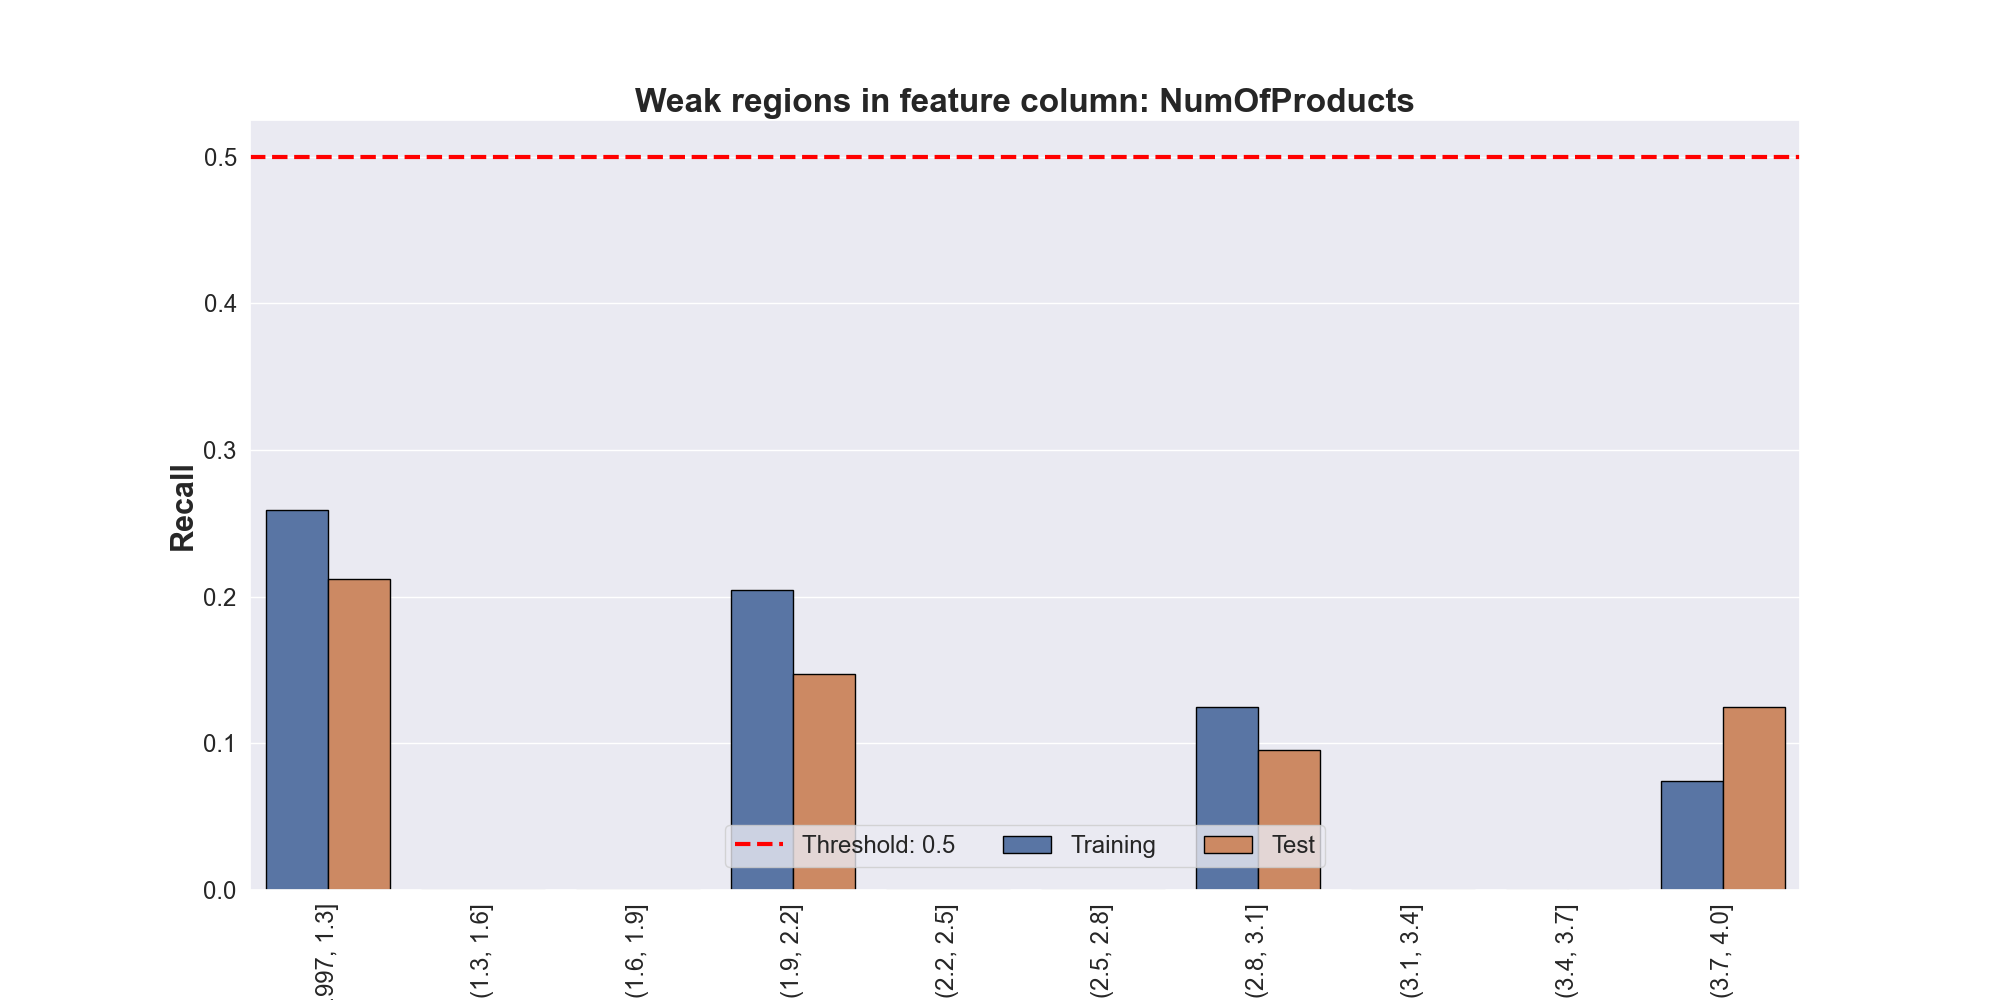
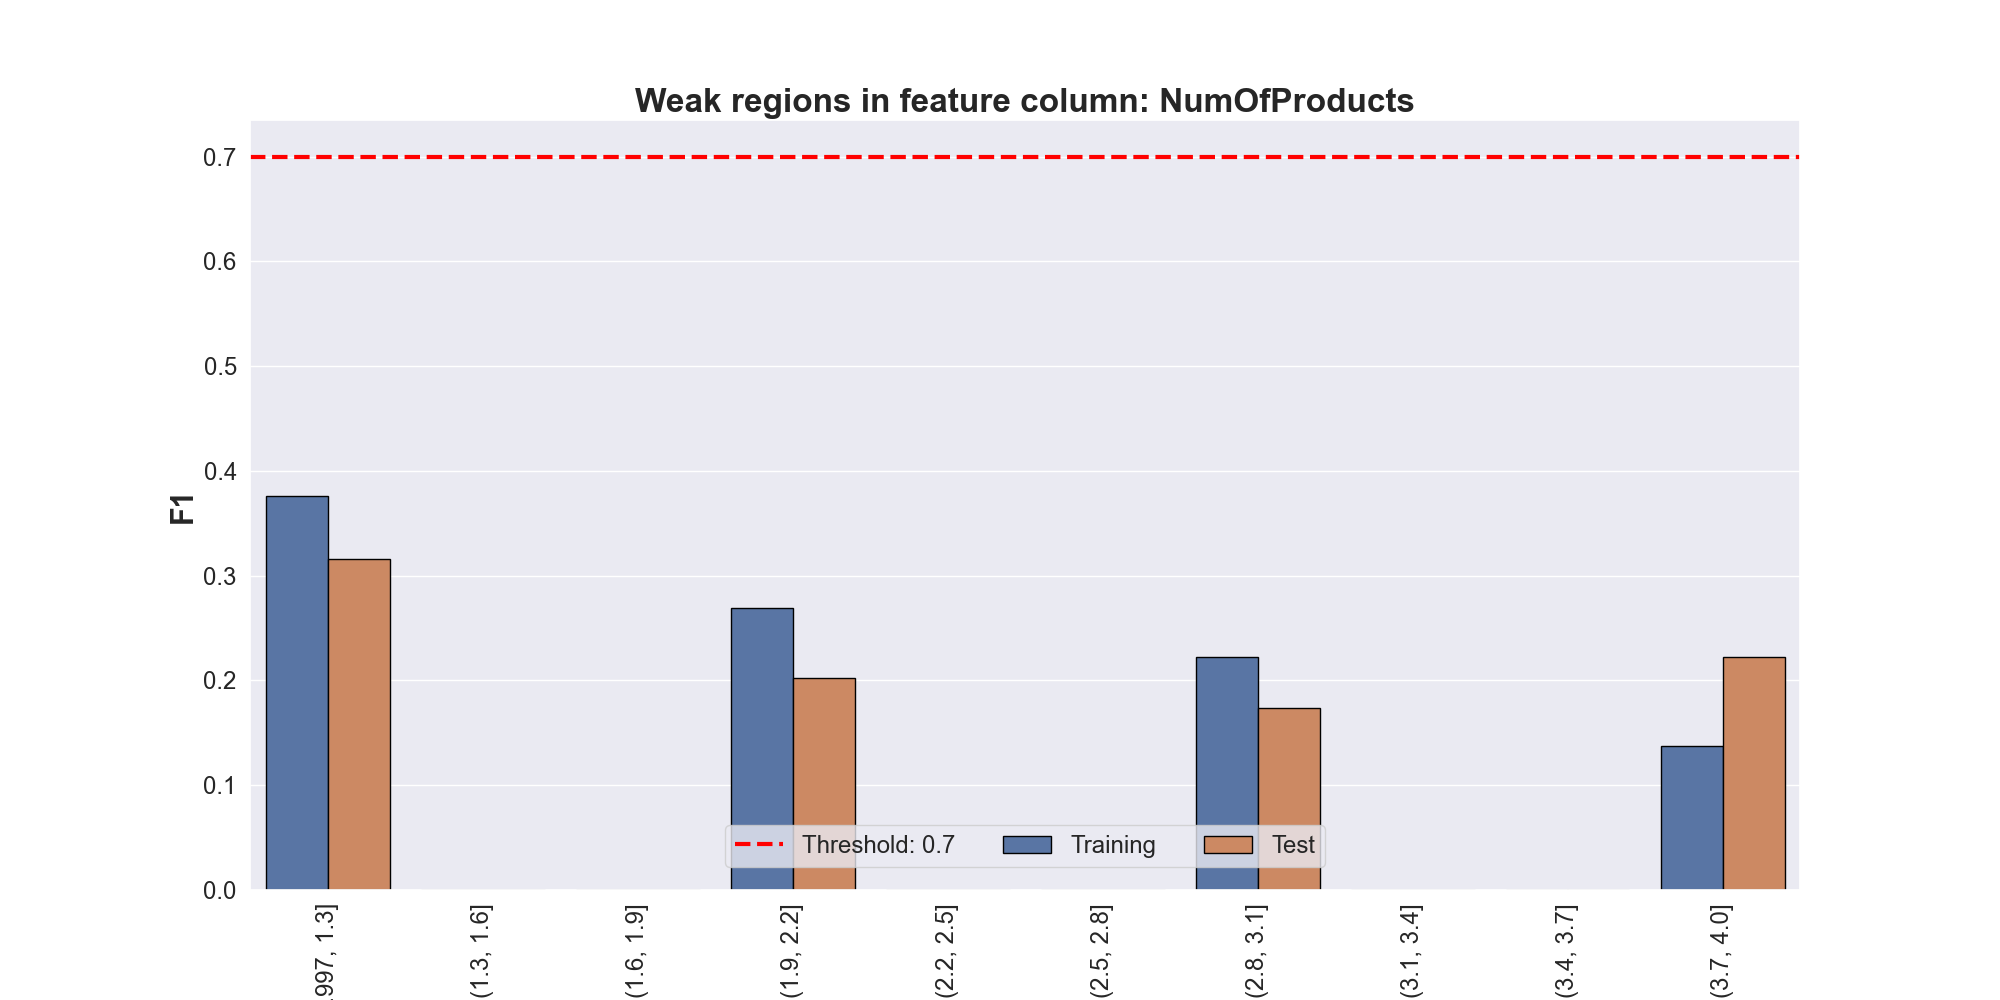
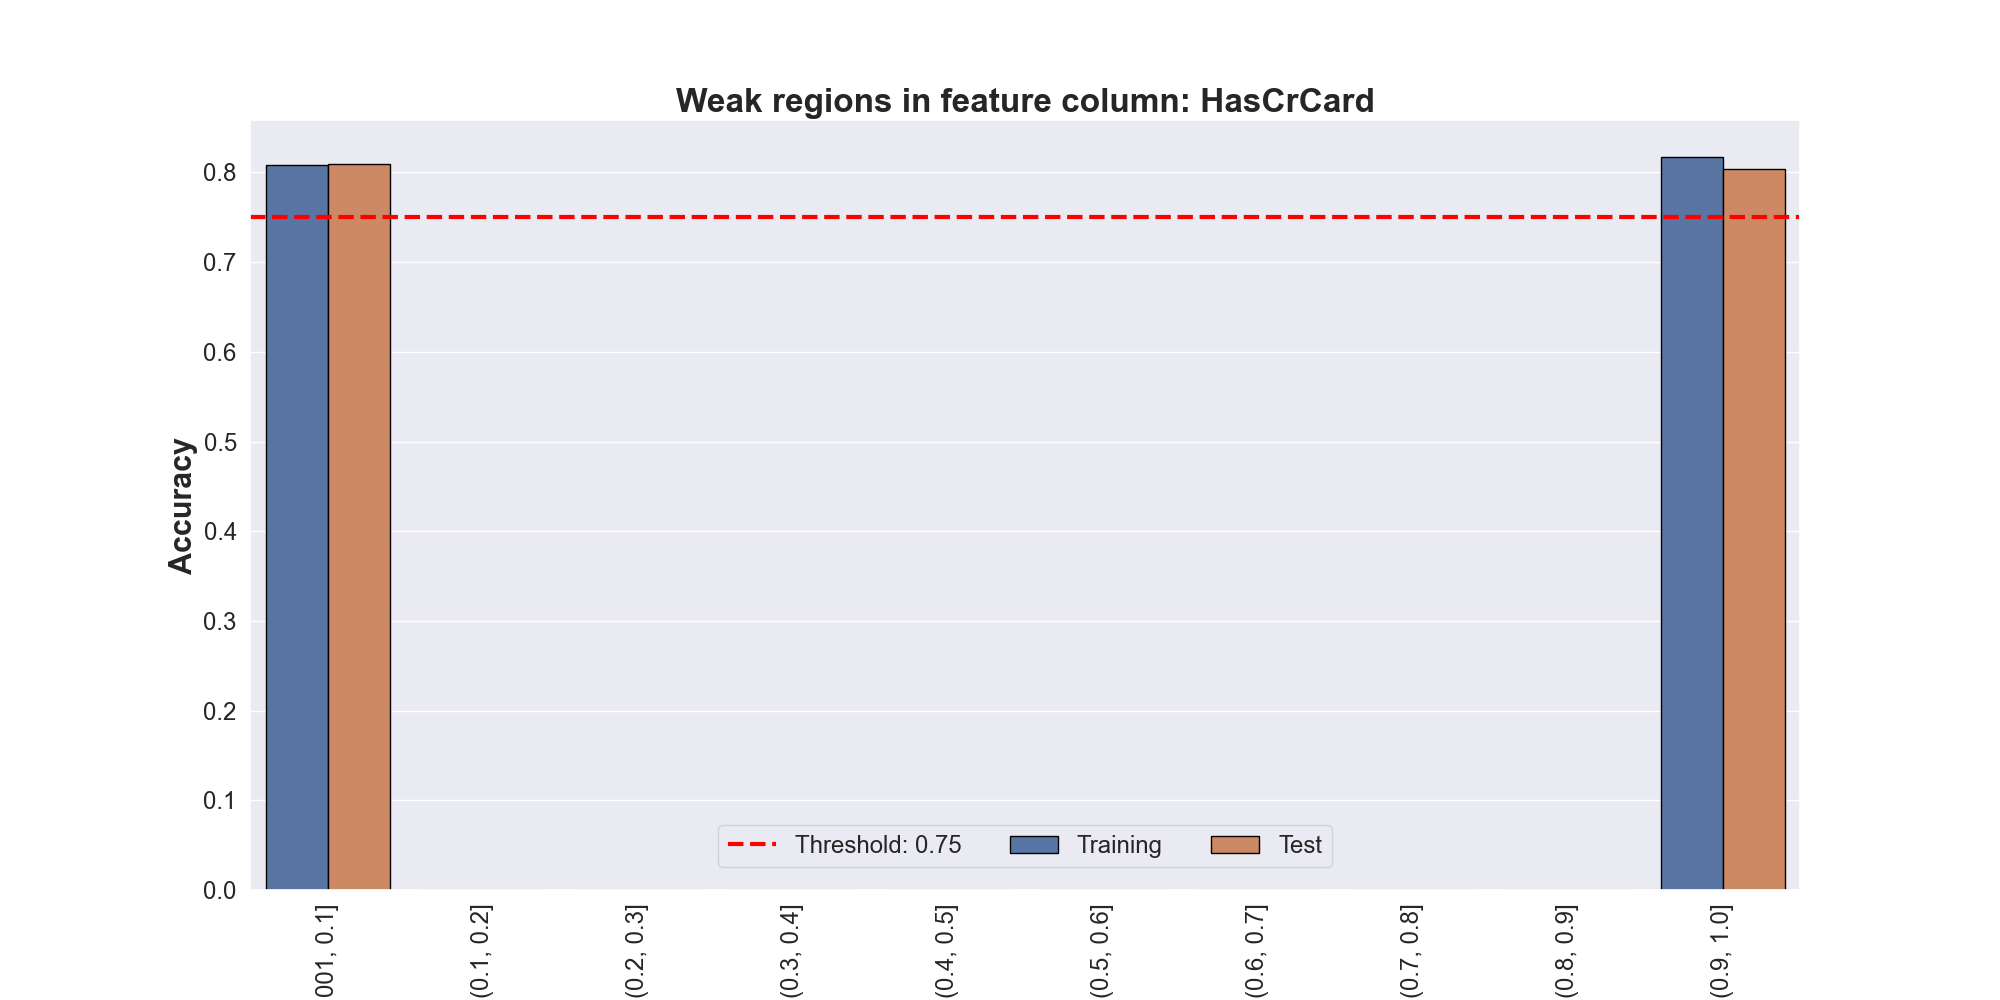
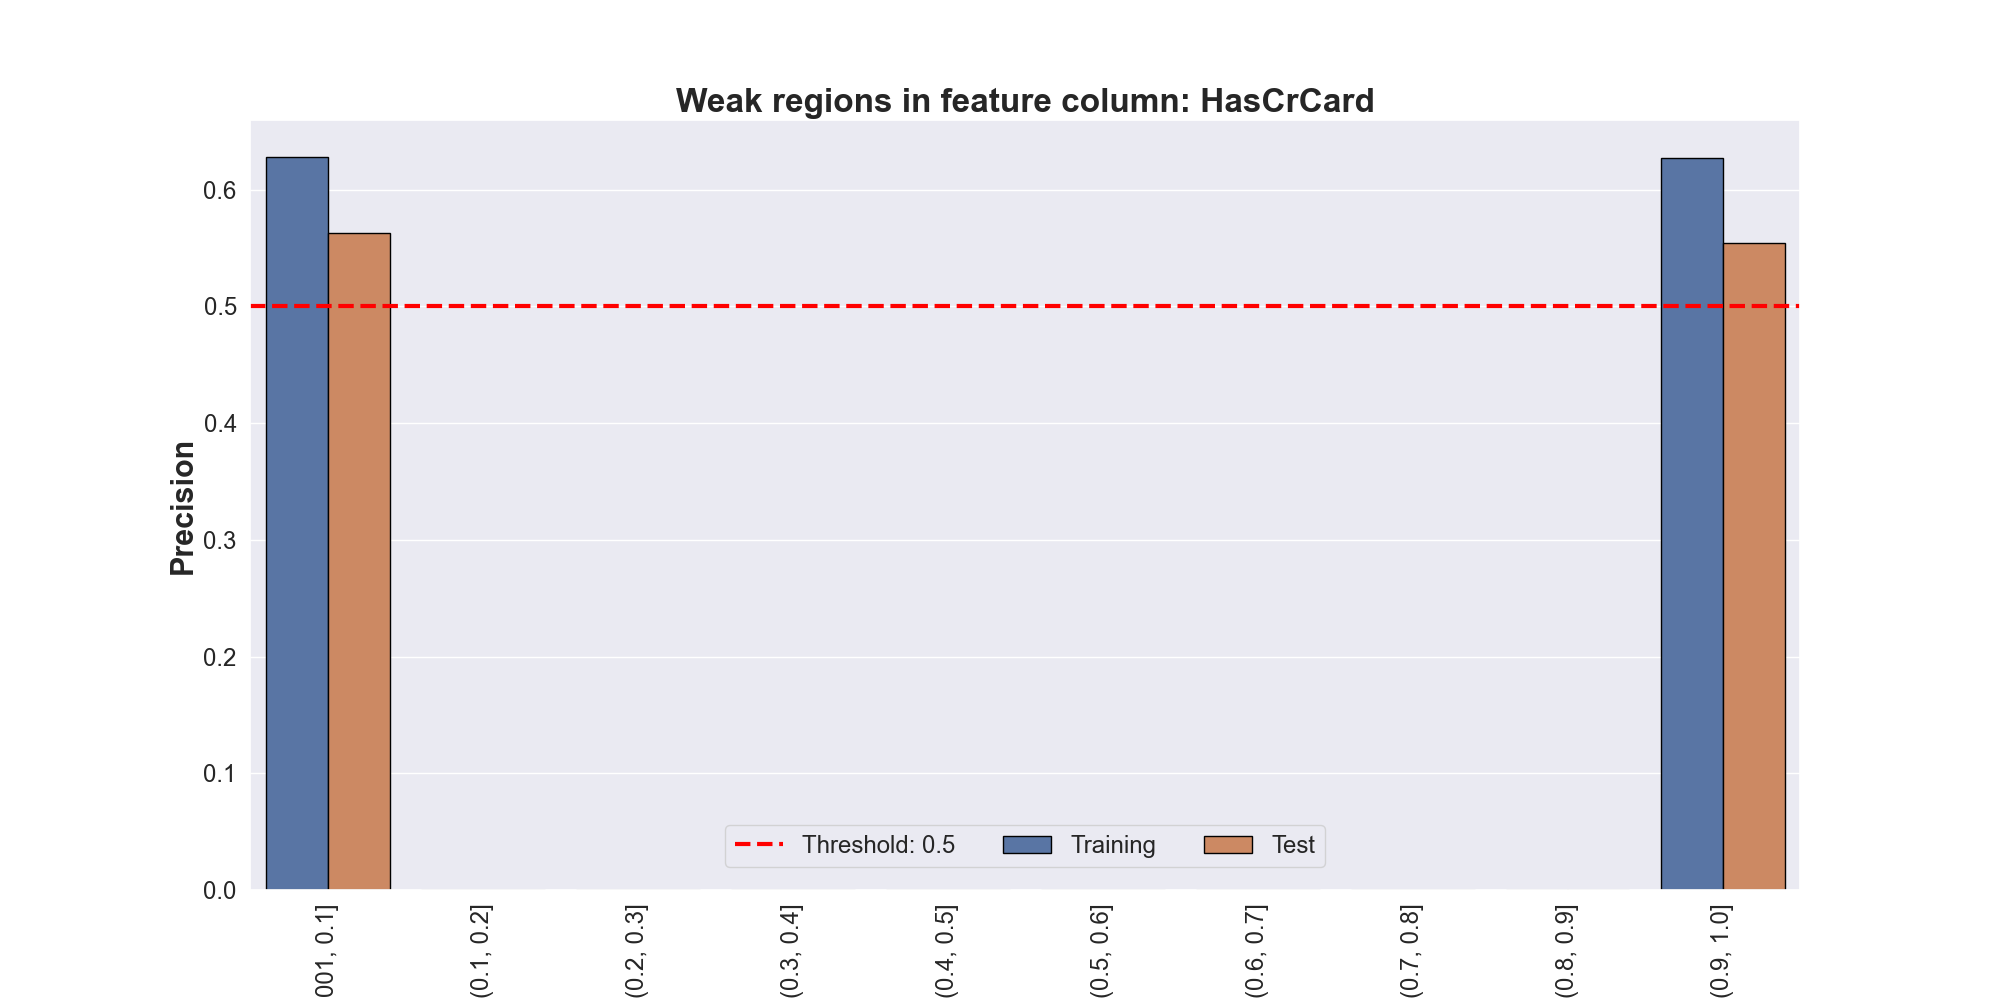
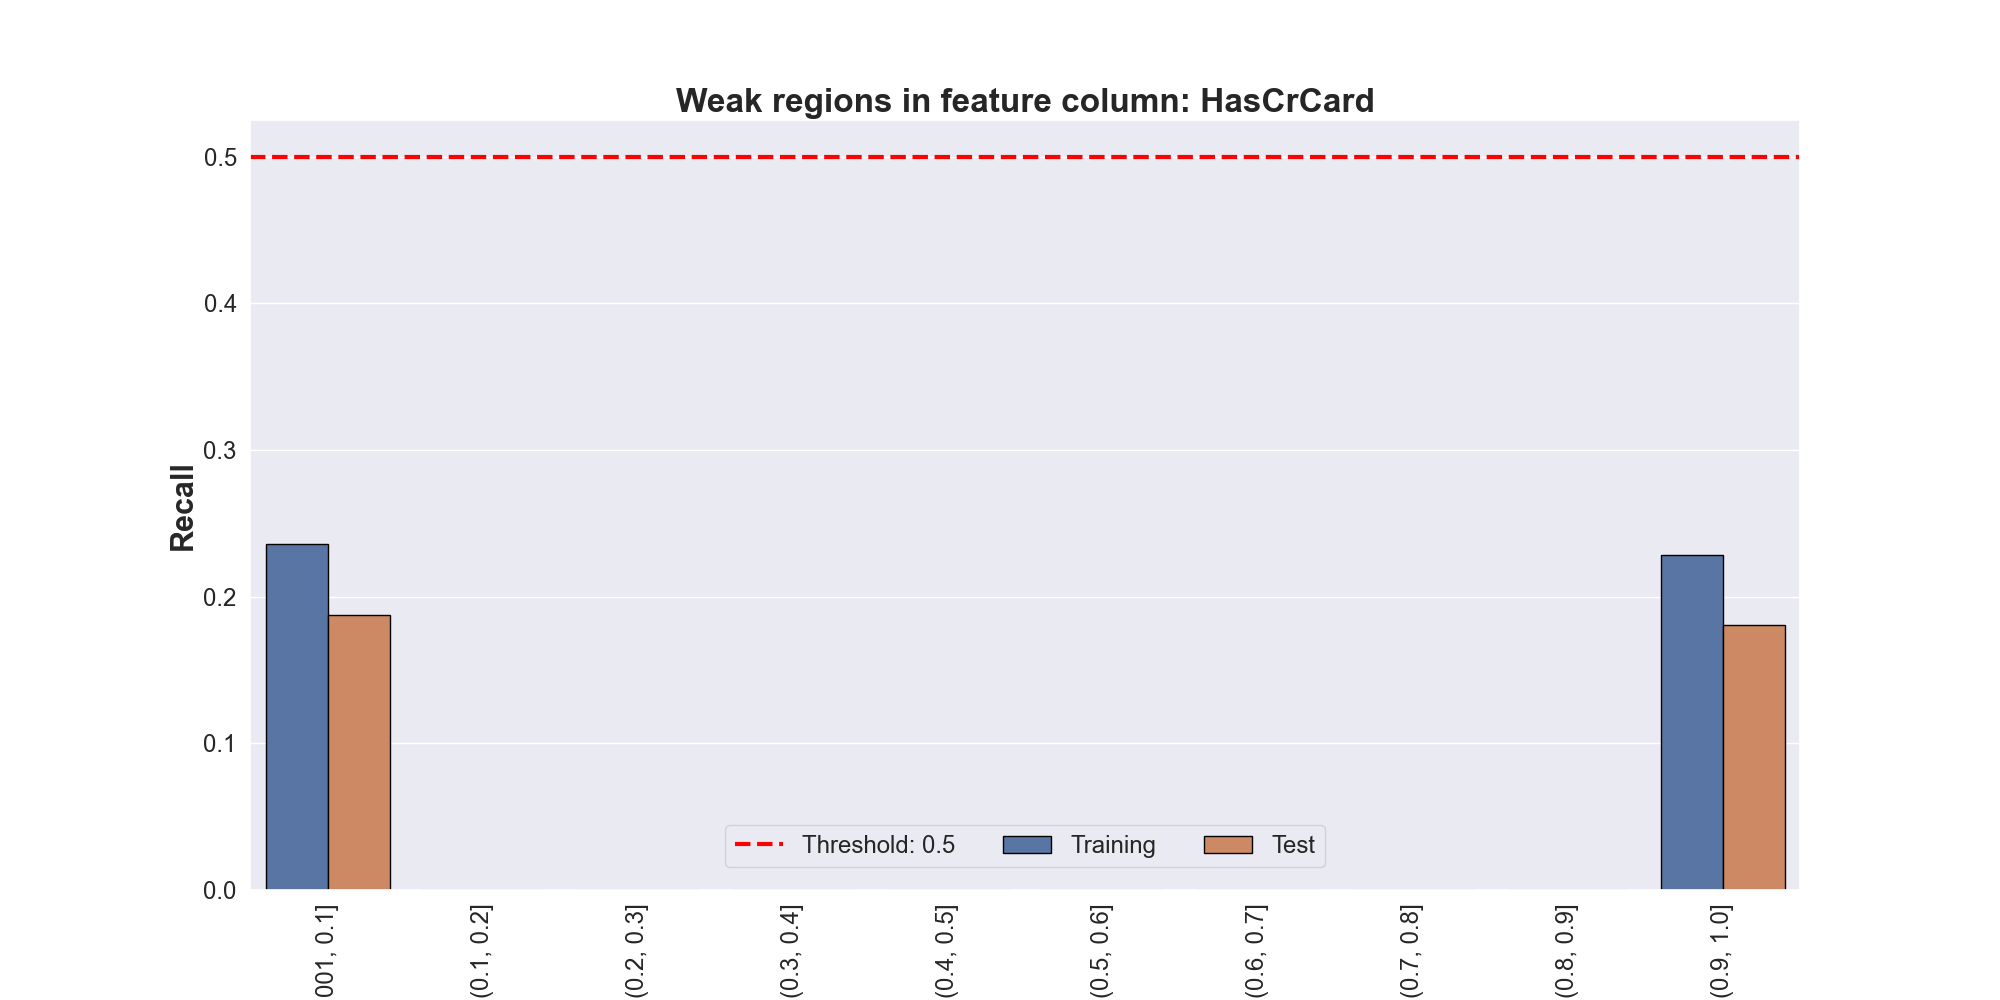
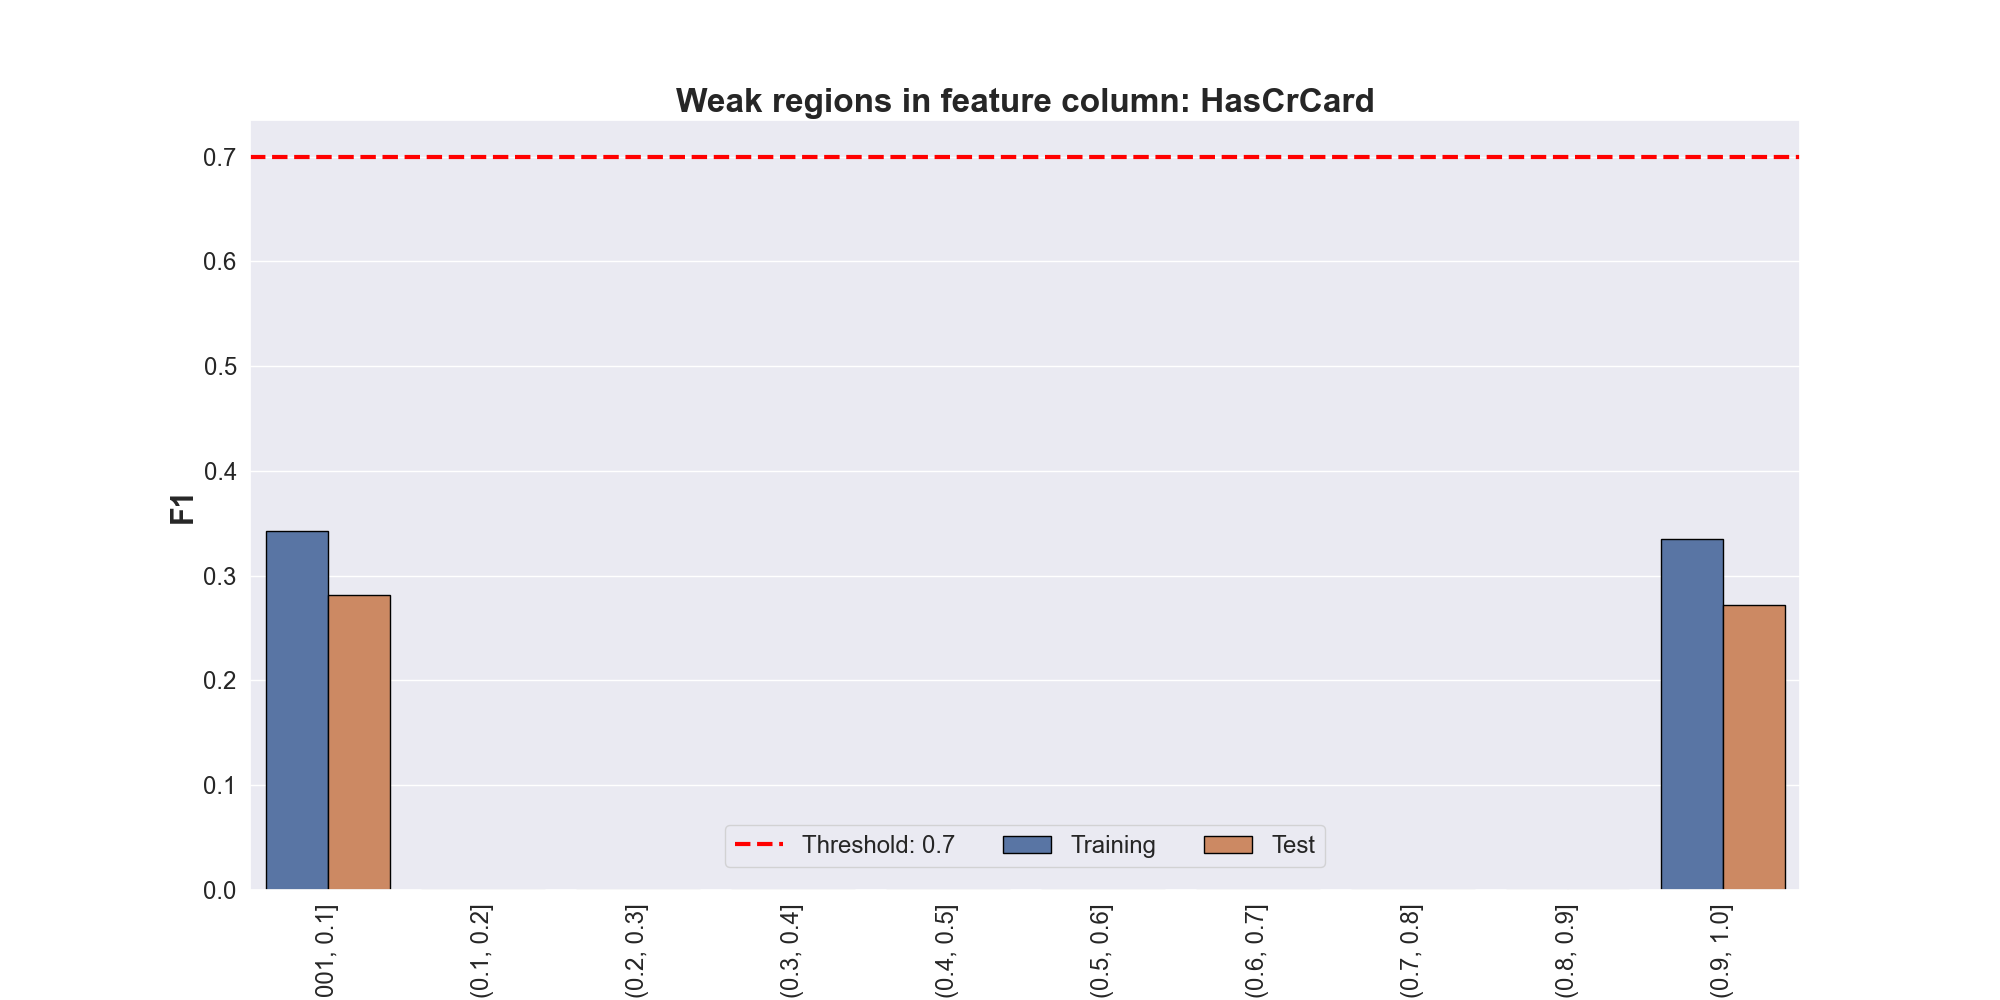
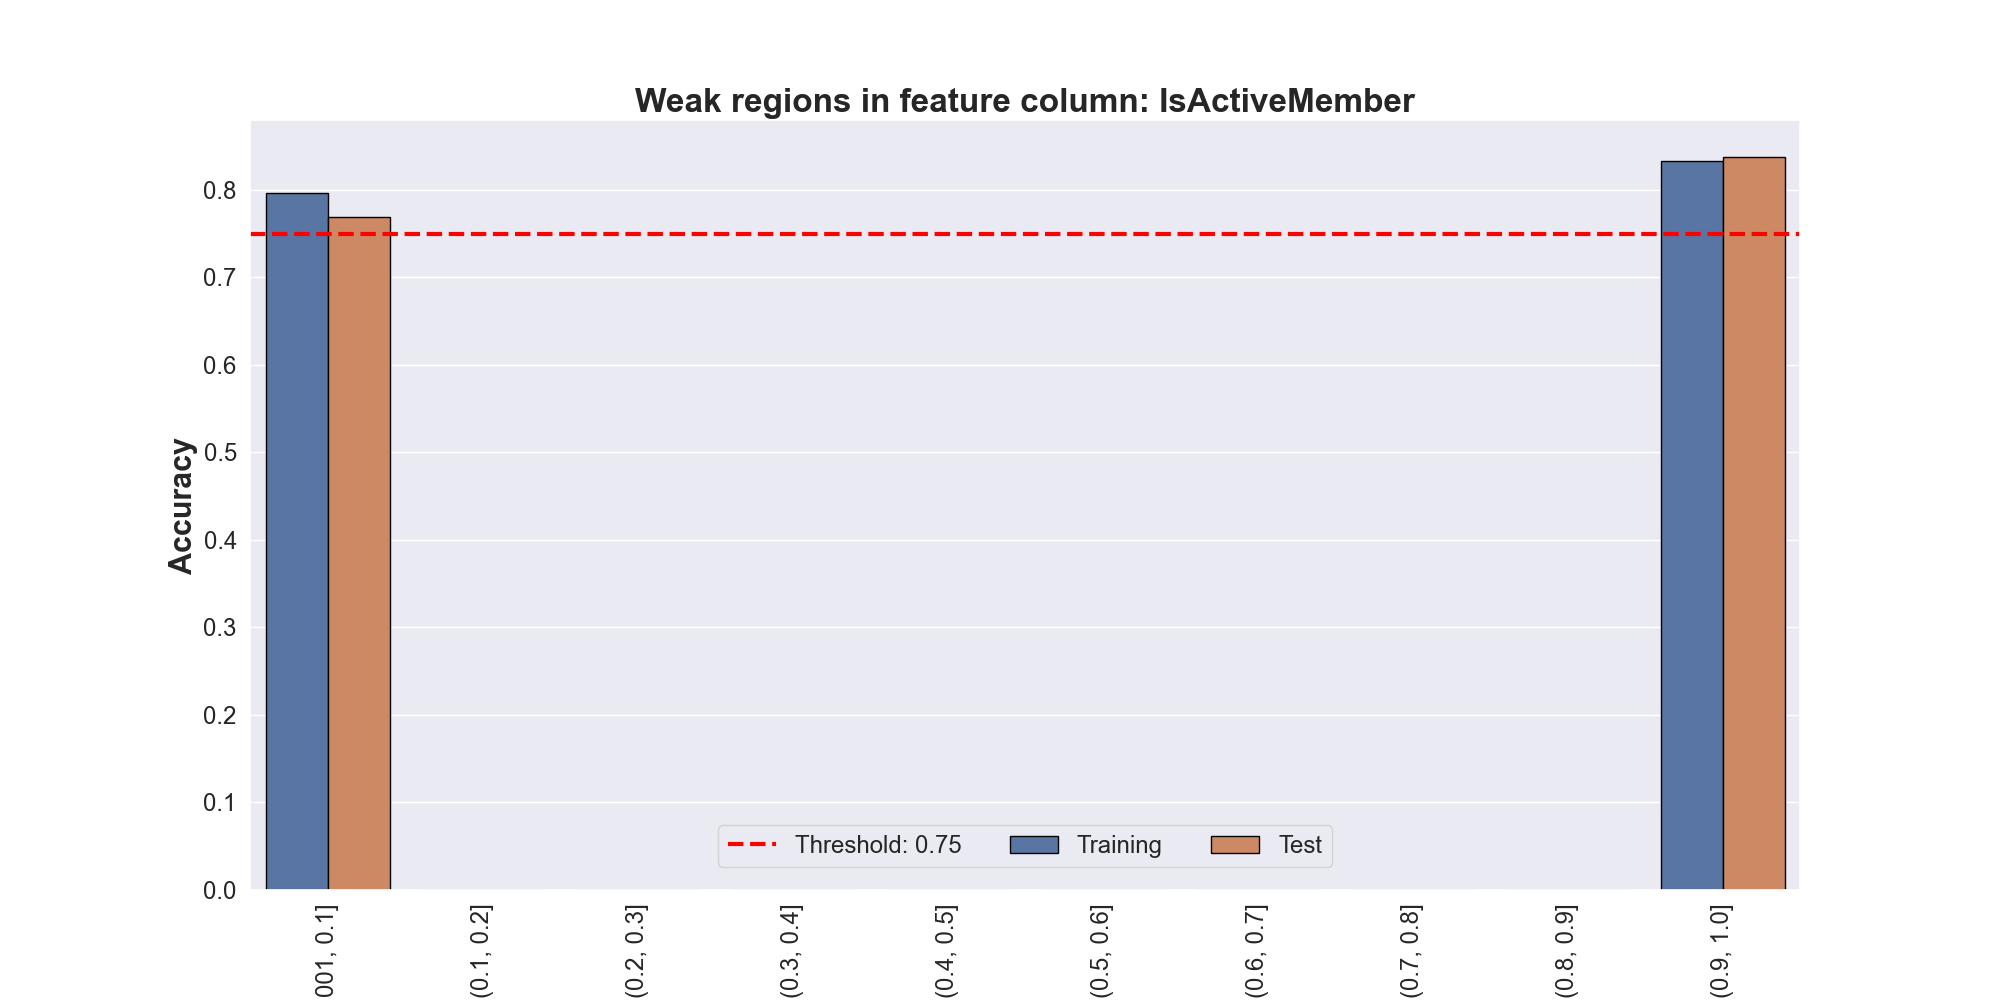
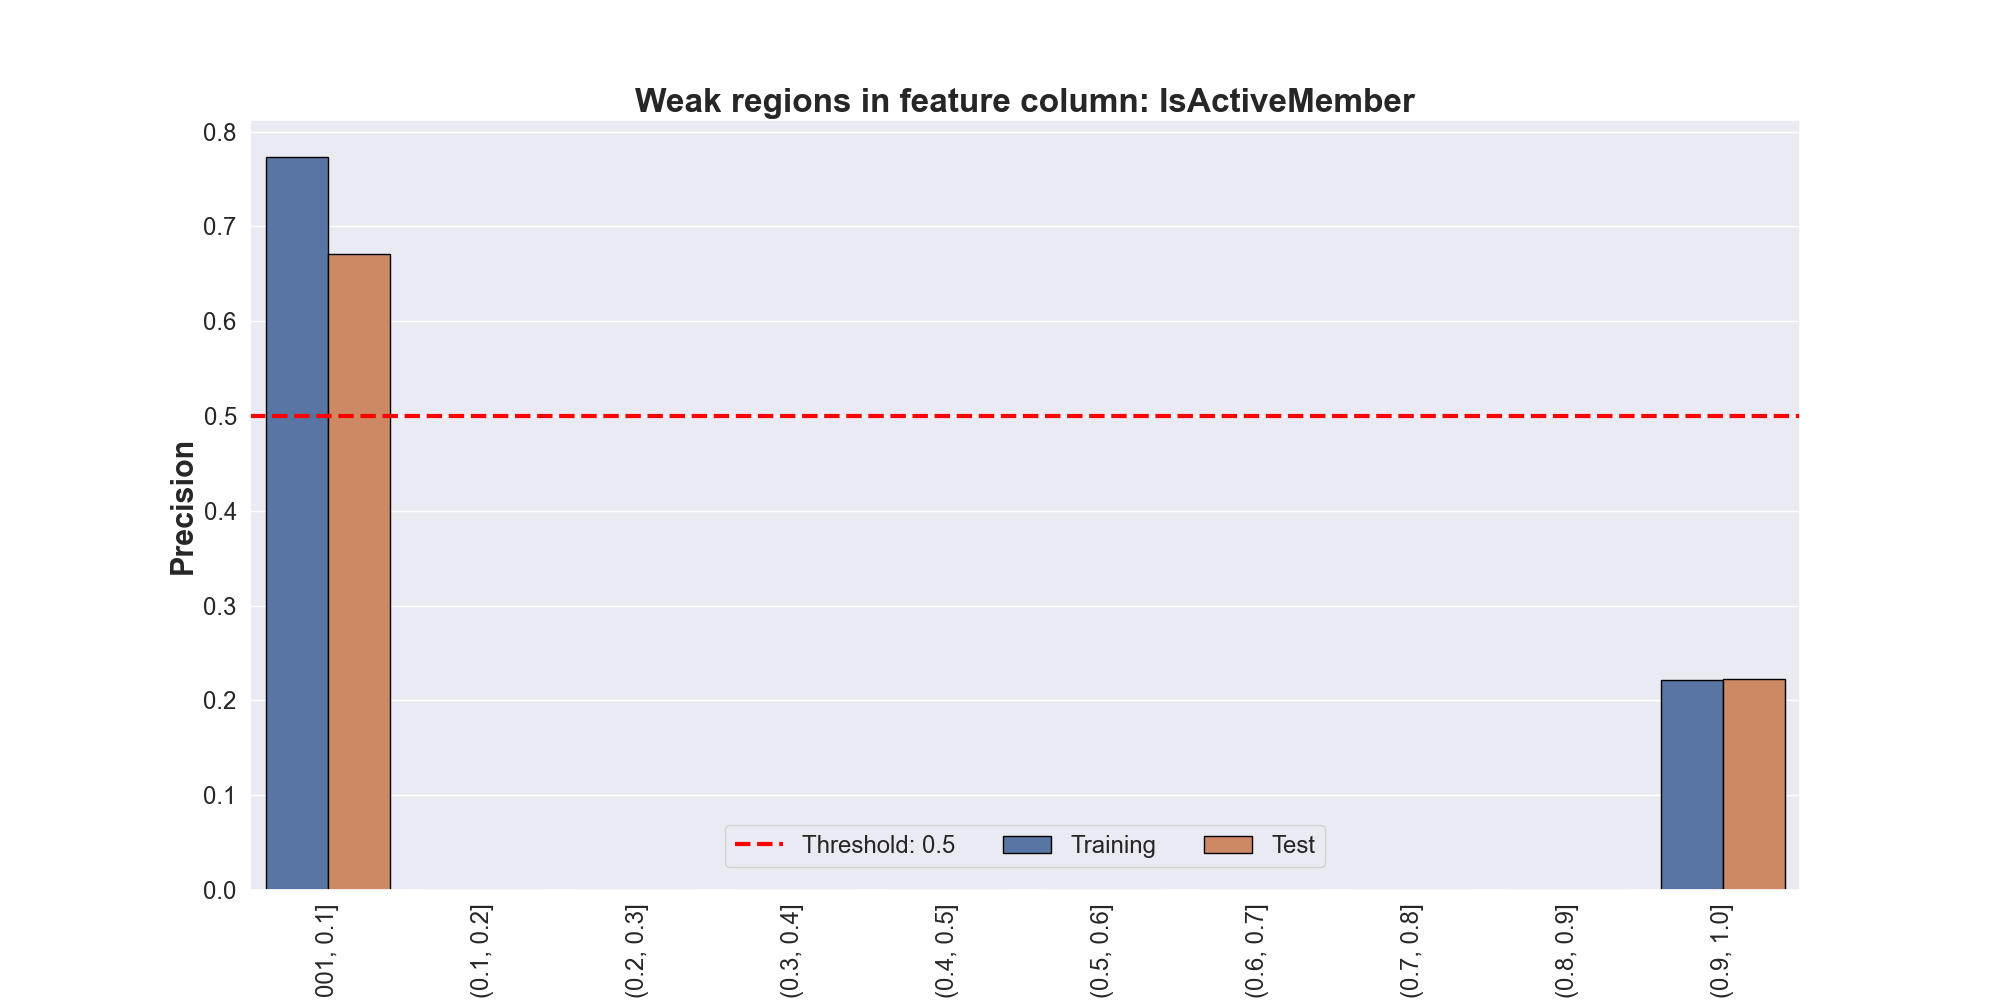
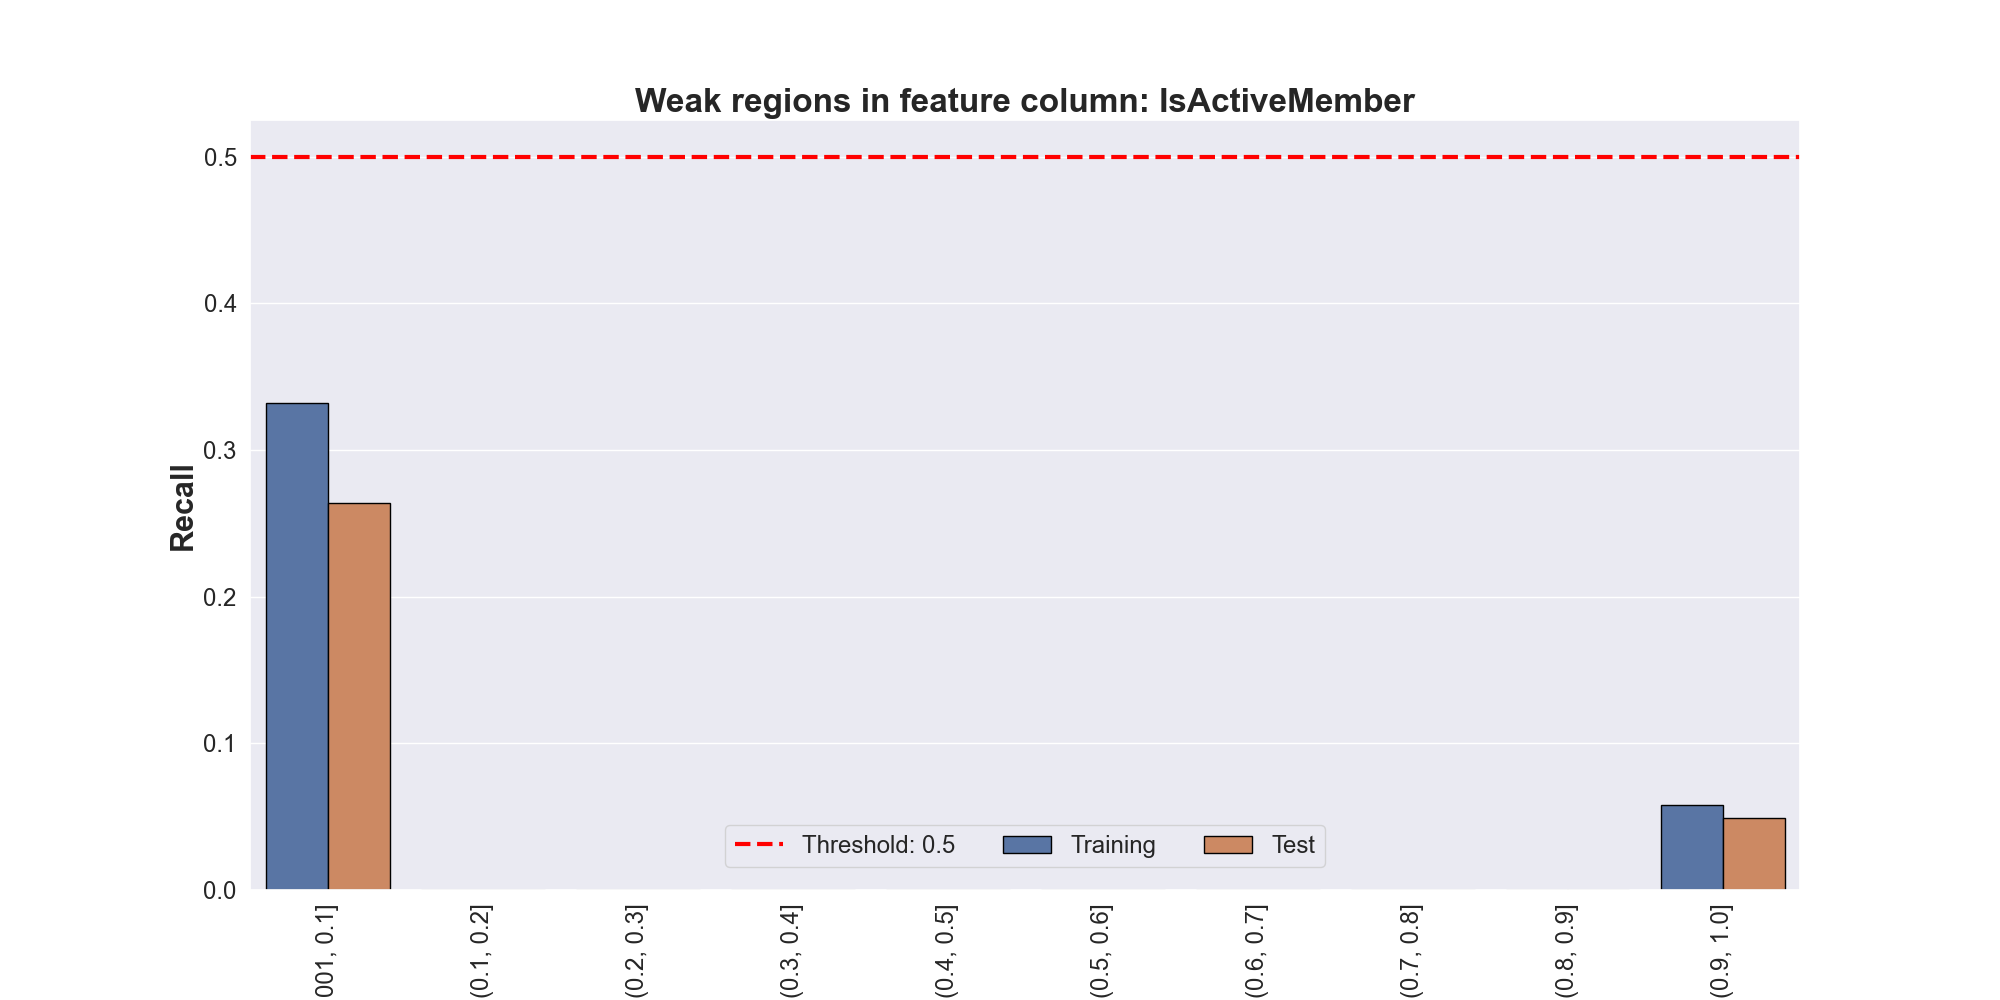
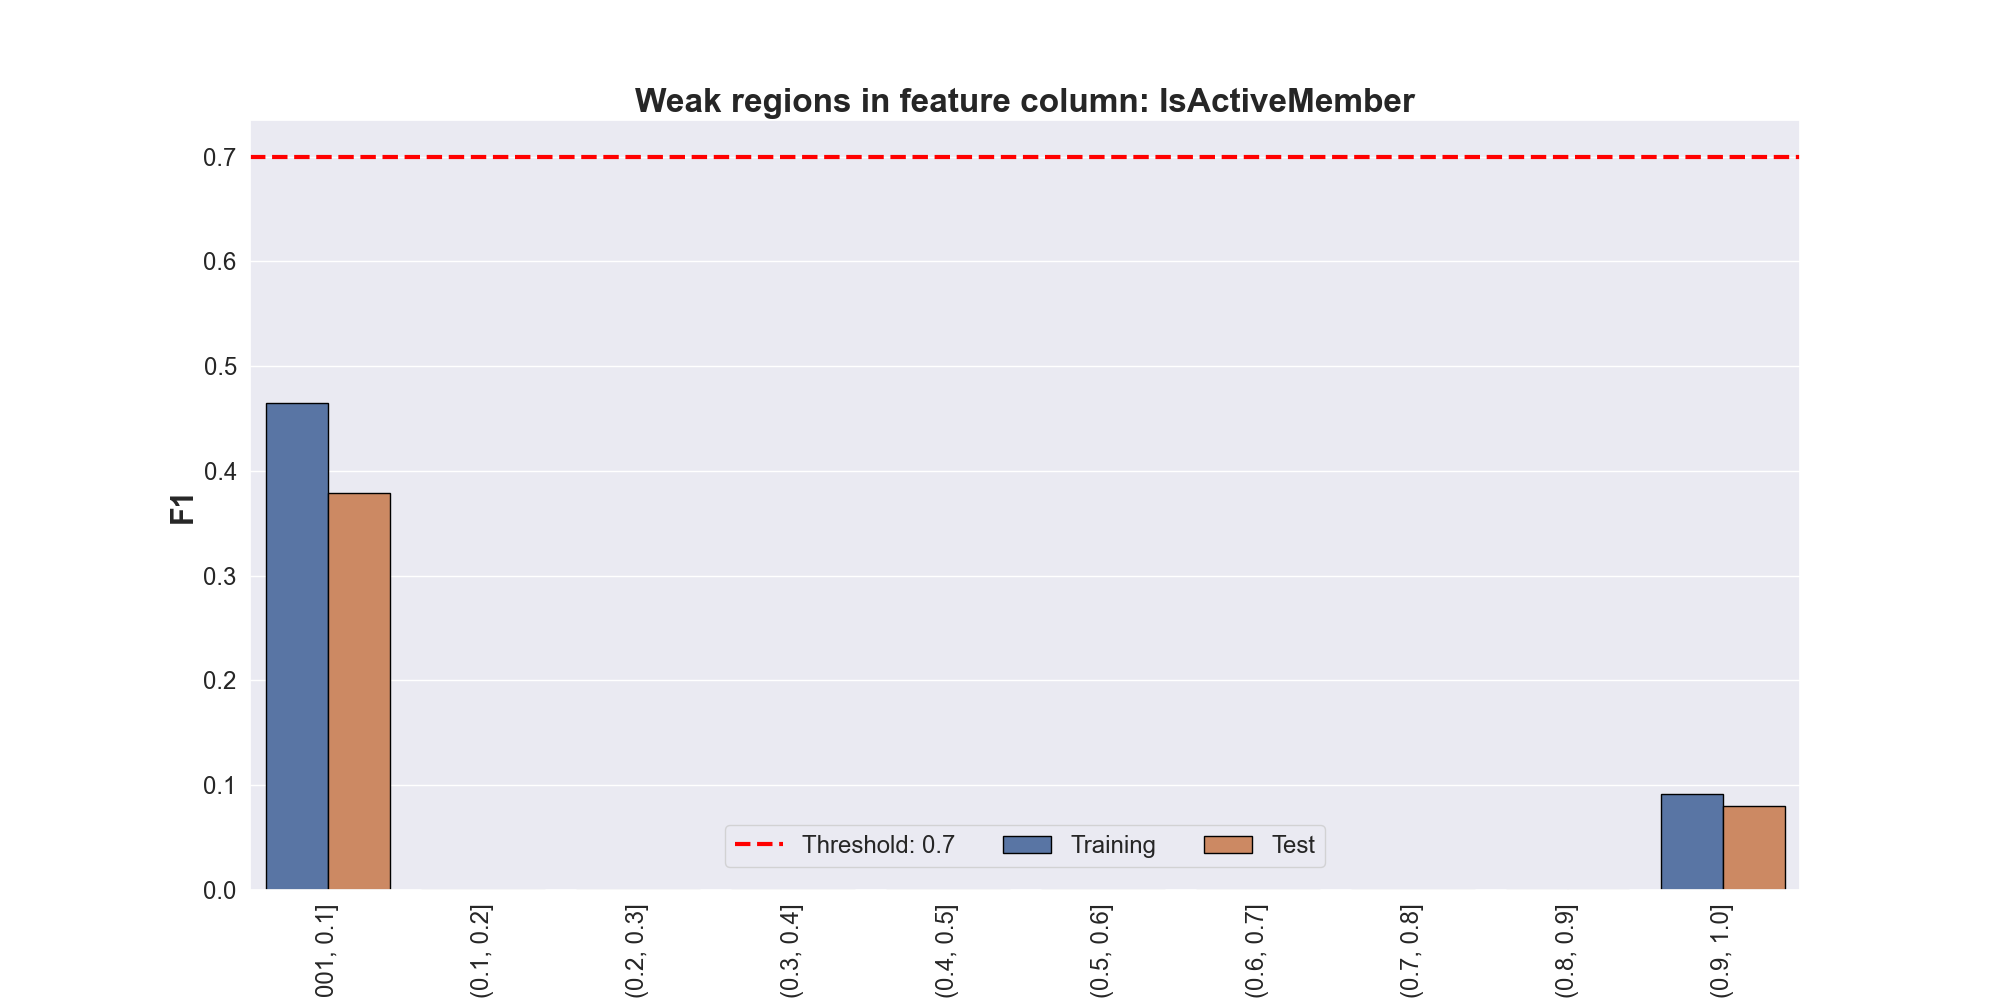
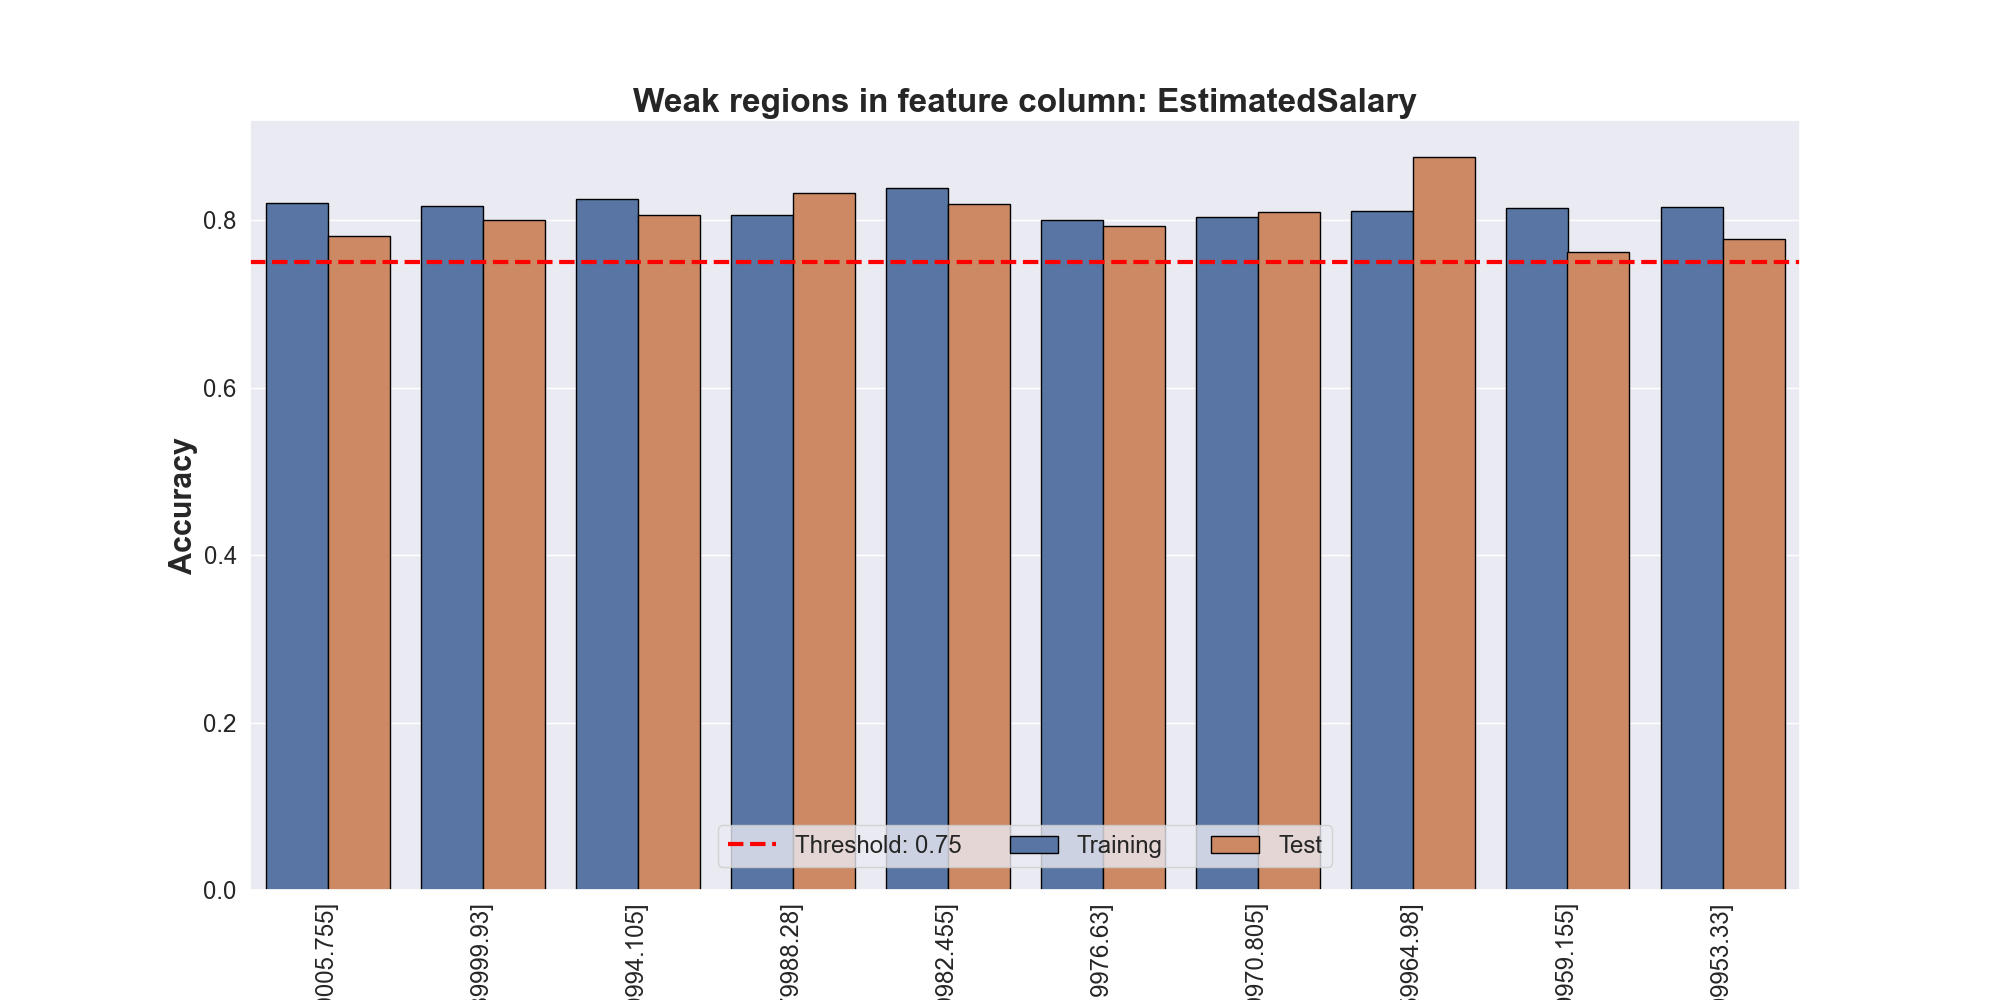
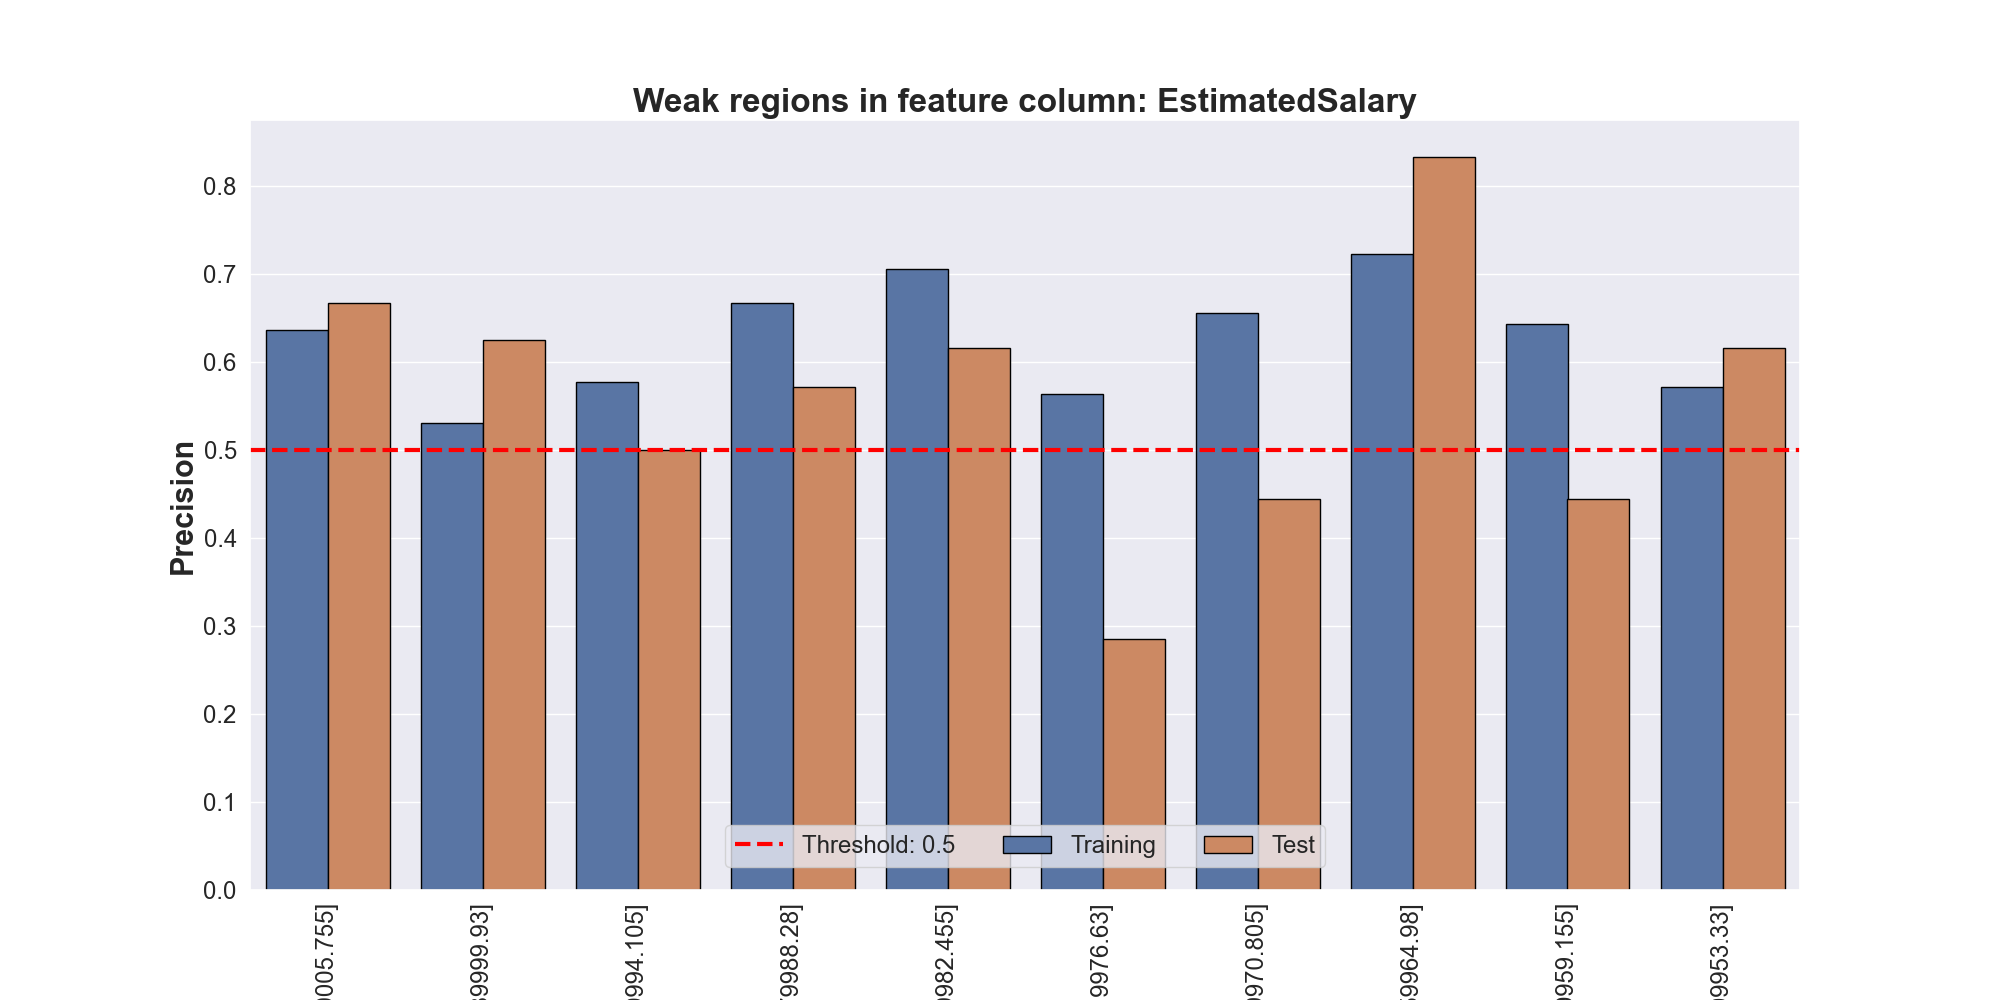
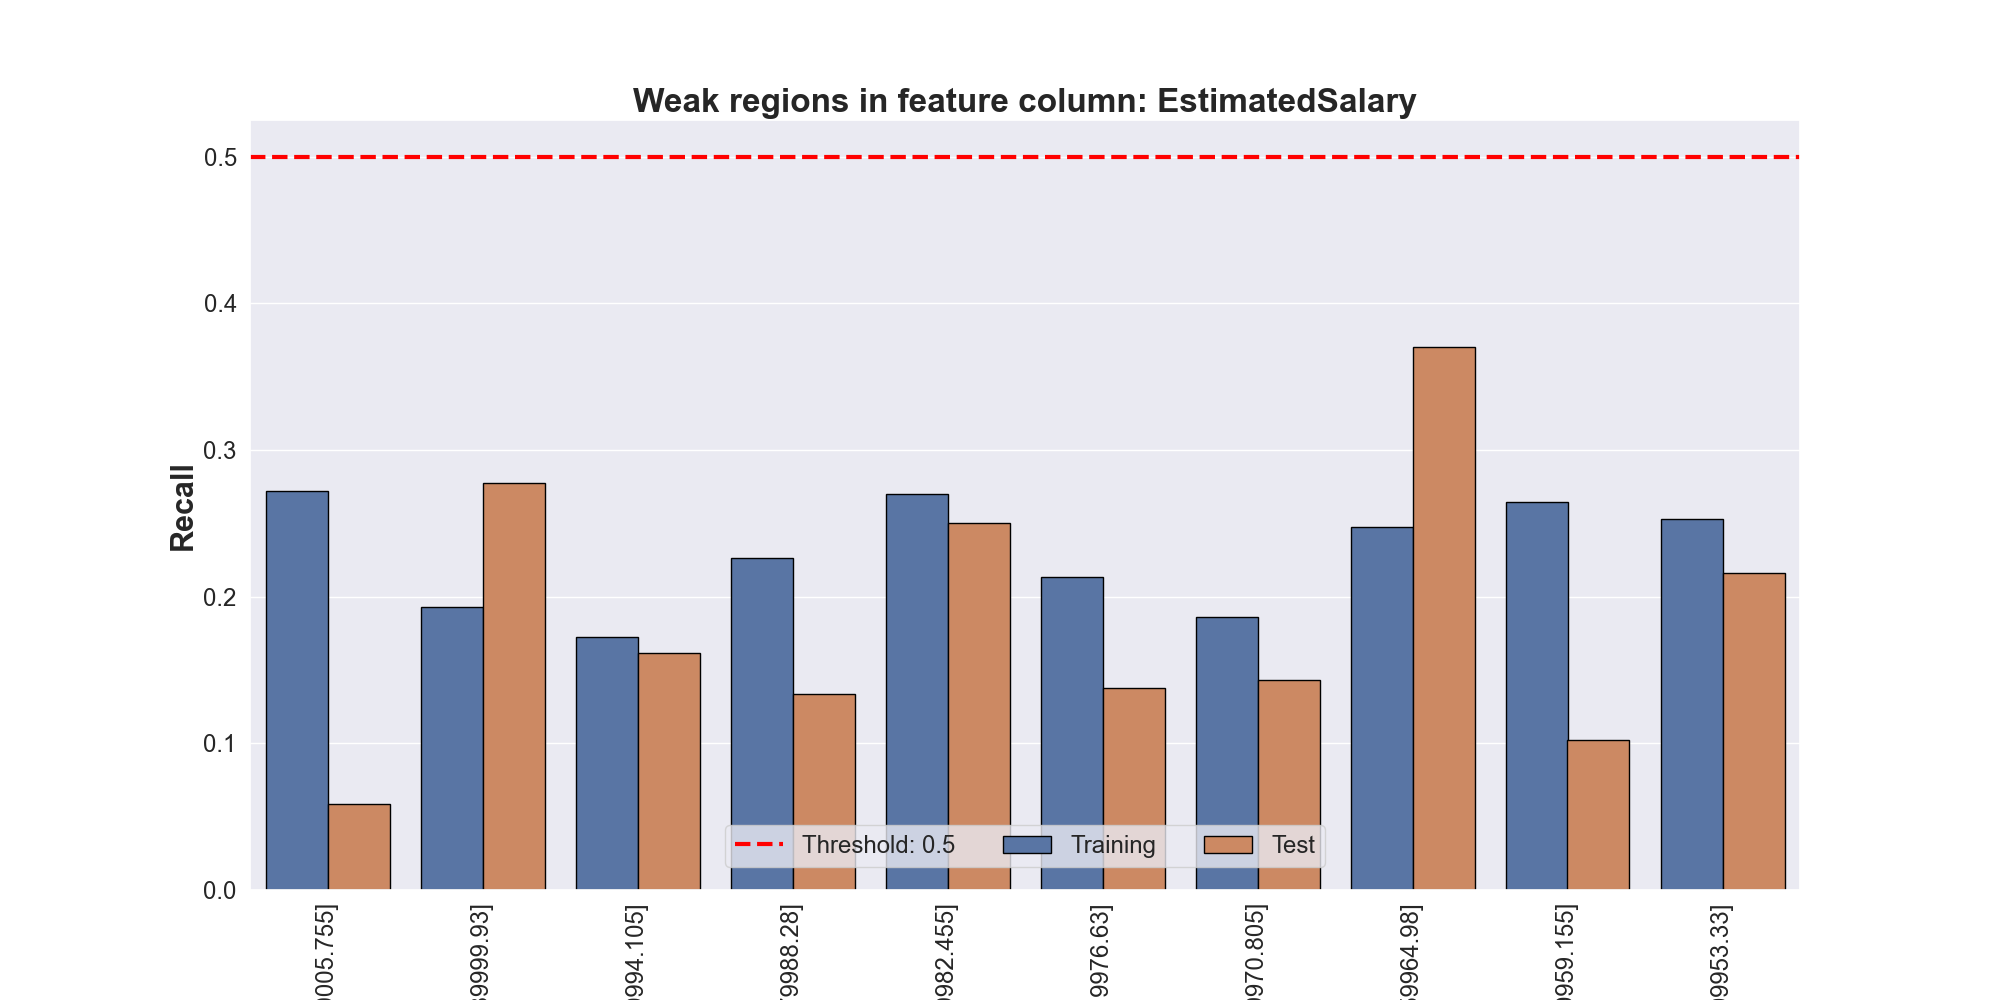
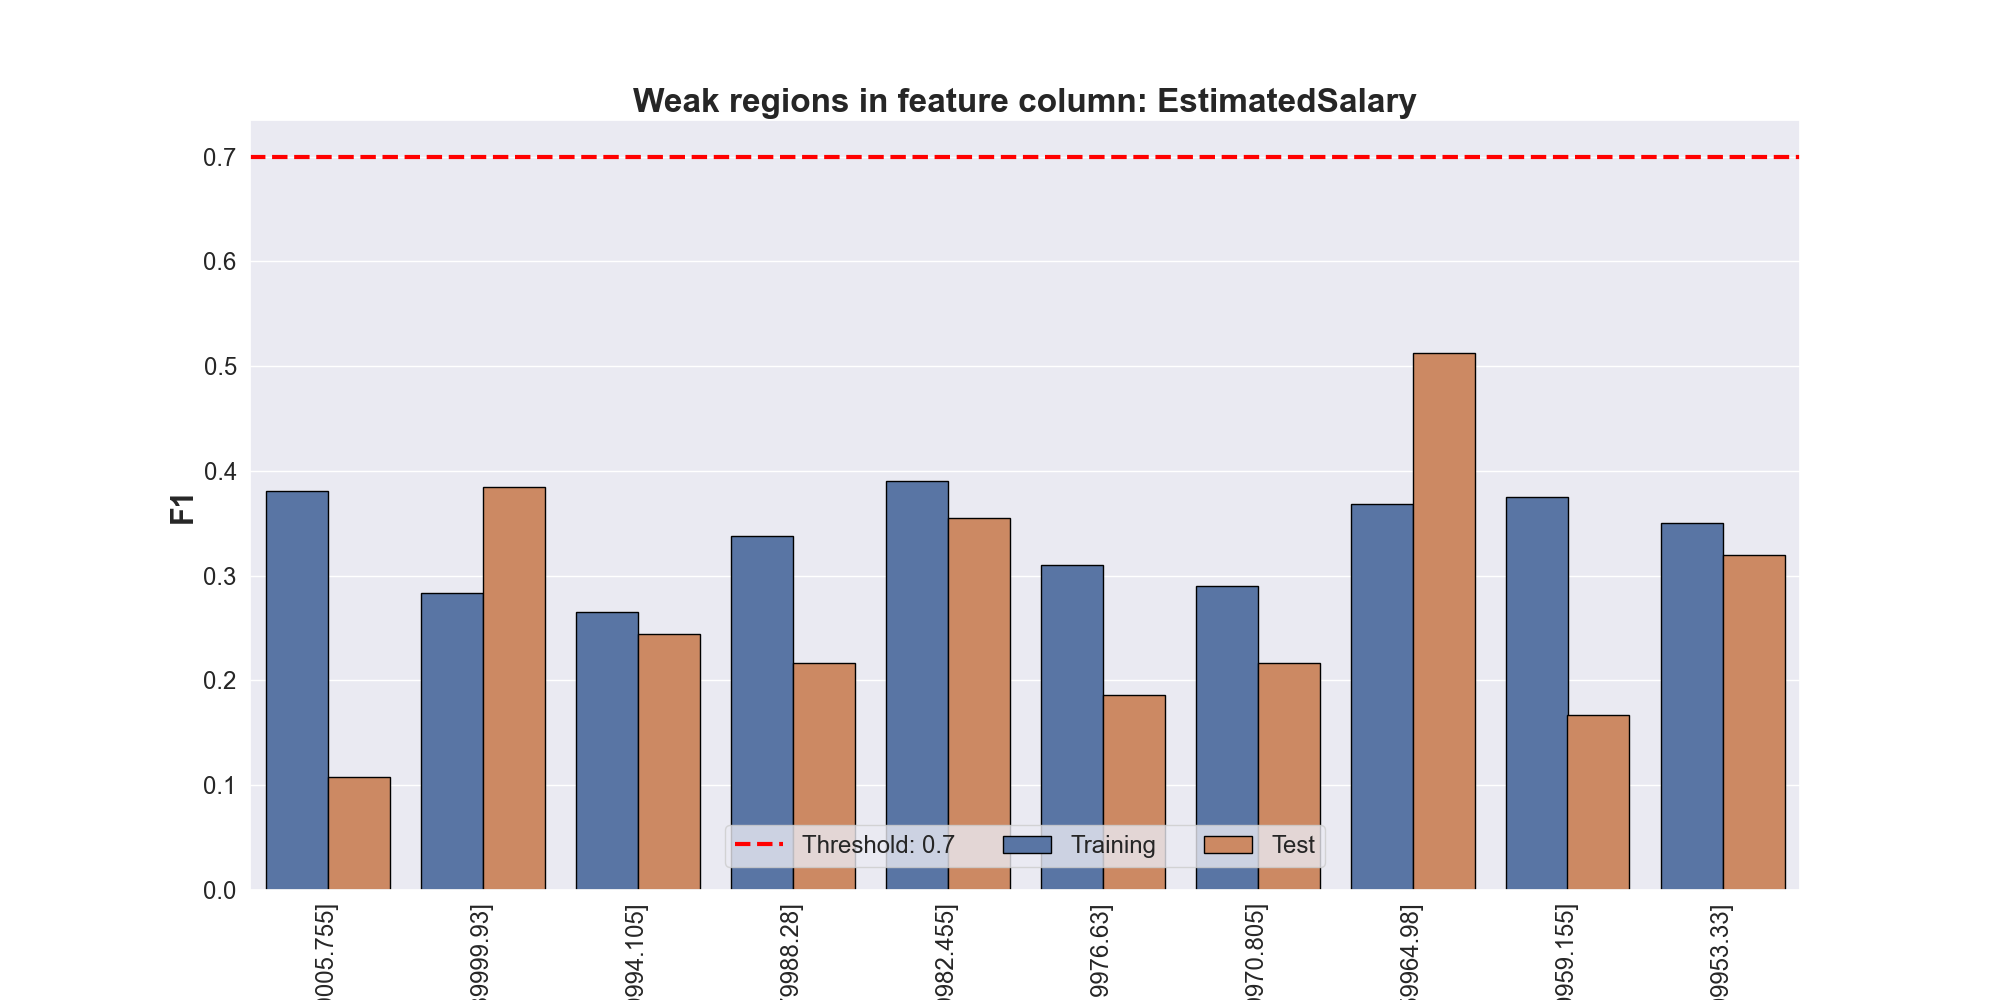
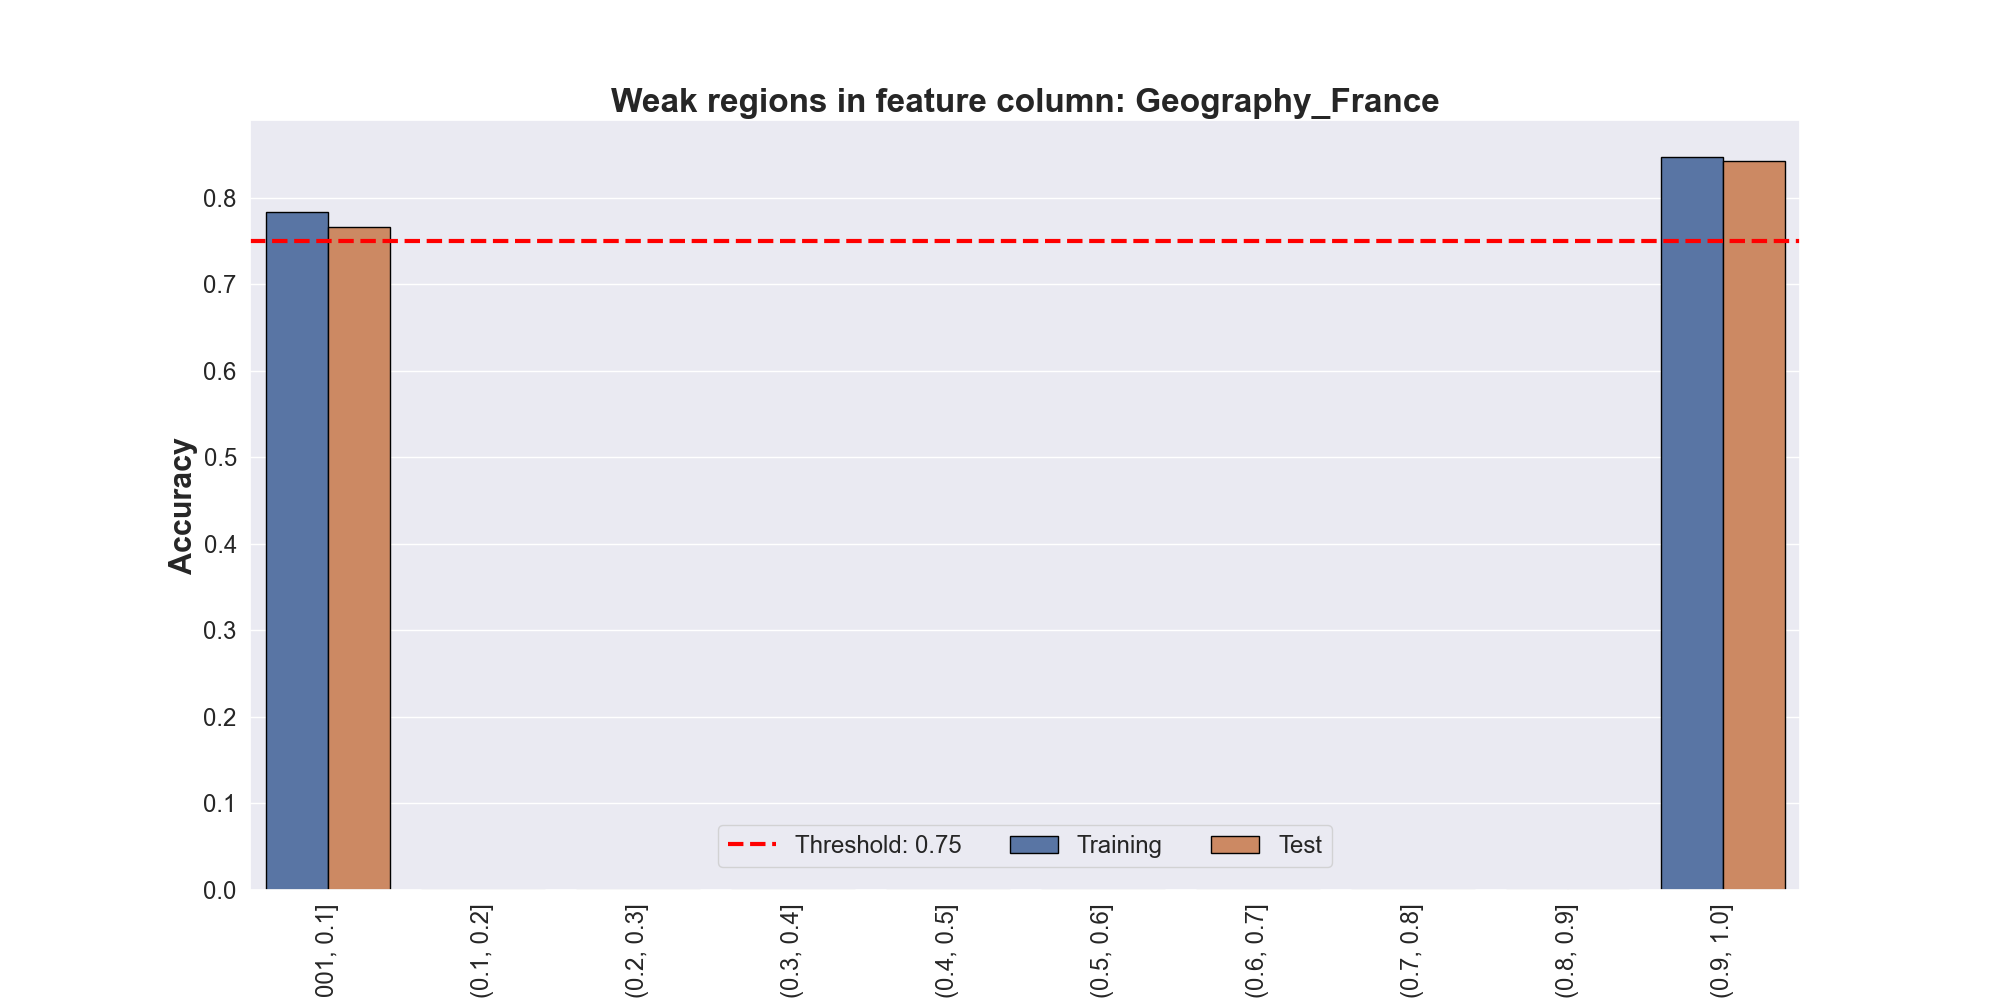
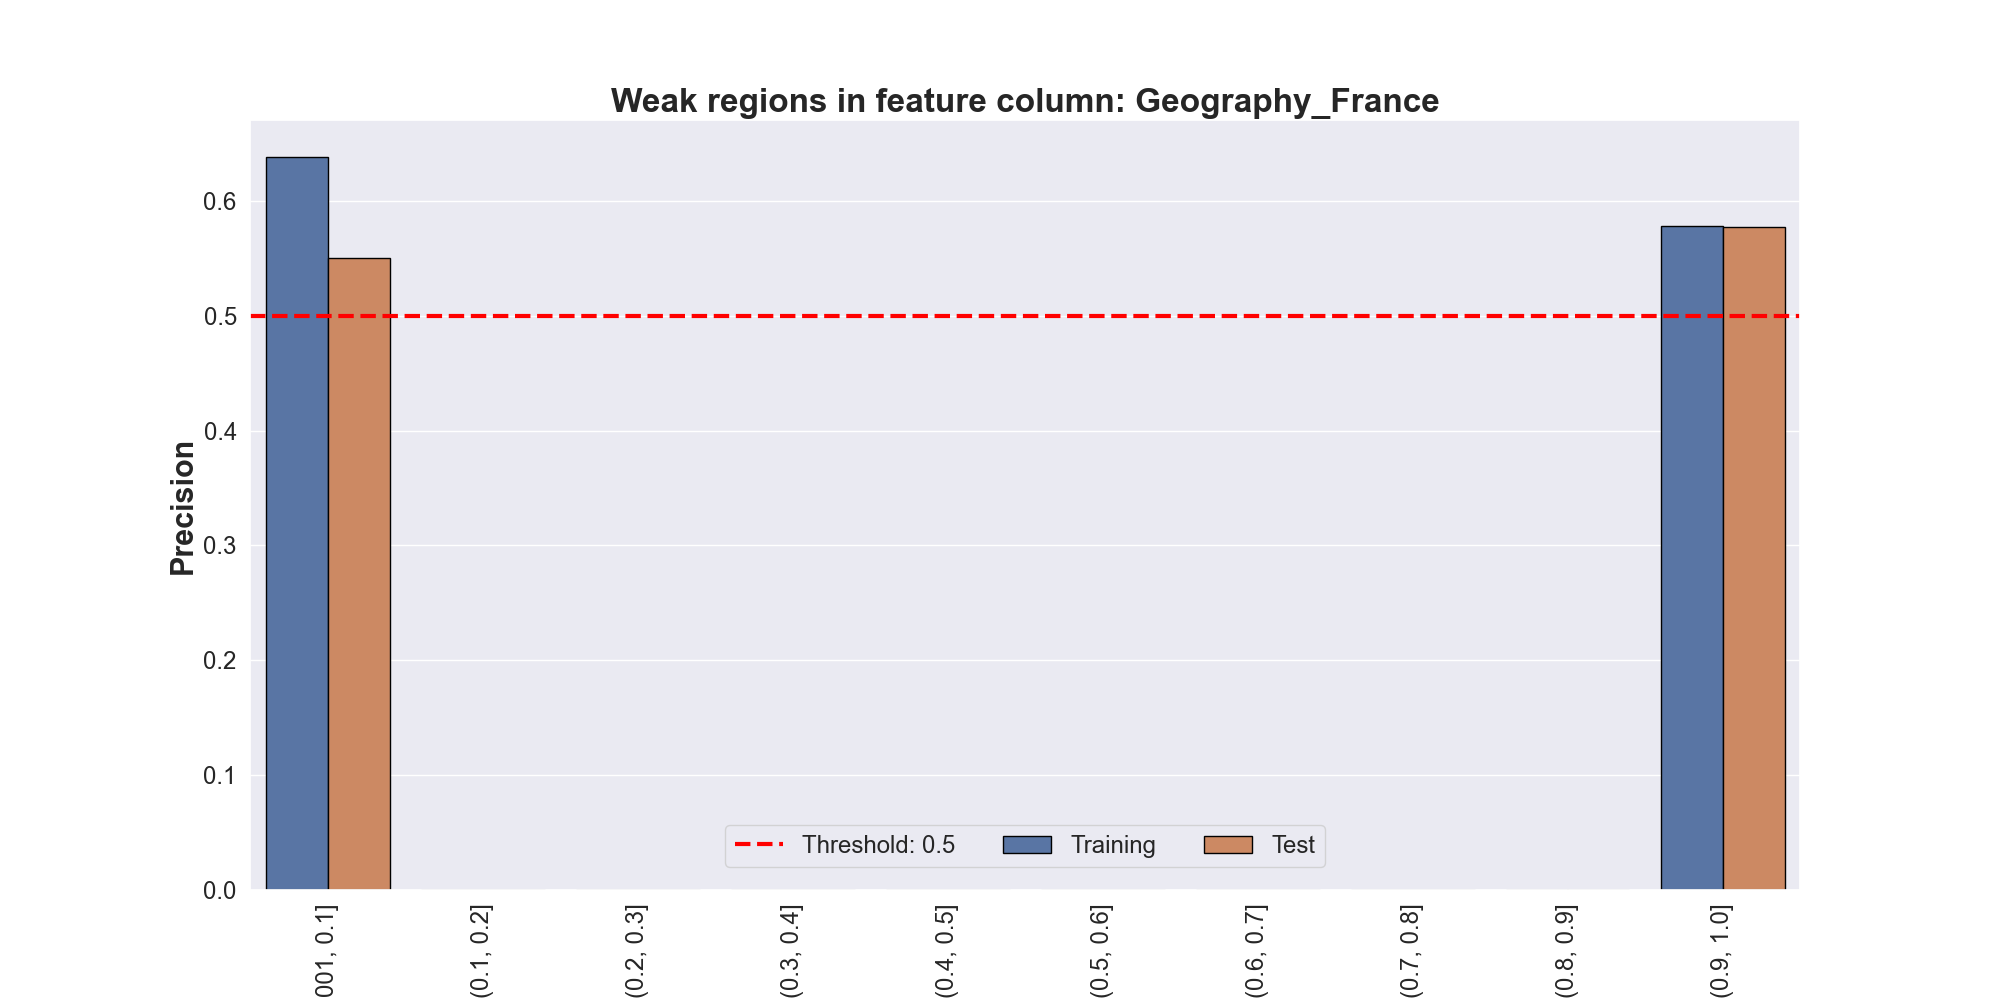
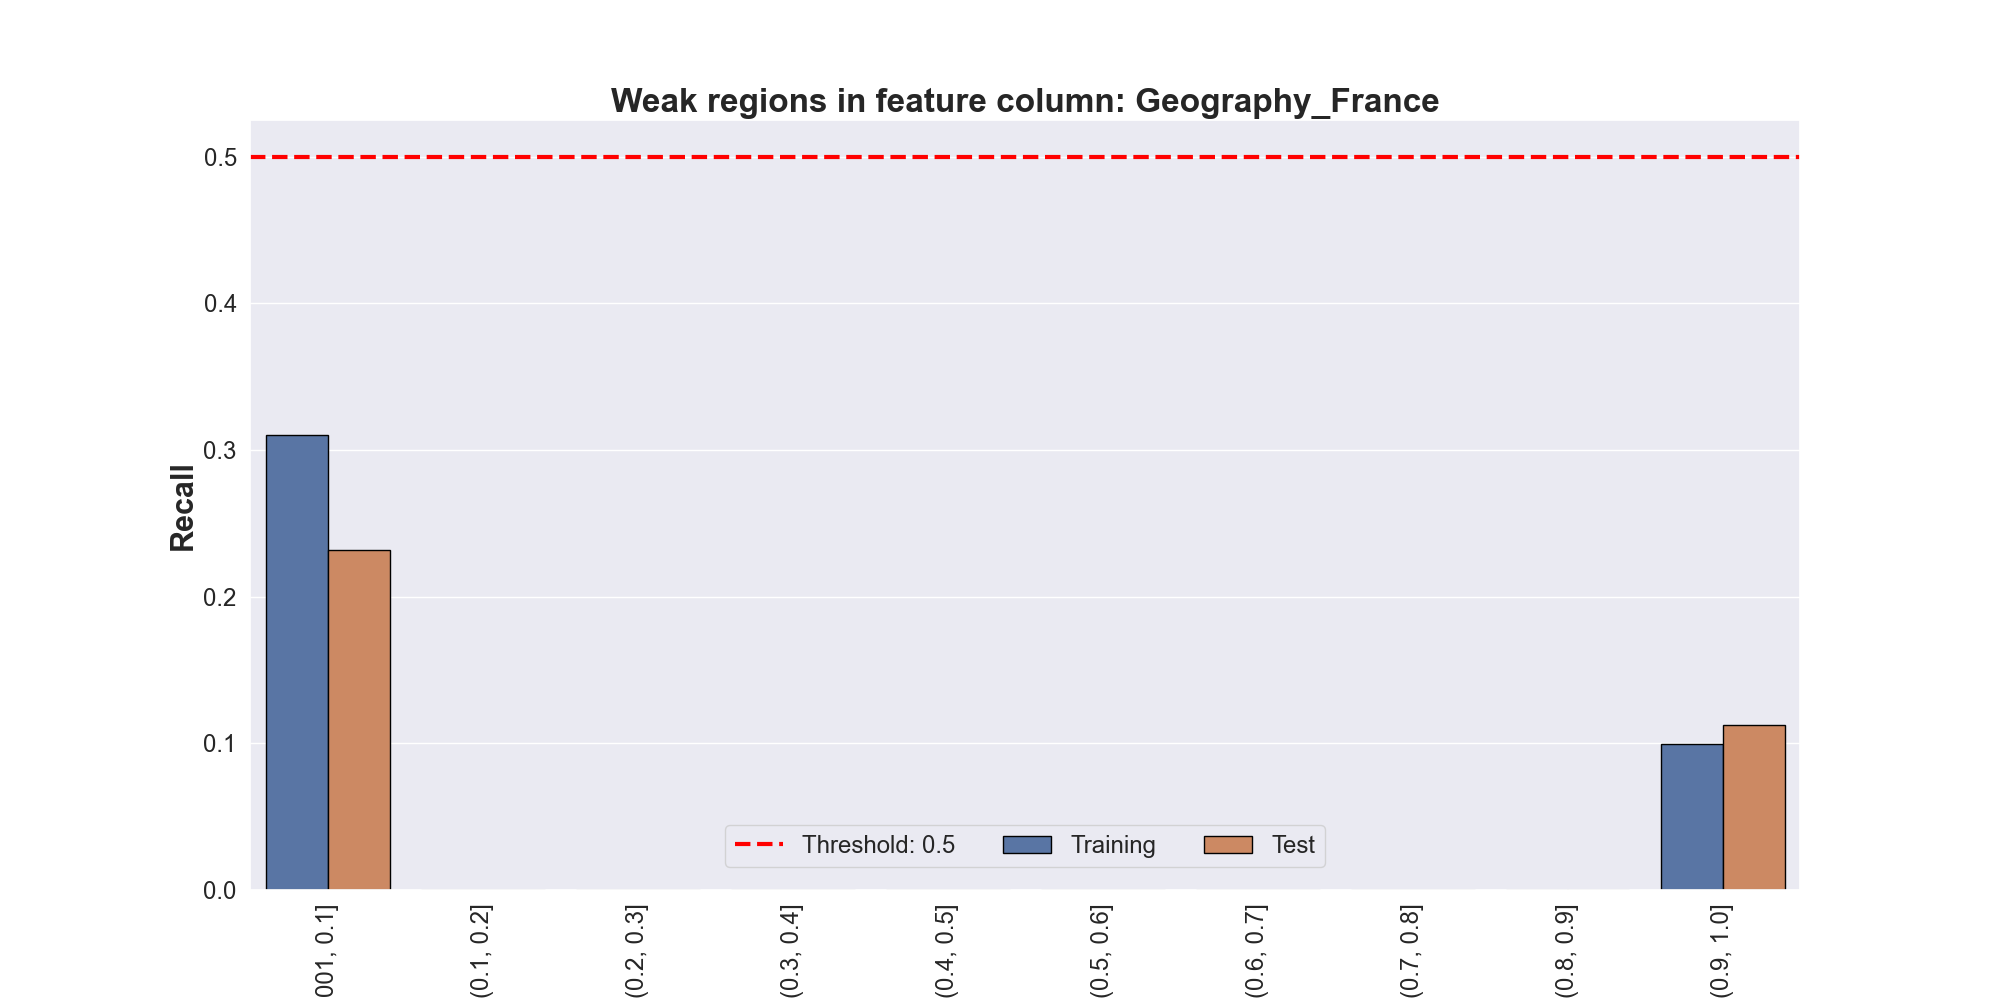
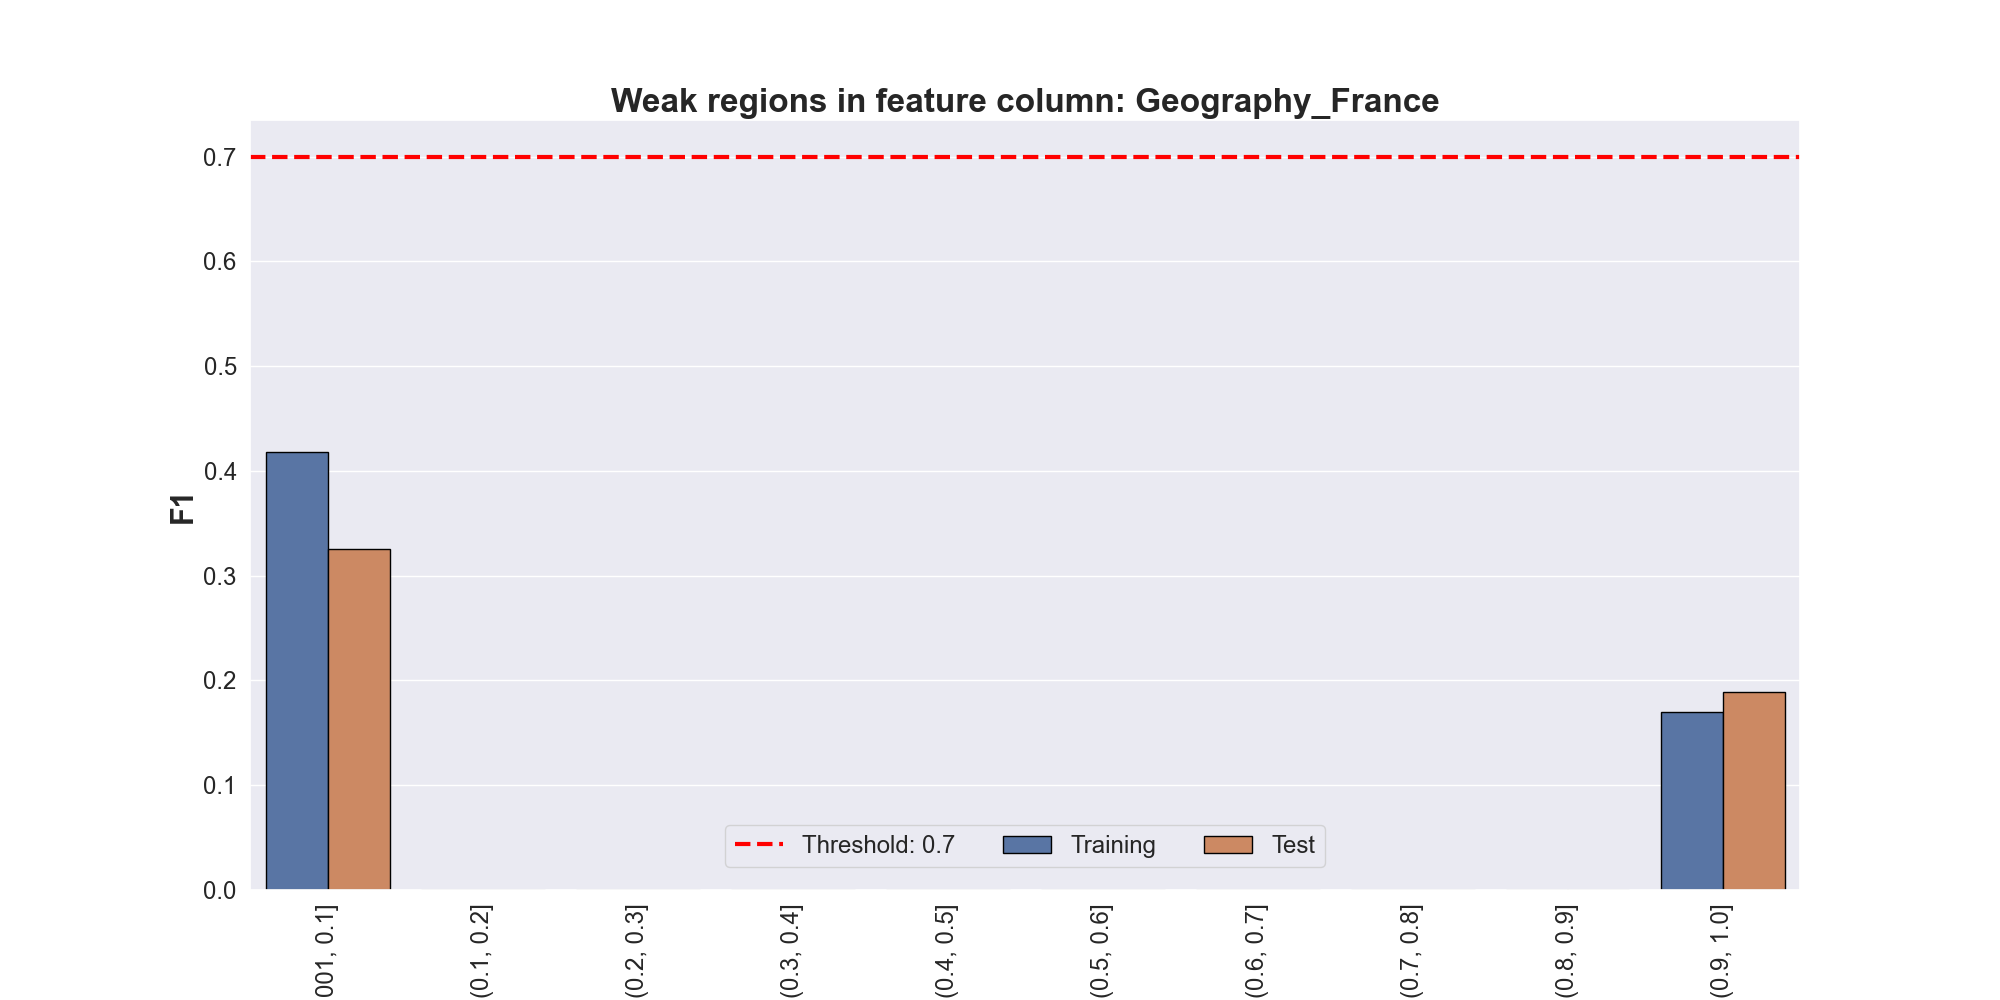
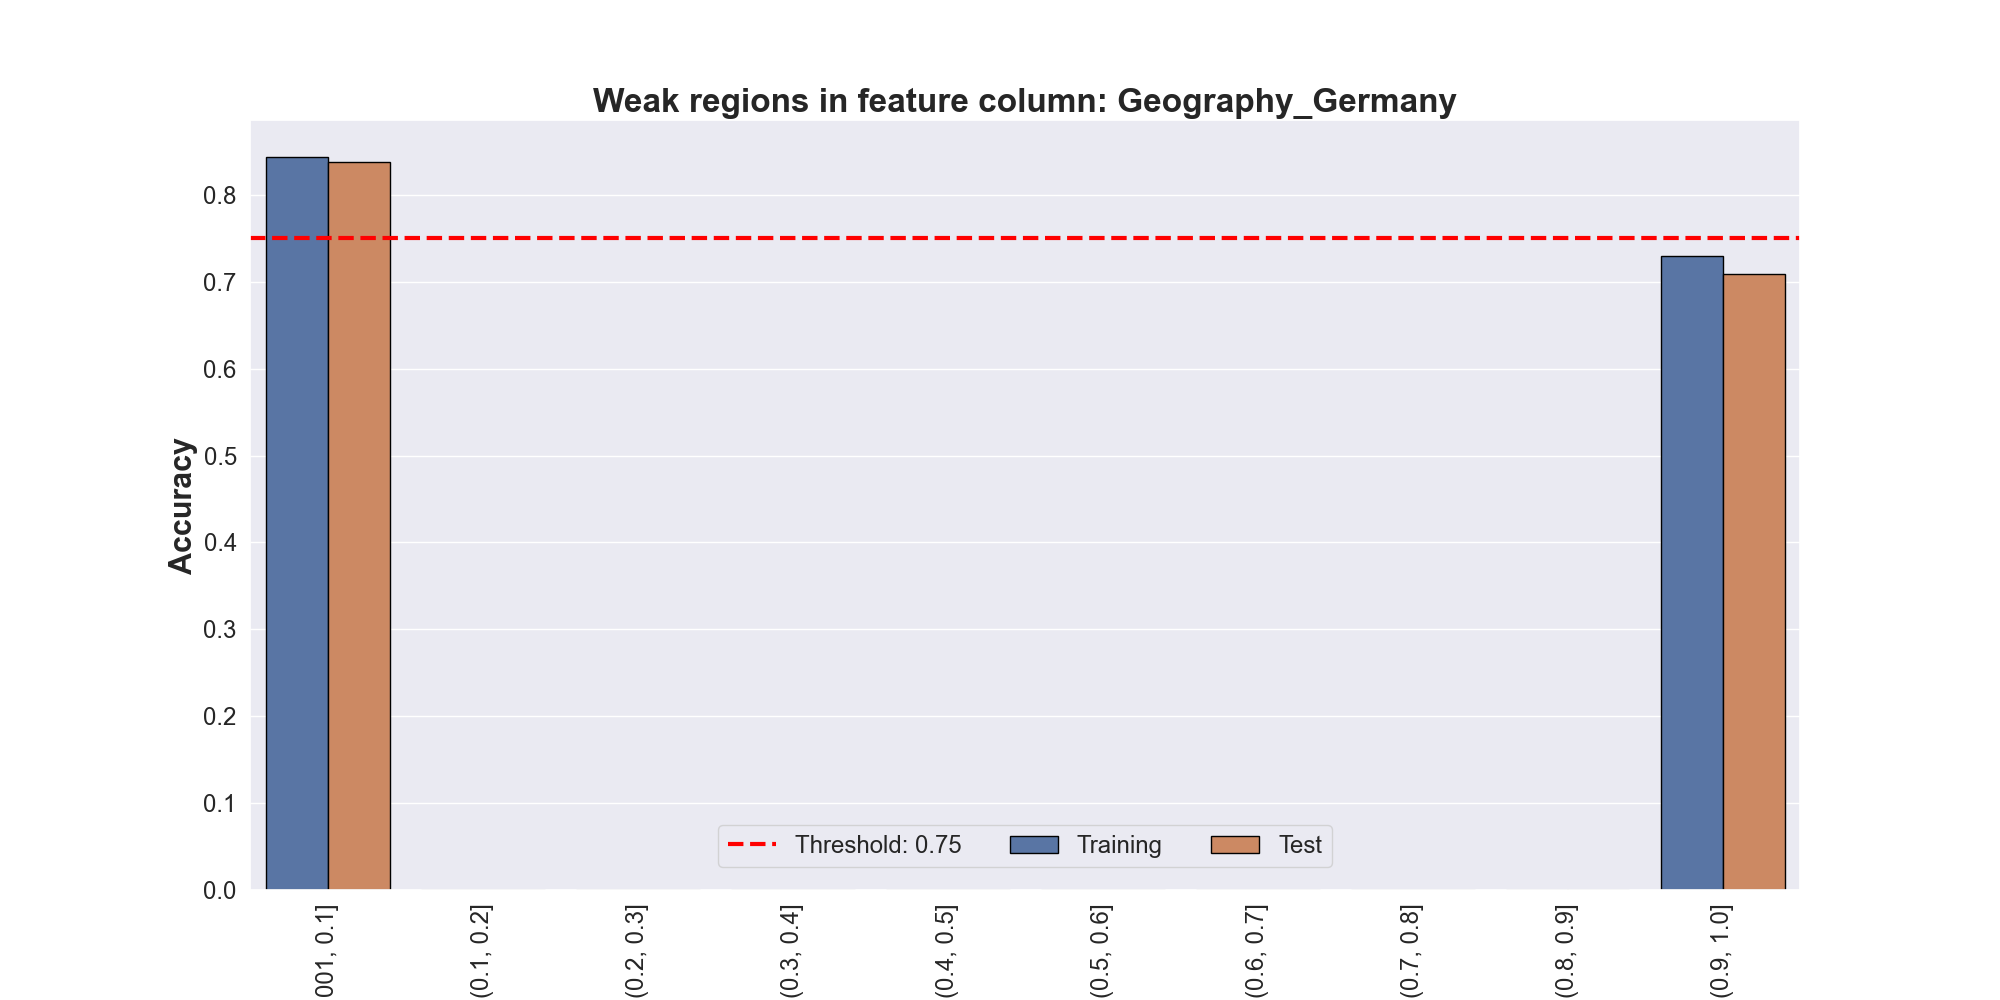
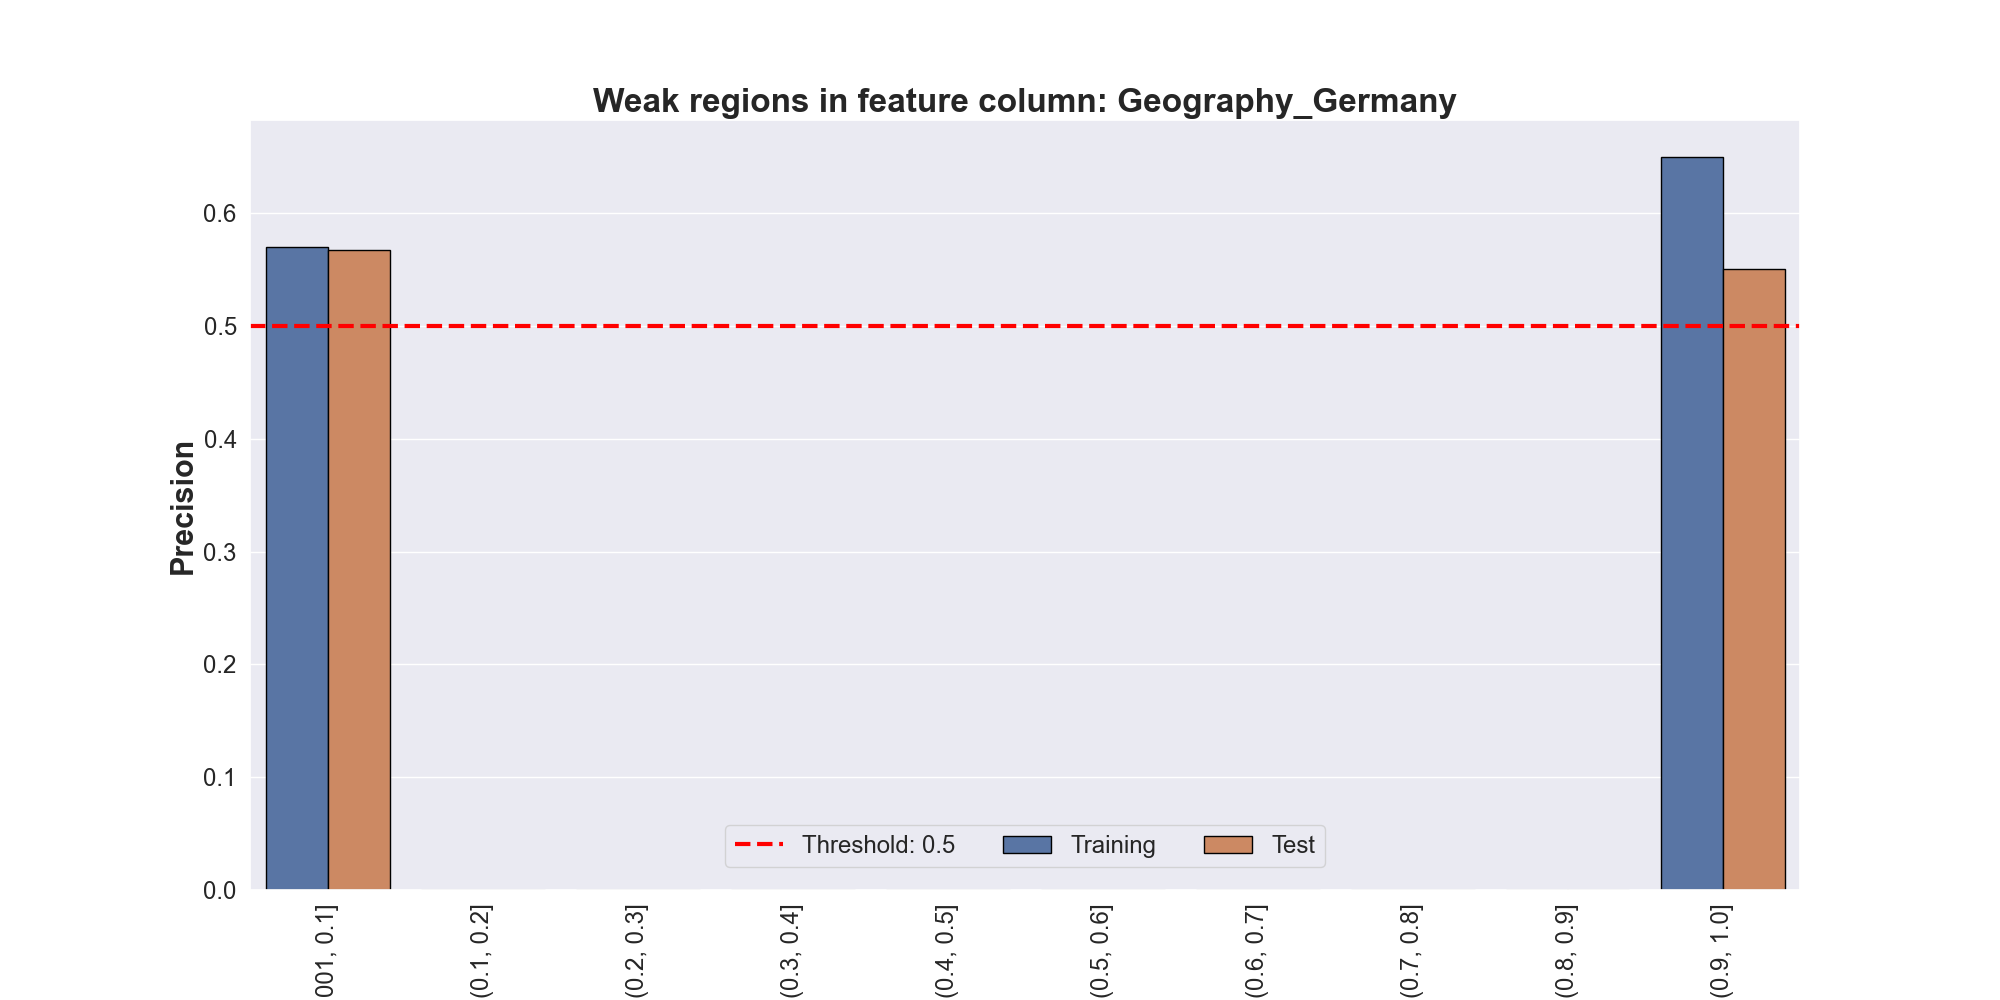
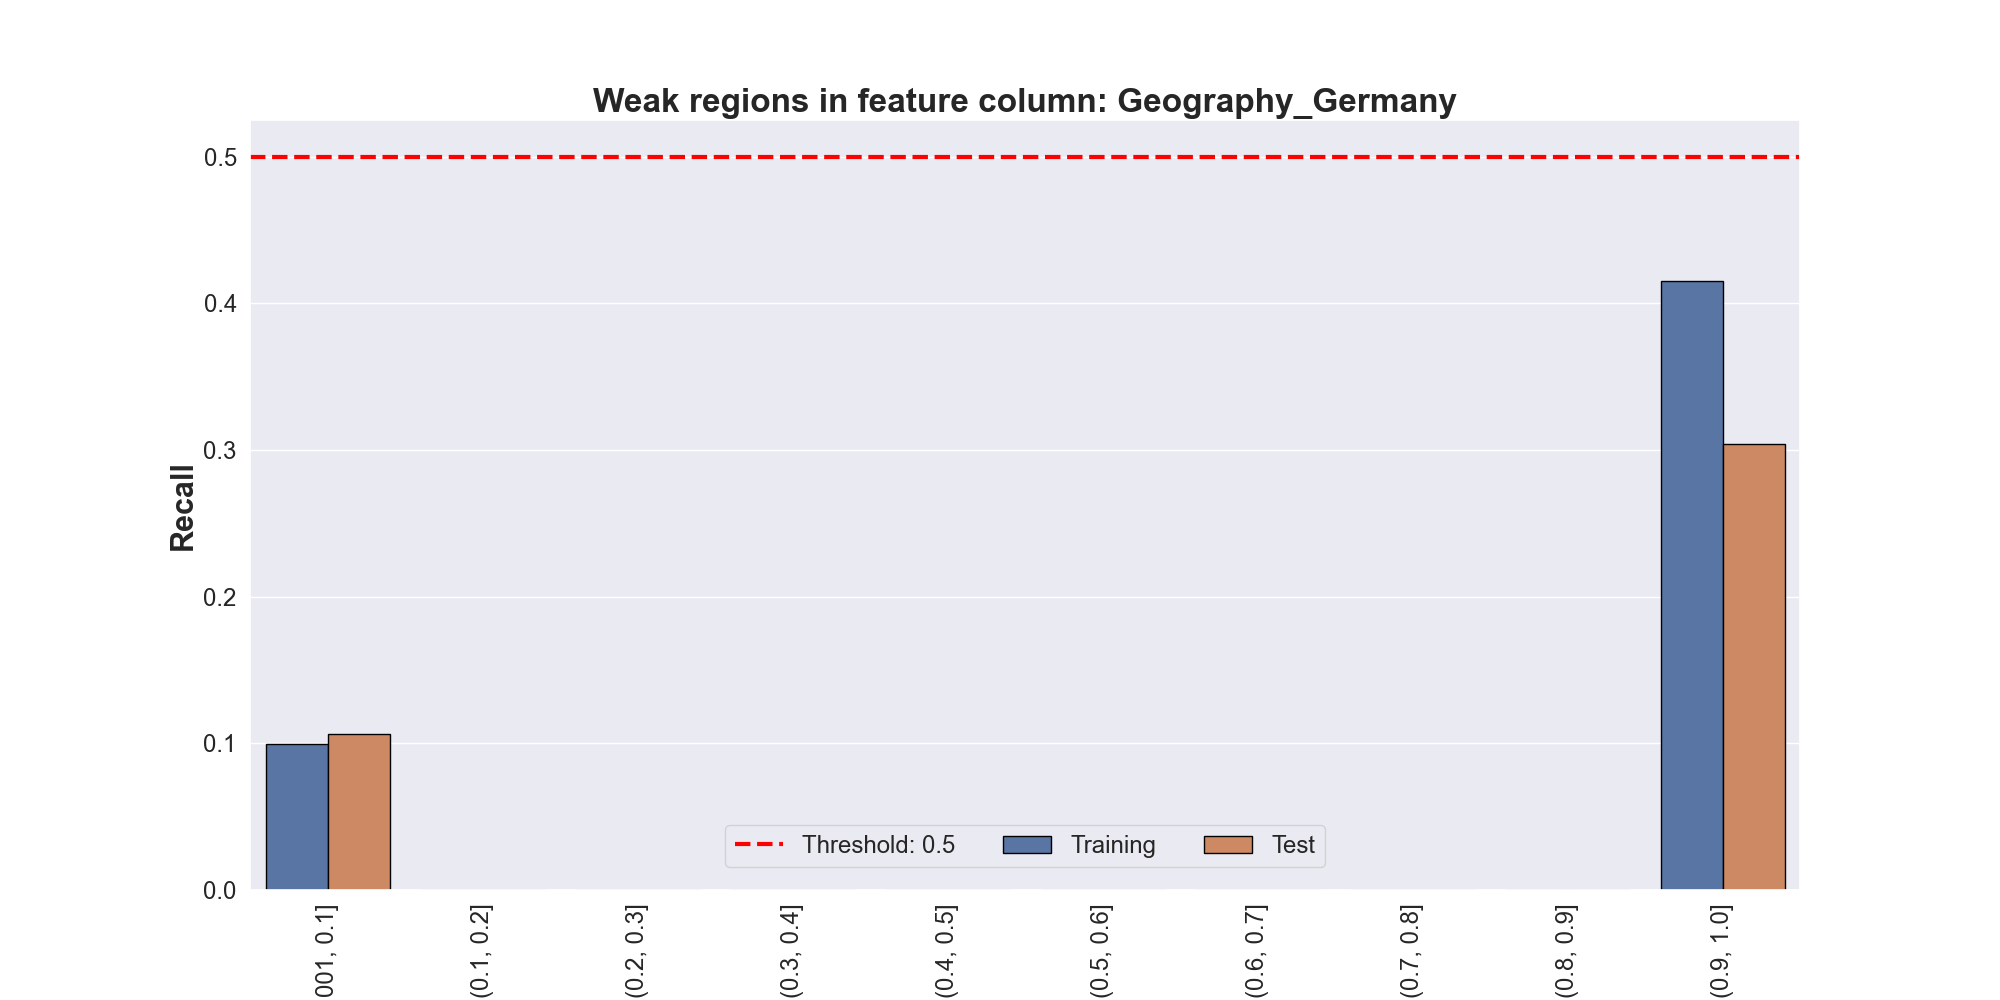
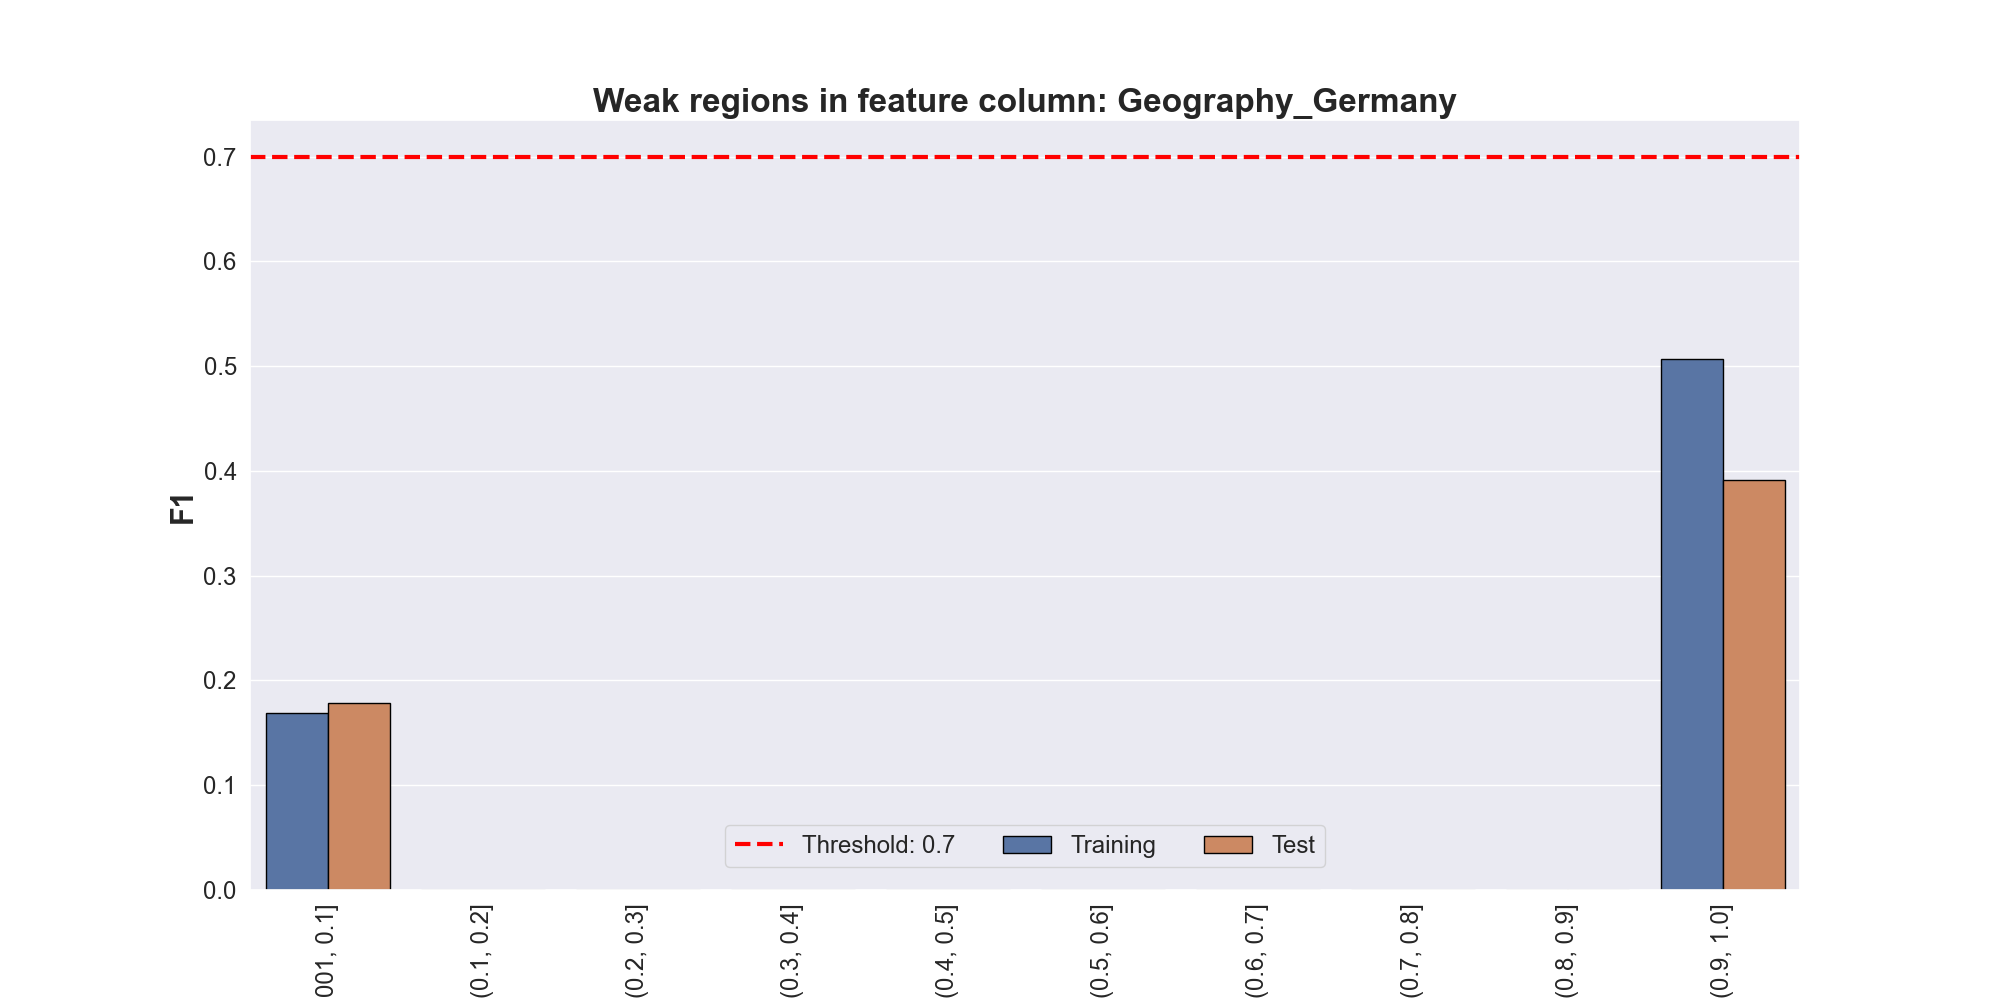
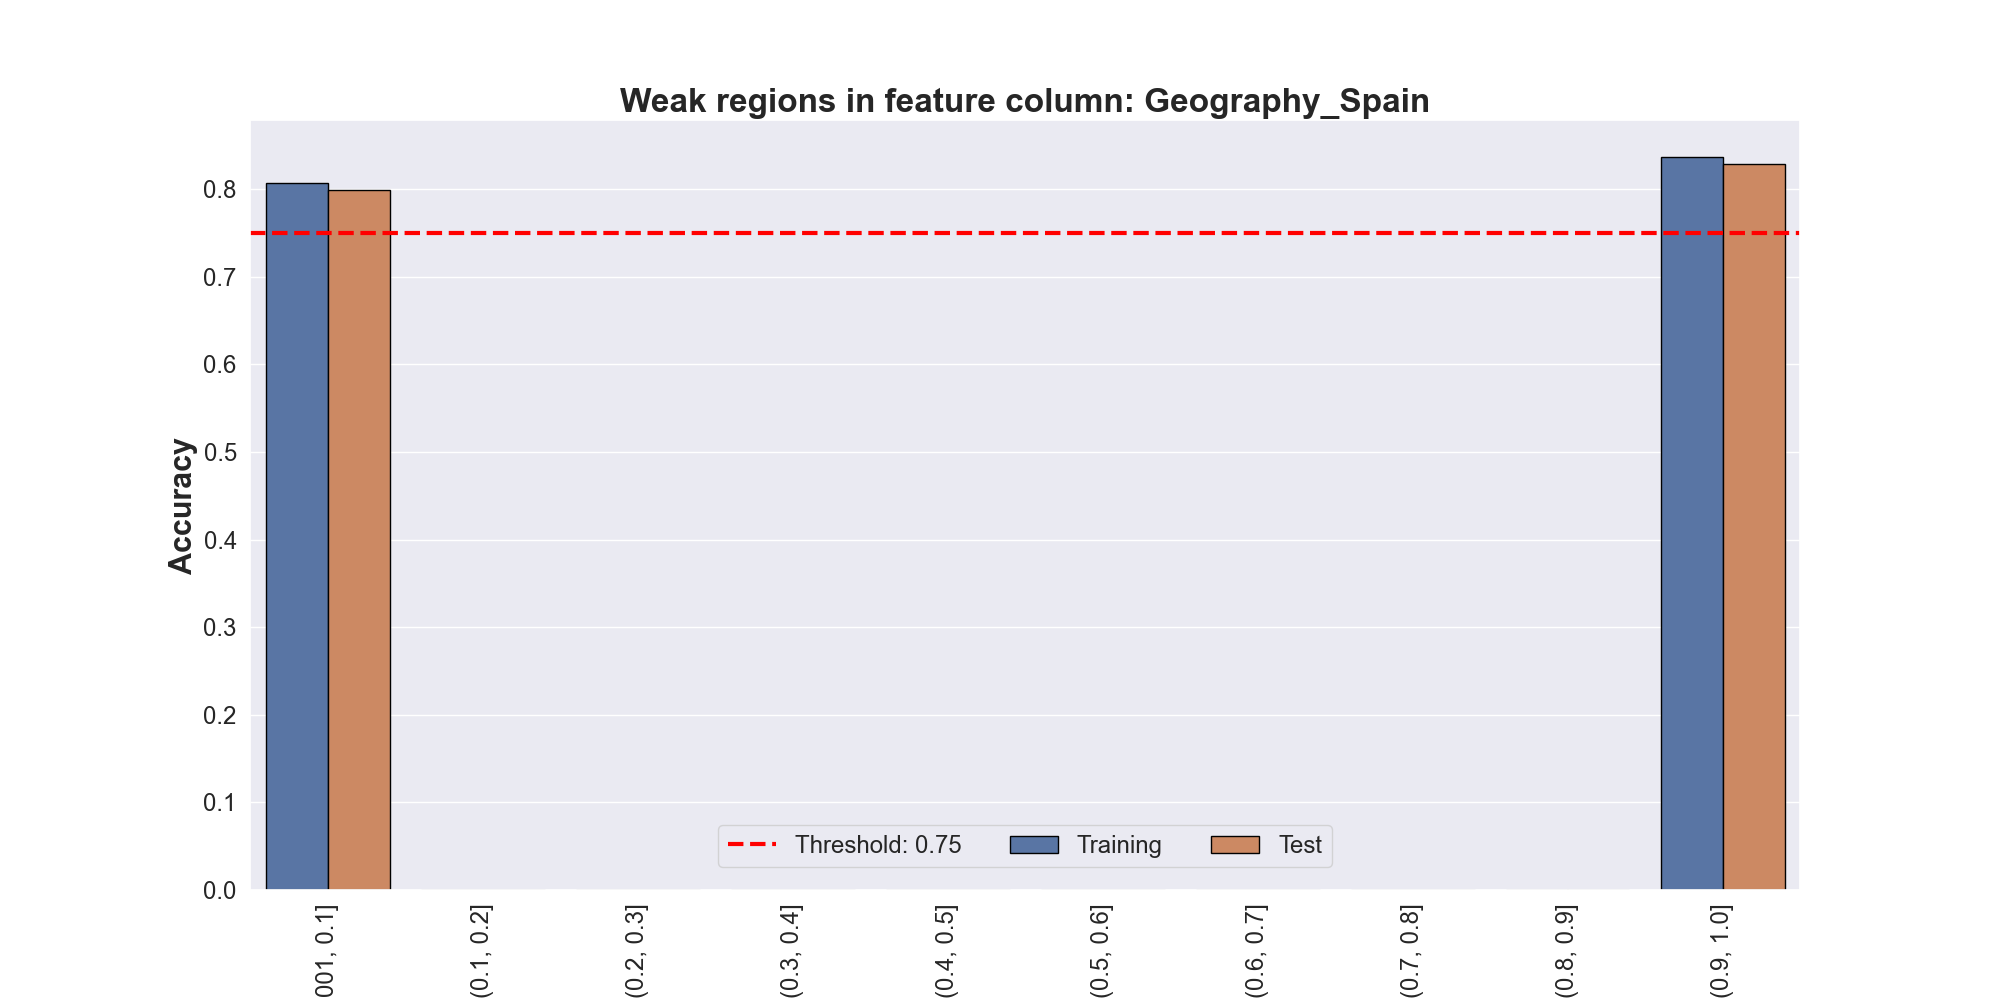
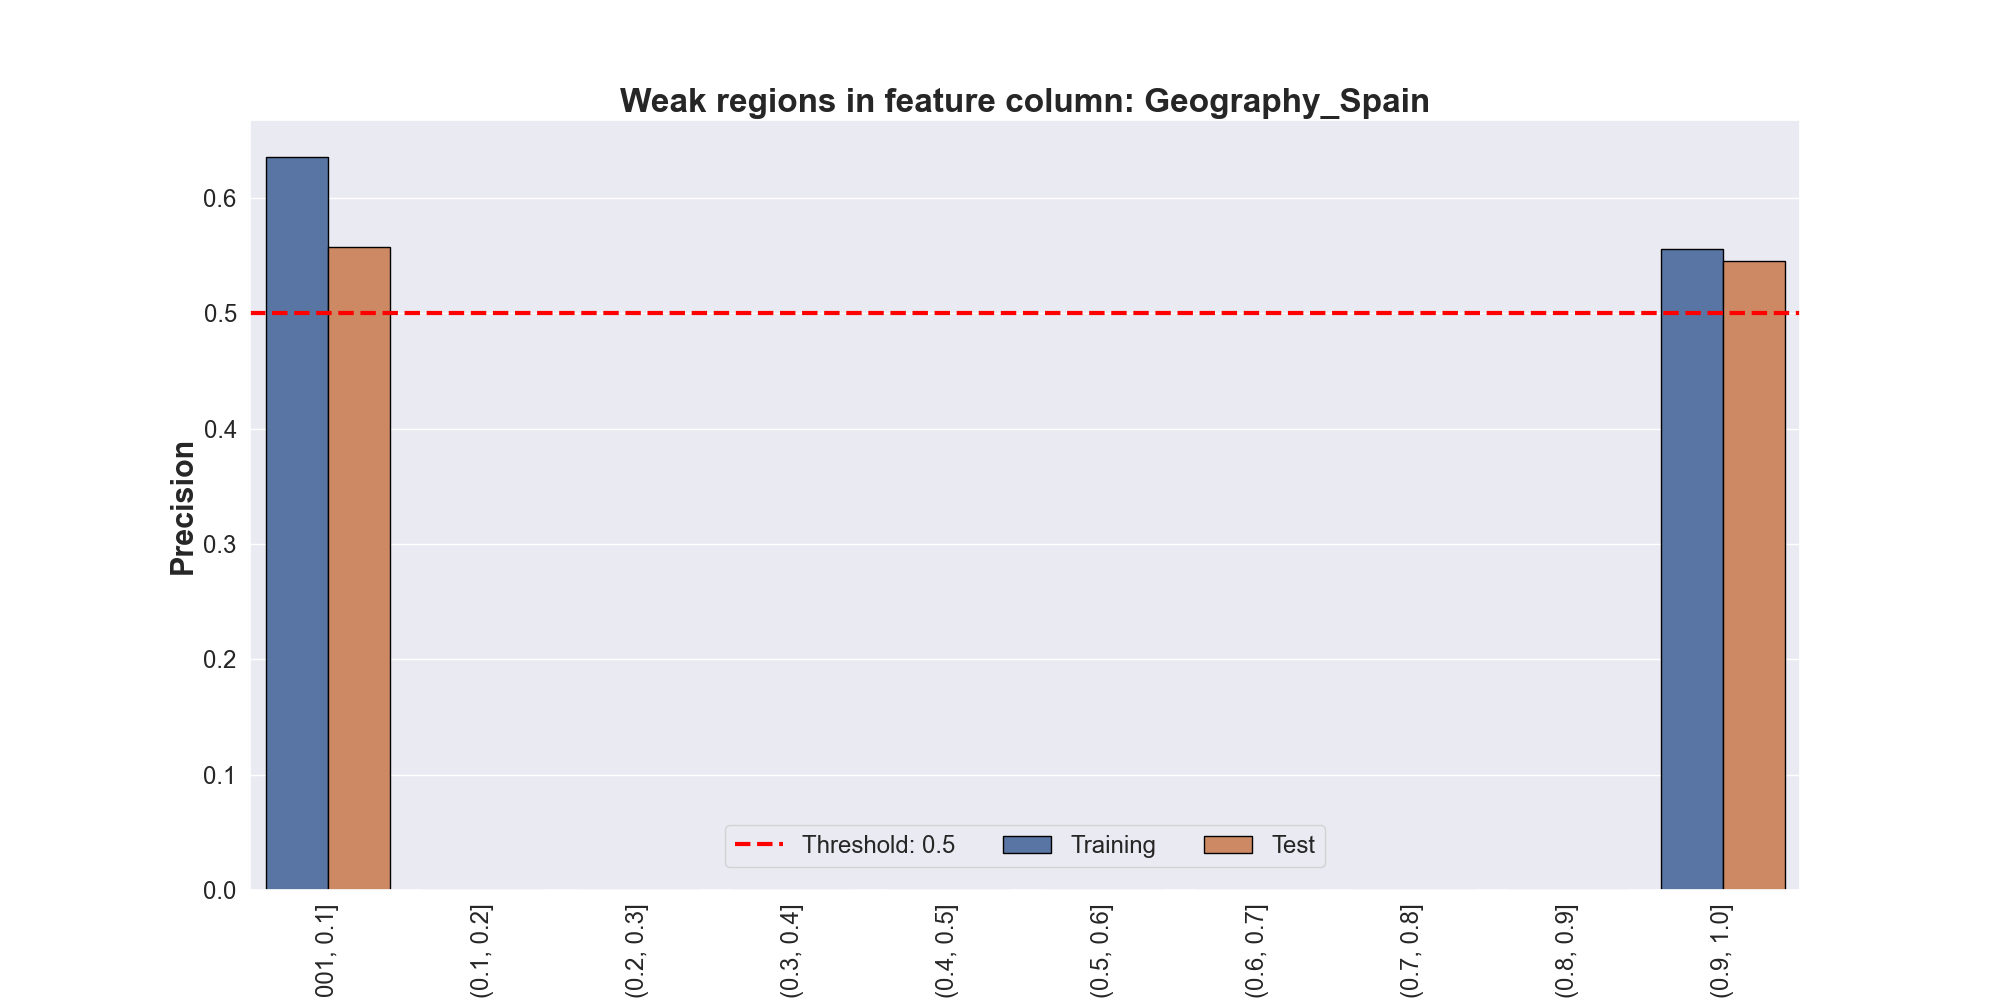
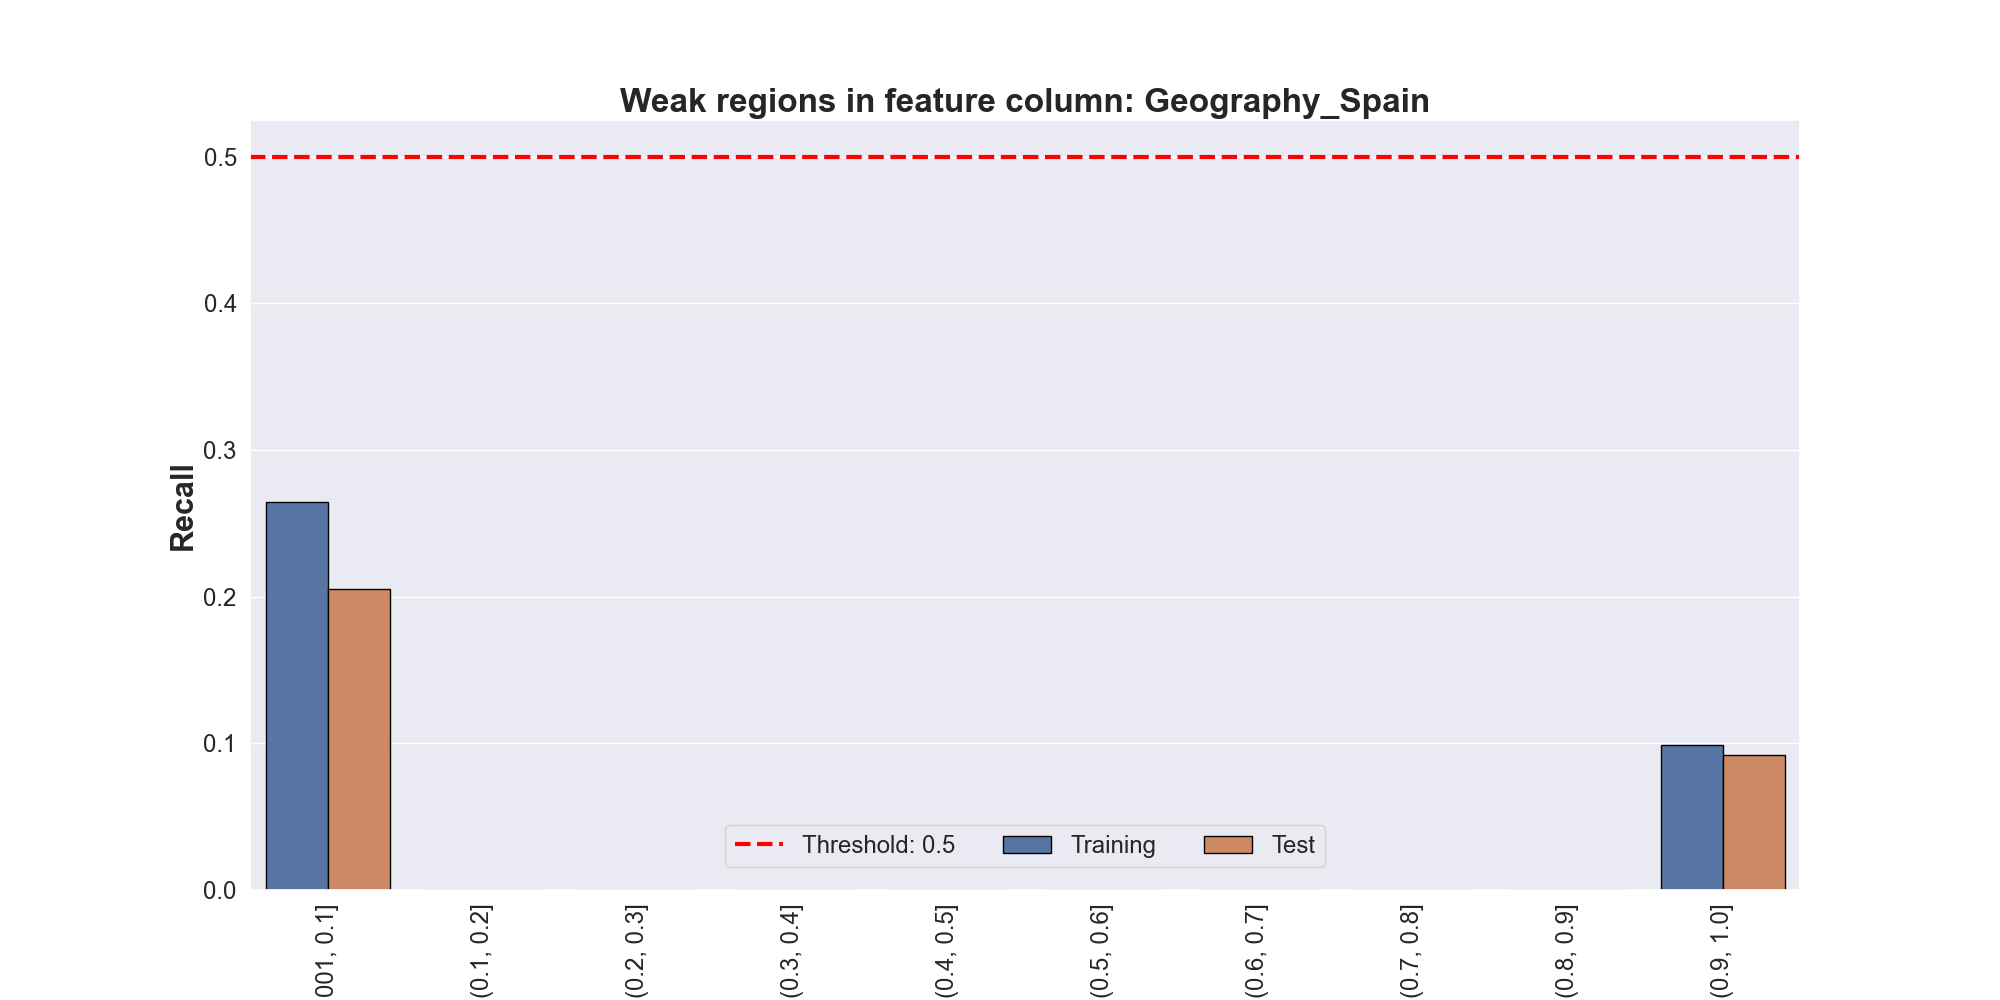
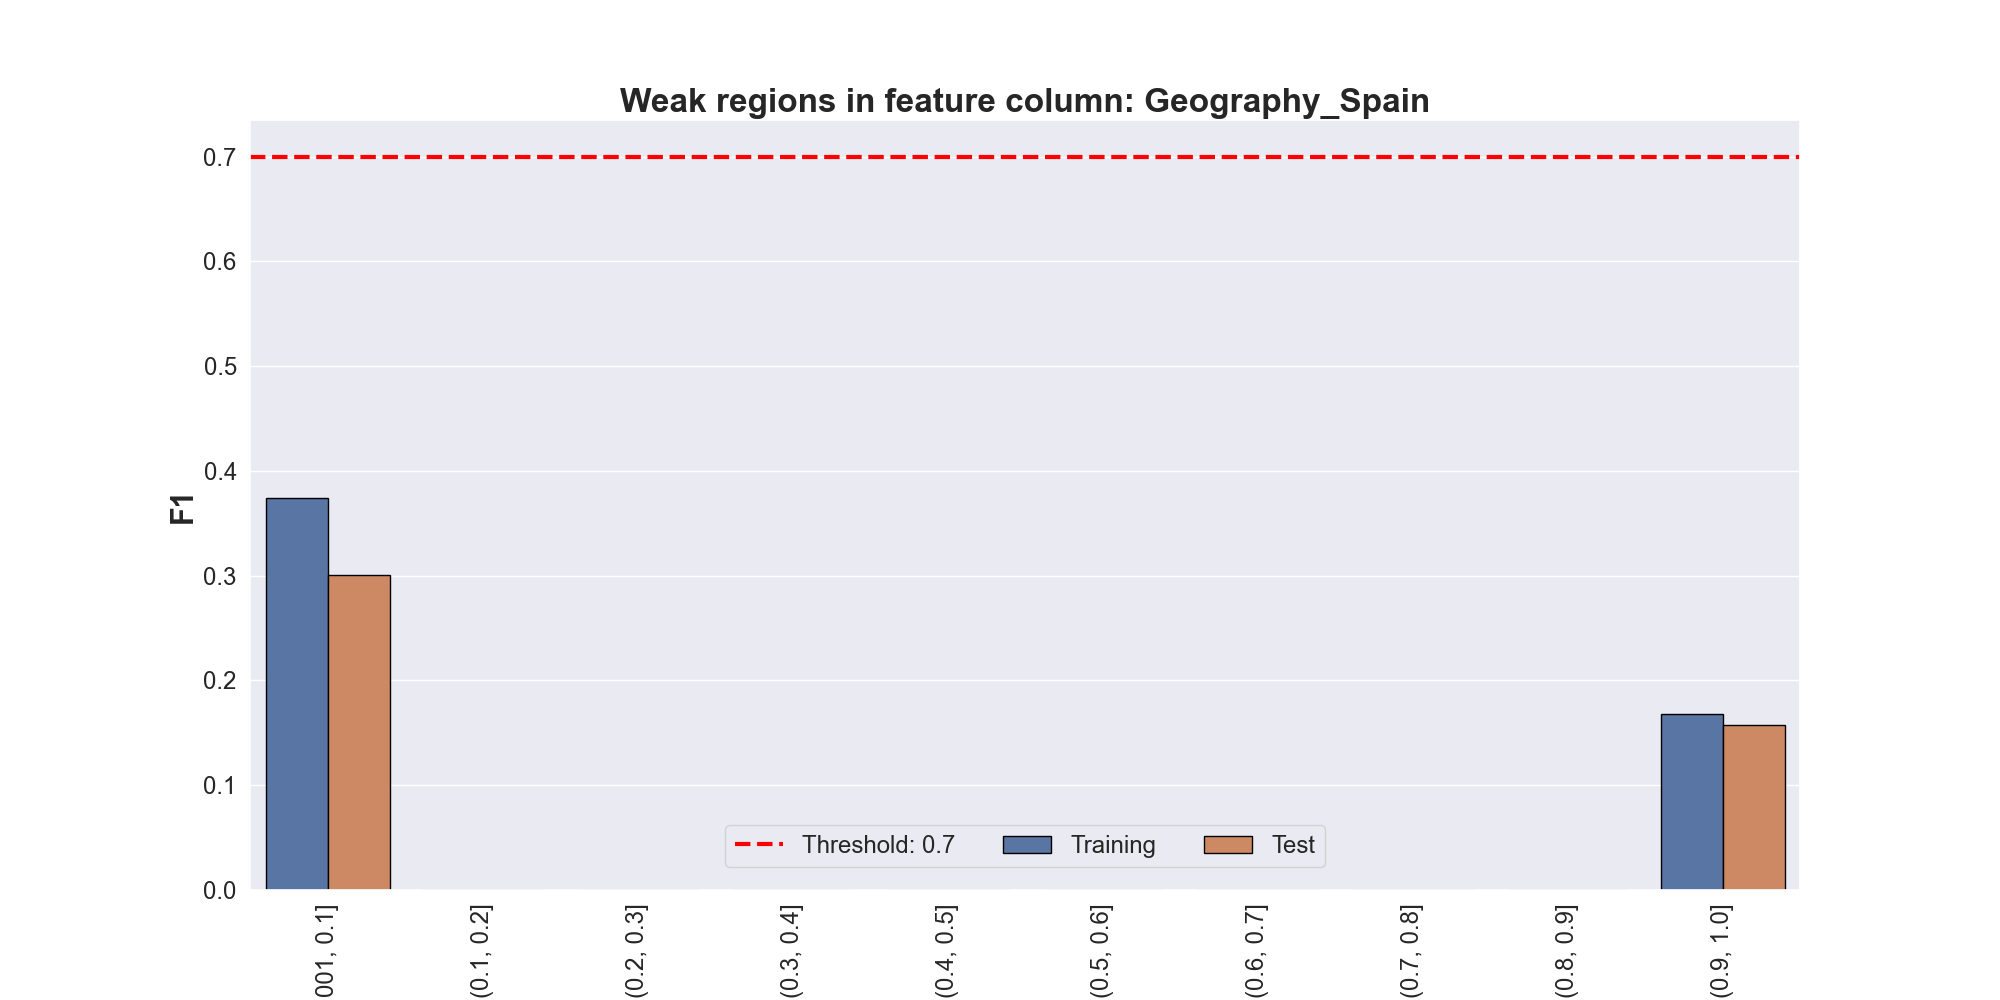
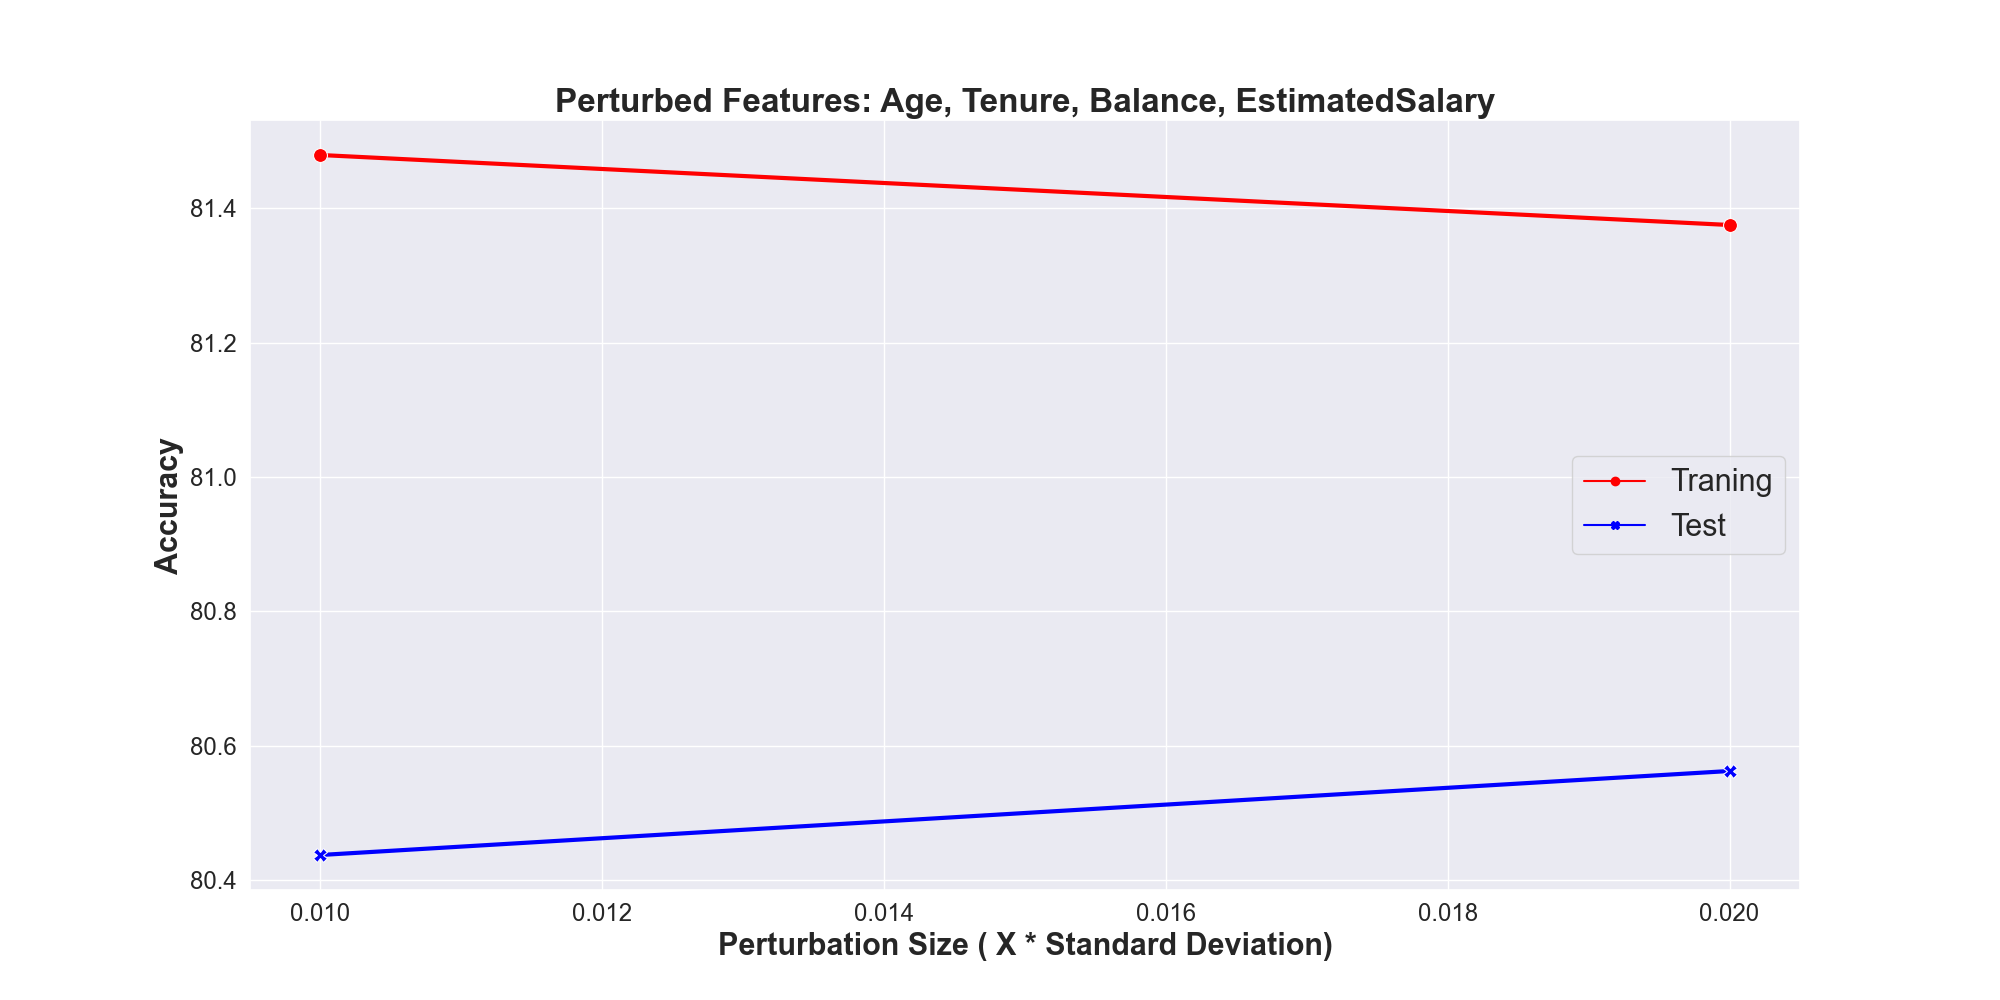

In [17]:
model_plan = vm.run_test_plan("sklearn_classifier", model=vm_model, train_ds=vm_train_ds, test_ds=vm_test_ds)